In [3]:
import xarray as xr
import scipy
import numpy as np
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt

Prepare CMIP6 data from next gen archive 

/tmp/ipykernel_2612385/4006356918.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])


            Greenland-Iceland  N.W.North-America  N.E.North-America  \
time                                                                  
1850-01-16                NaN                NaN                NaN   
1850-02-16                NaN                NaN                NaN   
1850-03-16                NaN                NaN                NaN   
1850-04-16                NaN                NaN                NaN   
1850-05-16                NaN                NaN                NaN   
...                       ...                ...                ...   
2100-08-16                NaN                NaN                NaN   
2100-09-16                NaN                NaN                NaN   
2100-10-16                NaN                NaN                NaN   
2100-11-16                NaN                NaN                NaN   
2100-12-16                NaN                NaN                NaN   

            W.North-America  C.North-America  E.North-America  \
time       

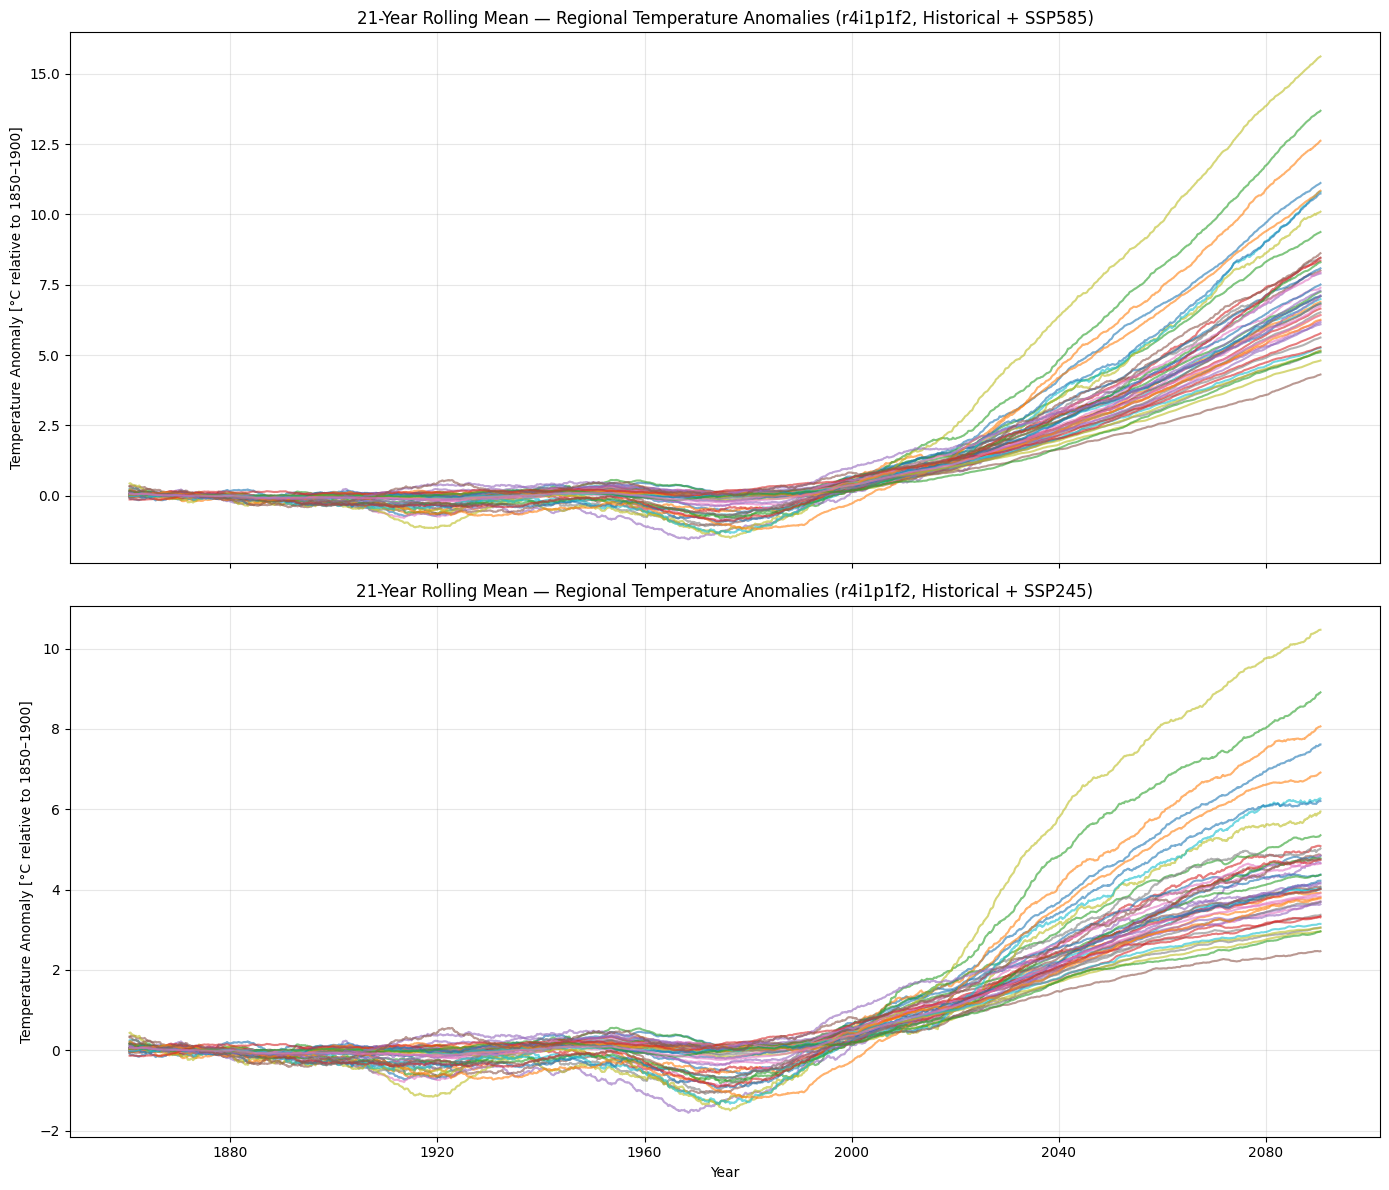

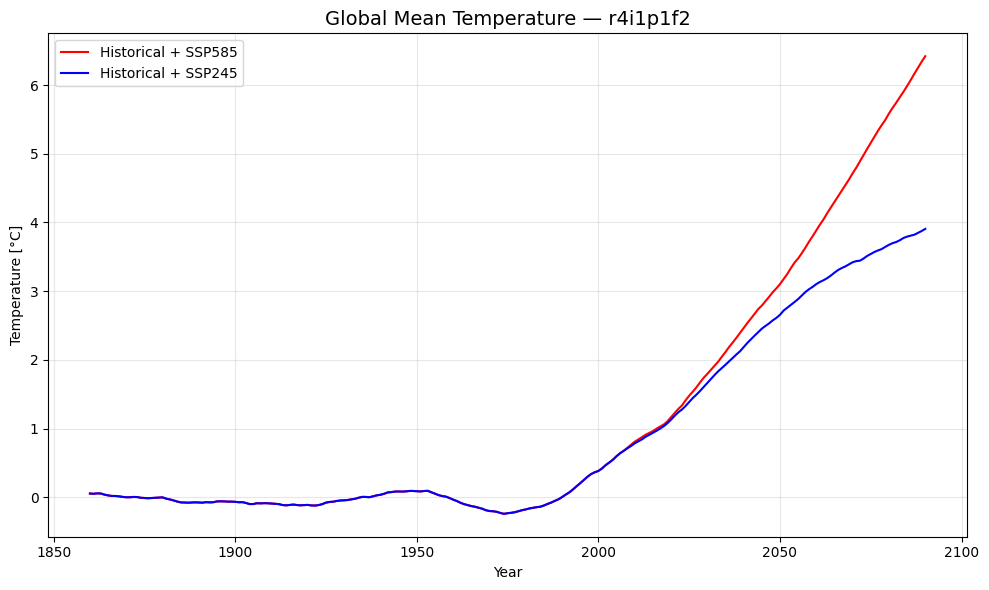

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Configs 
REGIONAL_AVERAGES_PATH = '/home/niklas/MERCURY/data/preprocessed'
GLOBAL_AVERAGES_PATH = '/home/niklas/MERCURY/data/preprocessed' 
MODEL = 'UKESM1-0-LL'
INDICATOR = 'tas'
REGIONS = 'AR6_GLOBAL'
TRAIN_SCENARIO = 'SSP585'
TEST_SCENARIO = 'SSP245'
ENSEMBLE = 'r4i1p1f2'
START_TIME = 1850
END_TIME = 2100

# From Configs

PATH_REGIONAL_DATA = f'{REGIONAL_AVERAGES_PATH}/{MODEL}_{INDICATOR}_regional_averages.csv'

PATH_GLOBAL_DATA = f'{GLOBAL_AVERAGES_PATH}/{MODEL}_GMT.csv'
# Load regional data
regional_data = pd.read_csv(PATH_REGIONAL_DATA)



# Load global data
global_data = pd.read_csv(PATH_GLOBAL_DATA)


# --- Config ---

ENSEMBLE = "r4i1p1f2"
window_size = 21 * 12  # 21 years × 12 months

# --- 1. Helper to filter ensemble + scenario ---
def filter_ensemble(df, ensemble, scenario=None):
    if scenario:
        return df[df["simulation_name"].str.contains(f"{scenario.lower()}_{ensemble}", case=False)]
    else:
        return df[df["simulation_name"].str.contains(f"historical_{ensemble}", case=False)]

# --- 2. Filter datasets ---
regional_hist = filter_ensemble(regional_data, ENSEMBLE)
regional_train = filter_ensemble(regional_data, ENSEMBLE, TRAIN_SCENARIO)
regional_test = filter_ensemble(regional_data, ENSEMBLE, TEST_SCENARIO)

global_hist = filter_ensemble(global_data, ENSEMBLE)
global_train = filter_ensemble(global_data, ENSEMBLE, TRAIN_SCENARIO)
global_test = filter_ensemble(global_data, ENSEMBLE, TEST_SCENARIO)

# --- 3. Concatenate separately (historical + train) and (historical + test) ---
regional_train_full = pd.concat([regional_hist, regional_train]).sort_values("time")
regional_test_full = pd.concat([regional_hist, regional_test]).sort_values("time")

global_train_full = pd.concat([global_hist, global_train]).sort_values("year")
global_test_full = pd.concat([global_hist, global_test]).sort_values("year")

# --- 4. Convert time to datetime ---
for df in [regional_hist, regional_train_full, regional_test_full]:
    df["time"] = pd.to_datetime(df["time"])

# --- 5. Compute 1850–1900 mean for anomalies ---
baseline_period = regional_hist[
    (regional_hist["time"].dt.year >= 1850) & (regional_hist["time"].dt.year <= 1900)
]

# Exclude non-numeric columns
region_cols = [c for c in regional_hist.columns if c not in ["simulation_name", "time"]]

baseline_mean = baseline_period[region_cols].mean()

# --- 6. Subtract baseline (convert to anomalies) ---
for df in [regional_train_full, regional_test_full]:
    df[region_cols] = df[region_cols] - baseline_mean

# --- 7. Compute 21-year rolling mean ---
regional_train_roll = regional_train_full.set_index("time")[region_cols].rolling(window_size, center=True).mean()
regional_test_roll = regional_test_full.set_index("time")[region_cols].rolling(window_size, center=True).mean()

# --- 8. Plot regional anomalies ---
fig, ax = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

print(regional_train_roll)
print(global_train_full)

# Train scenario
for col in region_cols:
    ax[0].plot(regional_train_roll.index, regional_train_roll[col], alpha=0.6)
ax[0].set_title(f"21-Year Rolling Mean — Regional Temperature Anomalies ({ENSEMBLE}, Historical + {TRAIN_SCENARIO})")
ax[0].set_ylabel("Temperature Anomaly [°C relative to 1850–1900]")
ax[0].grid(True, alpha=0.3)

# Test scenario
for col in region_cols:
    ax[1].plot(regional_test_roll.index, regional_test_roll[col], alpha=0.6)
ax[1].set_title(f"21-Year Rolling Mean — Regional Temperature Anomalies ({ENSEMBLE}, Historical + {TEST_SCENARIO})")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Temperature Anomaly [°C relative to 1850–1900]")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 9. Plot global GMT (no rolling average, absolute values) ---
plt.figure(figsize=(10, 6))
plt.plot(global_train_full["year"], global_train_full["GMT"], label=f"Historical + {TRAIN_SCENARIO}", color="red")
plt.plot(global_test_full["year"], global_test_full["GMT"], label=f"Historical + {TEST_SCENARIO}", color="blue")

plt.title(f"Global Mean Temperature — {ENSEMBLE}", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


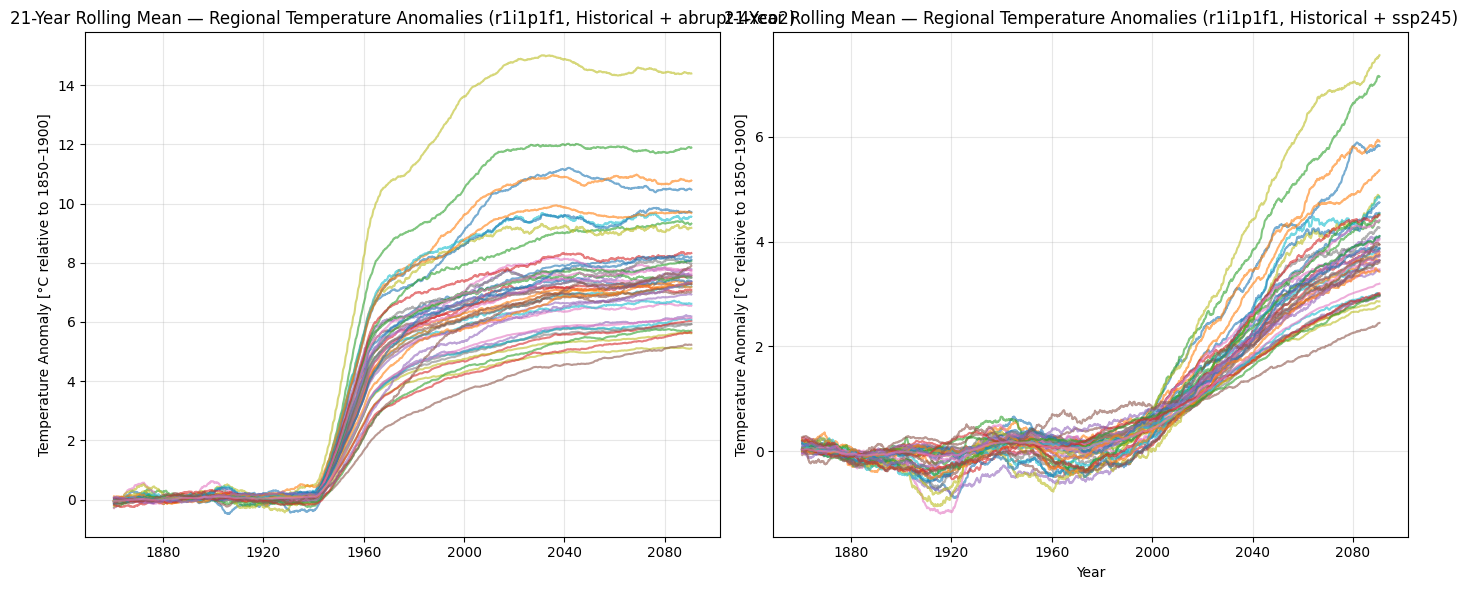

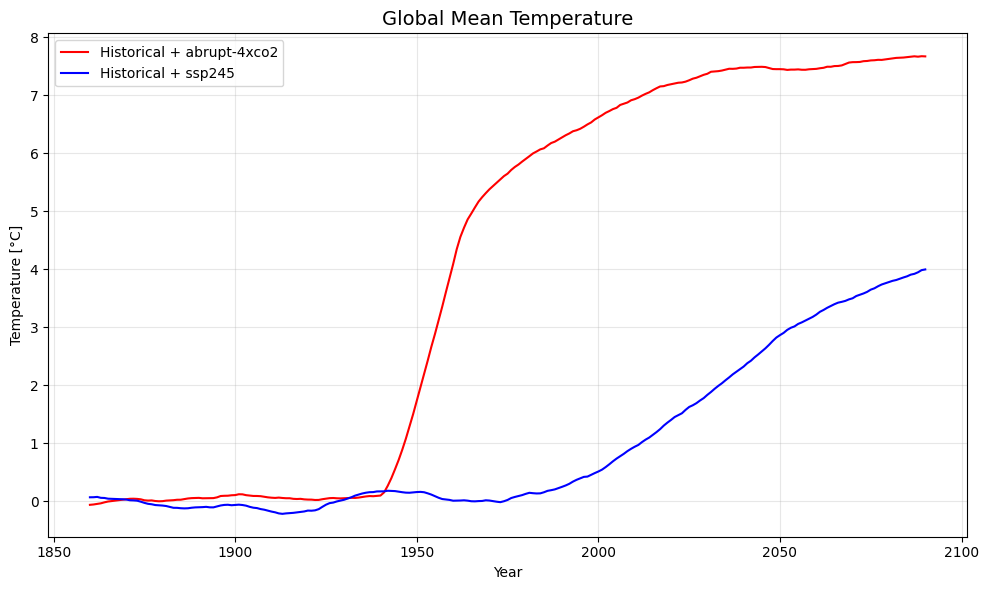

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan -6.03467526e-02 -5.43596280e-02
 -4.39176766e-02 -3.45443882e-02 -1.72840179e-02 -3.21689334e-03
  4.43209465e-03  1.07151998e-02  1.83115262e-02  2.71801364e-02
  3.53110098e-02  4.38482971e-02  4.50102680e-02  4.19270124e-02
  3.49002971e-02  1.80969783e-02  1.29823660e-02  1.56094097e-02
  5.36347727e-03  7.82139433e-04  3.07219953e-03  1.22156178e-02
  1.64462607e-02  1.96429991e-02  2.70399534e-02  2.77679858e-02
  3.79256510e-02  4.92815998e-02  5.51839694e-02  5.70919427e-02
  5.94965523e-02  5.24259346e-02  5.29874357e-02  5.45605918e-02
  5.54715388e-02  6.83418236e-02  9.16667277e-02  9.53860170e-02
  9.68202965e-02  1.04433488e-01  1.07499178e-01  1.21946437e-01
  1.20458903e-01  1.06177796e-01  9.88667054e-02  9.25111541e-02
  9.20661205e-02  8.86455693e-02  7.80653716e-02  6.86113555e-02
  6.23556550e-02  5.86156

In [10]:

MODEL = 'ACCESS-CM2'
INDICATOR = 'tas'
TRAIN_SCENARIO = 'abrupt-4xco2'
BASELINE_TRAIN = 'picontrol'
TEST_SCENARIO = 'ssp245'
BASELINE_TEST = 'historical'
TRAIN_ENSEMBLE = 'r1i1p1f1'
TEST_ENSEMBLE = 'r1i1p1f1'
ENSEMBLE = TRAIN_ENSEMBLE

train_scenario_path = f'/mnt/PROVIDE/SCALES/cmip6-ng/{MODEL}/{MODEL.lower()}_{TRAIN_SCENARIO}-{TRAIN_ENSEMBLE}_tas_ipcc-regions_latweight.csv'
train_baseline_path = f'/mnt/PROVIDE/SCALES/cmip6-ng/{MODEL}/{MODEL.lower()}_{BASELINE_TRAIN}-{TRAIN_ENSEMBLE}_tas_ipcc-regions_latweight.csv'

test_scenario_path = f'/mnt/PROVIDE/SCALES/cmip6-ng/{MODEL}/{MODEL.lower()}_{TEST_SCENARIO}-{TEST_ENSEMBLE}_tas_ipcc-regions_latweight.csv'
test_baseline_path = f'/mnt/PROVIDE/SCALES/cmip6-ng/{MODEL}/{MODEL.lower()}_{BASELINE_TEST}-{TEST_ENSEMBLE}_tas_ipcc-regions_latweight.csv'


def process_scenarios(experiment_scenario_path, simulation_name, baseline_scenario_path = None, delete_first_years = 0):
    """
    Load CMIP6 baseline (piControl) and abrupt4xco2 scenario data,
    compute anomalies relative to the baseline scenario,
    and return:
        (1) global anomaly timeseries (annual, 21-year rolling mean)
        (2) regional anomaly timeseries (monthly, 21-year rolling mean)
    """

    df_experiment = pd.read_csv(experiment_scenario_path, parse_dates=["time"])
    df_experiment['time'] = df_experiment['time'].astype(str)
    df_experiment['time'] = df_experiment['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))

    #if 'historical' in baseline_scenario_path:
    df_baseline = pd.read_csv(baseline_scenario_path, parse_dates=["time"])
    df_baseline['time'] = df_baseline['time'].astype(str)
    df_baseline['time'] = df_baseline['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))
    

    first_year_experiment = df_experiment['time'][0].year
    last_year_baseline = df_baseline['time'].iloc[-1].year
    year_shift = (first_year_experiment - 1)  - int(last_year_baseline)
    df_baseline.time = df_baseline.time.map(lambda dt: dt.replace(year=dt.year + year_shift))
    #df_baseline['time'] = pd.to_datetime(df_experiment['time'])
    
    df_experiment = pd.concat([df_baseline, df_experiment]).sort_values('time').reset_index(drop=True)

    if (df_experiment['time'].iloc[-1].year - df_experiment['time'][0].year) > 250: 
        delete_additional_years = (df_experiment['time'].iloc[-1].year - df_experiment['time'][0].year) - 250
        df_experiment = df_experiment[
            [dt.year >= min(dt.year for dt in df_experiment['time']) + delete_additional_years for dt in df_experiment['time']]
                ].reset_index(drop=True)

        # Shift remaining years so first year becomes start_year
        year_shift = 1850 -  df_experiment['time'][0].year
        df_experiment['time'] = df_experiment['time'].apply(lambda dt: dt.replace(year=dt.year + year_shift))

    #df_experiment['time'] = df_experiment['time'].apply(
    #lambda x: f'{str(int(x[0])+1)}{x[1:]}' if int(x[0:3]) < 1500 else x
    #)
    #df_experiment['time'] = pd.to_datetime(df_experiment['time'])

    first_year = df_experiment['time'][0].year
    year_shift = 1850 - int(first_year)
    df_experiment.time = df_experiment.time.map(lambda dt: dt.replace(year=dt.year + year_shift))
    df_experiment['time'] = pd.to_datetime(df_experiment['time'])
    
    
    region_cols = [col for col in df_experiment.columns if col.lower() != 'time']
    
    # calculate baseline
    #if 'historical' not in baseline_scenario_path:
    #    df_baseline = pd.read_csv(baseline_scenario_path, parse_dates=["time"])
    #    df_baseline = df_baseline.set_index("time")
    #    baseline_means = df_baseline[region_cols].mean()
    #else: 
    df_baseline = copy.deepcopy(df_experiment)
    df_baseline['time'] = df_baseline['time'].astype(str)
    df_baseline['time'] = df_baseline['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))
    #df_baseline['time'] = pd.to_datetime(df_baseline['time'])
    df_baseline = df_baseline[(df_baseline['time'].dt.year >= 1850) & (df_baseline['time'].dt.year <= 1900)]
    baseline_means = df_baseline[region_cols].mean()

    
    

    if delete_first_years != 0: 
        df_experiment = df_experiment[df_experiment['time'].dt.year >= df_experiment['time'].dt.year.min() + delete_first_years].reset_index(drop=True)
        # Shift remaining years so first year becomes start_year
        year_shift = 1850 - df_experiment['time'].dt.year.min()
        df_experiment['time'] = df_experiment['time'].apply(lambda dt: dt.replace(year=dt.year + year_shift))

    df_experiment = df_experiment.set_index("time")

    # (B) Compute regional anomalies and apply 21-year (252-month) rolling mean
    df_regional_anomaly = df_experiment[region_cols] - baseline_means
    #df_regional_smoothed = df_regional_anomaly
    df_regional_smoothed = df_regional_anomaly.rolling(window=21*12, center = True).mean()

    # (C) Compute global mean anomaly
    df_global = pd.DataFrame({
        'time': df_regional_smoothed.index,
        'GMT': df_regional_smoothed.mean(axis=1)
    }).set_index('time')

    # Convert monthly to annual mean
    df_global['year'] = df_global.index.astype(str).str[:4].astype(int)
    df_global_annual = df_global.groupby('year')['GMT'].mean().reset_index()
    #df_global_annual = df_global_annual.set_index("year")

    # Apply 21-year annual rolling mean
    #print(df_global_annual['GMT'])
    #df_global_annual['GMT'] = df_global_annual['GMT'].rolling(window=21, center = True).mean()

    # Add simulation name
    df_global_annual.insert(0, 'simulation_name', simulation_name)

    return df_global_annual, df_regional_smoothed


global_test_full, regional_test_roll = process_scenarios(test_scenario_path, f'{MODEL.lower()}_{TEST_SCENARIO}-{TEST_ENSEMBLE}_tas_ipcc-regions_latweight.csv', test_baseline_path)
global_train_full, regional_train_roll = process_scenarios(train_scenario_path, f'{MODEL.lower()}_{TRAIN_SCENARIO}-{TRAIN_ENSEMBLE}_tas_ipcc-regions_latweight.csv', train_baseline_path)

fig, ax = plt.subplots(1, 2, figsize=(14,6))


# Train scenario
for col in regional_train_roll.columns:

    ax[0].plot(regional_train_roll.index, regional_train_roll[col], alpha=0.6)
ax[0].set_title(f"21-Year Rolling Mean — Regional Temperature Anomalies ({TRAIN_ENSEMBLE}, Historical + {TRAIN_SCENARIO})")
ax[0].set_ylabel("Temperature Anomaly [°C relative to 1850–1900]")
ax[0].grid(True, alpha=0.3)

# Test scenario
for col in regional_train_roll.columns:
    ax[1].plot(regional_test_roll.index, regional_test_roll[col], alpha=0.6)
ax[1].set_title(f"21-Year Rolling Mean — Regional Temperature Anomalies ({TEST_ENSEMBLE}, Historical + {TEST_SCENARIO})")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Temperature Anomaly [°C relative to 1850–1900]")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 9. Plot global GMT (no rolling average, absolute values) ---
plt.figure(figsize=(10, 6))
plt.plot(global_train_full["year"], global_train_full["GMT"], label=f"Historical + {TRAIN_SCENARIO}", color="red")
plt.plot(global_test_full["year"], global_test_full["GMT"], label=f"Historical + {TEST_SCENARIO}", color="blue")

plt.title(f"Global Mean Temperature", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(global_train_full['GMT'].values)


Prepare Flat10MIP data 

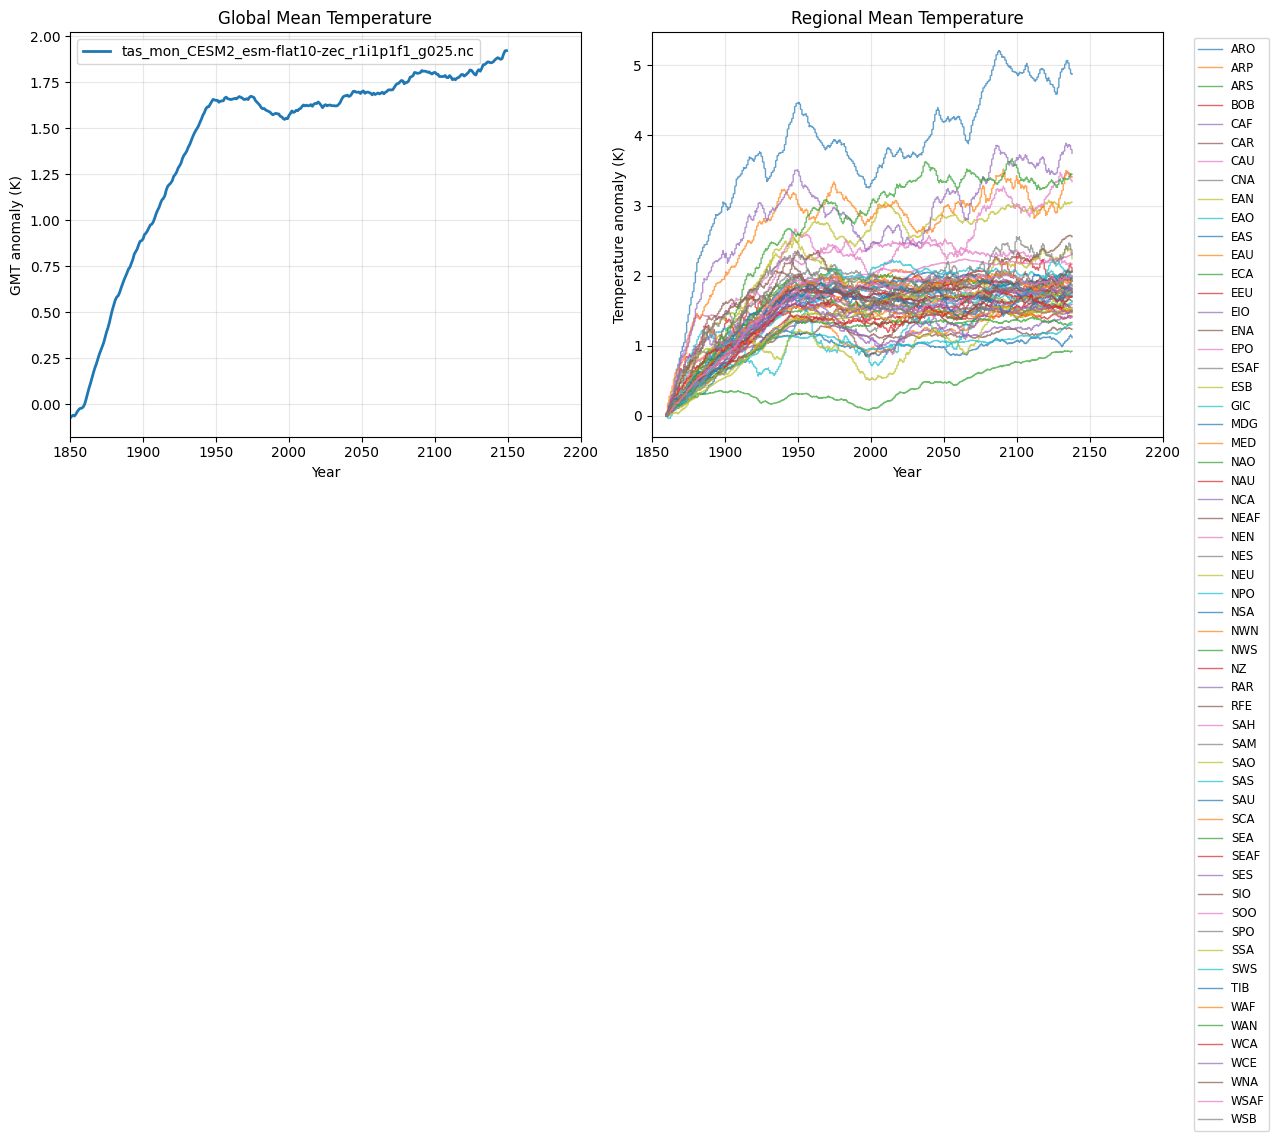

KeyboardInterrupt: 

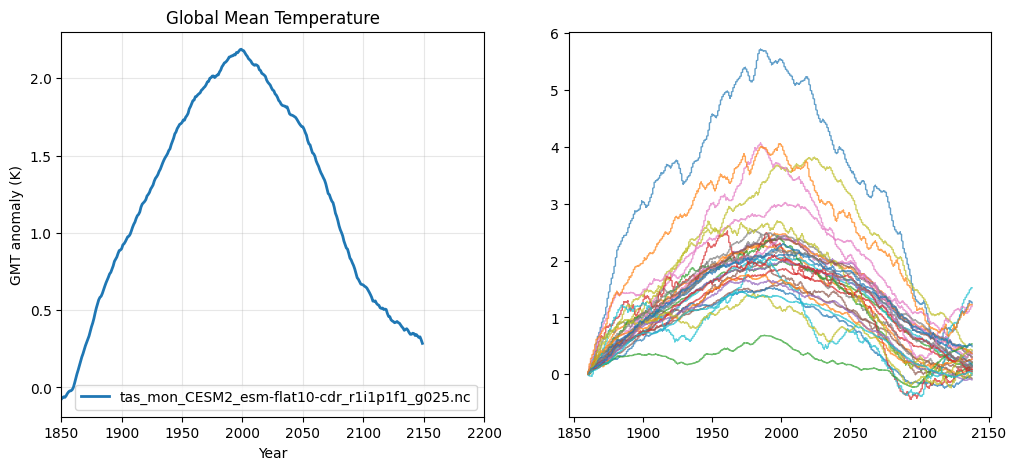

In [9]:
import xarray as xr
import scipy
import numpy as np
import pandas as pd

REGIONAL_DATA_PATH = '/mnt/PROVIDE/SCALES/tas_regional_yearly.csv'
flat10_regional_data = pd.read_csv(REGIONAL_DATA_PATH)

GLOBAL_DATA_PATH = '/mnt/PROVIDE/SCALES/tas_global_yearly.csv'
flat10_global_data = pd.read_csv(GLOBAL_DATA_PATH)


MODEL = "CESM2"
INDICATOR = 'tas'
REGIONS = 'AR6_GLOBAL'
TRAIN_SCENARIO = 'esm-flat10-zec'
TEST_SCENARIO = 'esm-flat10-cdr'
ENSEMBLE = 'r1i1p1f1'
START_TIME = 1850
END_TIME = 2100

def transform_to_timeseries_format(df, source, experiment_dd):
    """
    Transform the wide dataframe (years as columns, one row per region)
    into a long timeseries format suitable for model output.

    Parameters
    ----------
    df : pd.DataFrame
        The aligned flat dataframe (with year columns like 1850, 1851, ...).
    source : str
        The model source (e.g. "UKESM1-0-LL").
    experiment_dd : str
        The experiment name (e.g. "historical", "ssp370", "esm-flat10").

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        ["simulation_name", "time", <region_1>, <region_2>, ...].
    """

    # --- 1️⃣ Filter for the given source and experiment ---
    subset = df[(df["sourceDD"] == source) & (df["experiment_dd"] == experiment_dd)].copy()
    if subset.empty:
        raise ValueError(f"No data found for source='{source}' and experiment='{experiment_dd}'")

    # --- 2️⃣ Extract metadata and numeric year columns ---
    meta_cols = ["variable", "region", "experiment_dd", "sourceDD", "unit"]
    year_cols = [c for c in subset.columns if isinstance(c, (int, np.integer))]

    # --- 3️⃣ Build simulation name ---
    simulation_name = f"{subset['variable'].iloc[0]}_mon_{source}_{experiment_dd}_r1i1p1f1_g025.nc"

    # --- 4️⃣ Prepare time column (monthly midpoints) ---
    times = []
    for year in year_cols:
        # 12 monthly timestamps per year
        for month in range(1, 13):
            times.append(pd.Timestamp(year=year, month=month, day=16))

    # --- 5️⃣ Build output structure ---
    # Create a DataFrame with time + one column per region
    data = {"simulation_name": simulation_name, "time": times}

    # For each region, fill with yearly values repeated for 12 months
    for _, row in subset.iterrows():
        region = row["region"]
        values = row[year_cols].values

        # Repeat each yearly value 12 times to match monthly frequency
        monthly_values = np.repeat(values, 12)
        data[region] = monthly_values

    # --- 6️⃣ Construct final DataFrame ---
    result = pd.DataFrame(data)

    # --- 7️⃣ Optional: sort columns nicely ---
    col_order = ["simulation_name", "time"] + [r for r in subset["region"]]
    result = result[col_order]

    return result




import numpy as np
import pandas as pd

def align_flat10_to_1850_with_cdr(flat10_data, start_year=1850):
    """
    Align non-NaN values in each row so the first non-NaN aligns to `start_year`.
    If a row is a 'esm-flat10-cdr' or 'esm-flat10-zec' experiment,
    prepend the first 100 years of the matching 'esm-flat10' experiment
    (same sourceDD and region).
    """

    # Identify metadata and numeric year columns
    meta_cols = flat10_data.select_dtypes(exclude=[np.number]).columns.tolist()
    
    # Extract year columns — ensure numeric sorting
    year_cols = [c for c in flat10_data.columns if str(c).isdigit()]
    year_cols = sorted(year_cols, key=lambda x: int(x))

    # Build lookup for esm-flat10 rows
    lookup = {}
    for _, row in flat10_data.iterrows():
        key = (row["sourceDD"], row["region"], row["experiment_dd"])
        # Ensure year order before storing
        lookup[key] = row.copy()

    aligned_data = []

    for _, row in flat10_data.iterrows():
        exp = row["experiment_dd"]
        src = row["sourceDD"]
        reg = row["region"]

        # Extract numeric time series (sorted years)
        values = row[year_cols].to_numpy(dtype=float)
        valid_values = values[~np.isnan(values)]

        # --- Handle esm-flat10-cdr or esm-flat10-zec ---
        if exp in ["esm-flat10-cdr", "esm-flat10-zec"]:
            baseline_key = (src, reg, "esm-flat10")
            if baseline_key in lookup:
                baseline_row = lookup[baseline_key]
                baseline_vals = baseline_row[year_cols].to_numpy(dtype=float)
                baseline_valid = baseline_vals[~np.isnan(baseline_vals)]

                # Take first 100 years (or fewer if shorter)
                baseline_100 = baseline_valid[:100]

                # Prepend baseline
                valid_values = np.concatenate([baseline_100, valid_values])

            else:
                print(f"⚠️ No matching esm-flat10 found for {src} - {reg} ({exp}), skipping prepend.")

        # Skip if no valid data
        if len(valid_values) == 0:
            continue

        # Construct new year columns
        new_years = np.arange(start_year, start_year + len(valid_values))

        # Combine metadata and numeric data
        meta_part = row[meta_cols].to_dict()
        numeric_part = dict(zip(new_years, valid_values))
        aligned_data.append({**meta_part, **numeric_part})

    # Convert to DataFrame
    aligned_df = pd.DataFrame(aligned_data)

    # Sort columns (metadata first, then years)
    meta_cols_sorted = meta_cols
    year_cols_sorted = sorted(
        [c for c in aligned_df.columns if isinstance(c, (int, np.integer)) or str(c).isdigit()],
        key=lambda x: int(x)
    )
    aligned_df = aligned_df[meta_cols_sorted + year_cols_sorted]

    # Drop all-NaN year columns (in case of padding)
    aligned_df = aligned_df.loc[:, aligned_df.notna().any(axis=0)]

    return aligned_df
'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_flat10_experiments(
    data,
    experiments,
    regions,
    source=None,
    start_year=1850,
    end_year=2200,
    title=None,
    anomaly_ref_period=(1850, 1900),
    show_anomaly=False,
):
    """
    Plot selected experiments and regions from aligned flat10 dataframe.
    """

    plt.figure(figsize=(12, 6))

    # Detect numeric year columns (convert string names if needed)
    year_cols = [
        c for c in data.columns 
        if str(c).isdigit()
    ]
    # Convert to integers for sorting and indexing
    year_cols_int = np.array(list(map(int, year_cols)))

    for exp in experiments:
        for region in regions:
            subset = data[(data["experiment_dd"] == exp) & (data["region"] == region)]
            if source:
                subset = subset[subset["sourceDD"] == source]

            if subset.empty:
                print(f"⚠️ No data for {region} / {exp} / {source or 'all sources'}")
                continue

            # Extract and convert time series
      
            ts = subset[year_cols].mean(axis=0)
            ts.index = year_cols_int
            ts = ts[(ts.index >= start_year) & (ts.index <= end_year)]

            if ts.isna().all():
                print(f"⚠️ All-NaN for {region} / {exp} / {source or 'all sources'}")
                continue

            if show_anomaly:
                ref_mask = (ts.index >= anomaly_ref_period[0]) & (ts.index <= anomaly_ref_period[1])
                ref_mean = ts.loc[ref_mask].mean()
                ts = ts - ref_mean

          
            plt.plot(
                ts.index,
                ts.values,
                label=f"{region} – {exp}" + (f" ({source})" if source else ""),
                linewidth=2
            )

    plt.xlabel("Year")
    plt.ylabel("Temperature (K)" if not show_anomaly else "Temperature anomaly (K)")
    plt.title(title or f"Regional temperature for {', '.join(regions)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
'''

import matplotlib.pyplot as plt
import numpy as np
import random

def plot_flat10_experiments(
    data,
    experiments,
    regions,
    sources=None,
    start_year=1850,
    end_year=2200,
    title=None,
    anomaly_ref_period=(1850, 1900),
    show_anomaly=False,
):
    """
    Plot selected experiments and regions from aligned flat10 dataframe.

    Parameters
    ----------
    data : pd.DataFrame
        Aligned dataset (output of align_flat10_to_1850_with_cdr).
    experiments : list[str]
        List of experiment names, e.g. ["esm-flat10", "esm-flat10-cdr"].
    regions : list[str]
        List of regions, e.g. ["global", "land"].
    sources : str | list[str] | None
        Model sources to include (e.g. "CESM2" or ["CESM2", "GISS_E2.1"]).
        If None, includes all.
    start_year, end_year : int
        Range of years to plot.
    title : str | None
        Plot title.
    anomaly_ref_period : tuple[int, int]
        Reference period for anomaly calculation.
    show_anomaly : bool
        If True, plot temperature anomaly relative to reference period.
    """

    plt.figure(figsize=(12, 6))

    # Detect numeric year columns (convert string names if needed)
    year_cols = [c for c in data.columns if str(c).isdigit()]
    year_cols_int = np.array(list(map(int, year_cols)))

    # Normalize sources argument
    if sources is None:
        source_list = data["sourceDD"].unique()
    elif isinstance(sources, str):
        source_list = [sources]
    else:
        source_list = sources

    for exp in experiments:
        for region in regions:
            for src in source_list:
                subset = data[
                    (data["experiment_dd"] == exp)
                    & (data["region"] == region)
                    & (data["sourceDD"] == src)
                ]

                if subset.empty:
                    print(f"⚠️ No data for {region} / {exp} / {src}")
                    continue

                # Extract mean time series across matching rows
                ts = subset[year_cols].mean(axis=0)
                ts.index = year_cols_int
                ts = ts[(ts.index >= start_year) & (ts.index <= end_year)]

                if ts.isna().all():
                    print(f"⚠️ All-NaN for {region} / {exp} / {src}")
                    continue

                # Optional anomaly adjustment
                if show_anomaly:
                    ref_mask = (ts.index >= anomaly_ref_period[0]) & (ts.index <= anomaly_ref_period[1])
                    ref_mean = ts.loc[ref_mask].mean()
                    ts = ts - ref_mean

                plt.plot(
                    ts.index,
                    ts.values,
                    label=f"{region} – {exp} ({src})",
                    linewidth=2
                )

    plt.xlabel("Year")
    plt.ylabel("Temperature (K)" if not show_anomaly else "Temperature anomaly (K)")
    plt.title(title or f"Regional temperature for {', '.join(regions)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_regional_global_ratio_from_datasets(
    global_df,
    regional_df,
    experiments,
    regions,
    sources=None,
    start_year=1850,
    end_year=2200,
    title=None,
    anomaly_ref_period=(1850, 1900),
    show_anomaly=False,
):
    """
    Plot the ratio of regional to global temperature change (ΔT_reg / ΔT_global)
    using separate global and regional datasets.

    Parameters
    ----------
    global_df : pd.DataFrame
        DataFrame containing global data (region == 'global').
    regional_df : pd.DataFrame
        DataFrame containing regional data (all non-global regions).
    experiments : list[str]
        List of experiments, e.g. ["esm-flat10", "esm-flat10-cdr"].
    regions : list[str]
        List of region names to plot.
    sources : str | list[str] | None
        Model sources to include (e.g. "CESM2" or ["CESM2", "GISS_E2.1"]).
        If None, includes all sources available in both datasets.
    start_year, end_year : int
        Range of years to plot.
    title : str | None
        Plot title.
    anomaly_ref_period : tuple[int, int]
        Reference period for anomaly calculation (only used if show_anomaly=True).
    show_anomaly : bool
        If True, compute anomalies before ratio calculation.
    """

    plt.figure(figsize=(12, 6))

    # Detect numeric year columns
    year_cols = [c for c in global_df.columns if str(c).isdigit()]
    year_cols_int = np.array(list(map(int, year_cols)))

    # Normalize sources argument
    if sources is None:
        source_list = sorted(
            set(global_df["sourceDD"].unique()) & set(regional_df["sourceDD"].unique())
        )
    elif isinstance(sources, str):
        source_list = [sources]
    else:
        source_list = sources

    for exp in experiments:
        for src in source_list:
            # --- Get global baseline ---
            gsub = global_df[
                (global_df["experiment_dd"] == exp)
                & (global_df["sourceDD"] == src)
            ]
            if gsub.empty:
                print(f"⚠️ No global data for {exp} / {src}")
                continue

            gts = gsub[year_cols].mean(axis=0)
            gts.index = year_cols_int
            gts_ref = gts[(gts.index >= anomaly_ref_period[0]) & (gts.index <= anomaly_ref_period[1])]
            gts = gts[(gts.index >= start_year) & (gts.index <= end_year)]
            

            if gts.isna().all():
                print(f"⚠️ All-NaN global data for {exp} / {src}")
                continue

            if show_anomaly:
                ref_mask = (gts_ref.index >= anomaly_ref_period[0]) & (gts_ref.index <= anomaly_ref_period[1])
                gts = gts - gts_ref.loc[ref_mask].mean()

            # --- Loop through regions ---
            for region in regions:
                rsub = regional_df[
                    (regional_df["experiment_dd"] == exp)
                    & (regional_df["region"] == region)
                    & (regional_df["sourceDD"] == src)
                ]
                if rsub.empty:
                    print(f"⚠️ No regional data for {region} / {exp} / {src}")
                    continue

                rts = rsub[year_cols].mean(axis=0)
                rts.index = year_cols_int
                rts_ref = rts[(rts.index >= anomaly_ref_period[0]) & (rts.index <= anomaly_ref_period[1])]
                rts = rts[(rts.index >= start_year) & (rts.index <= end_year)]

                if rts.isna().all():
                    print(f"⚠️ All-NaN regional data for {region} / {exp} / {src}")
                    continue

                if show_anomaly:
                    ref_mask = (rts_ref.index >= anomaly_ref_period[0]) & (rts_ref.index <= anomaly_ref_period[1])
                    rts = rts - rts_ref.loc[ref_mask].mean()

                # --- Compute and plot ratio ---
                ratio = rts / gts
                plt.plot(
                    ratio.index,
                    ratio.values,
                    label=f"{region} / global – {exp} ({src})",
                    linewidth=2
                )

    plt.xlabel("Year")
    plt.ylabel("Regional / Global Warming Ratio (ΔT_reg / ΔT_global)")
    plt.title(title or "Regional-to-global warming ratio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
'''
def postprocess_global(df, baseline_years=(1850, 1870)):
    """
    Postprocess global monthly temperature data:
      - Convert to annual means
      - Subtract baseline (1850–1870)
      - Apply 21-year rolling average
    """
    df = df.copy()

    # Convert time to datetime and extract year
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df["year"] = df["time"].dt.year
    df = df.rename(columns={"global": "GMT"})

    # Compute annual mean per simulation
    annual = (
        df.groupby(["simulation_name", "year"], as_index=False)["GMT"]
        .mean()
        .sort_values(["simulation_name", "year"])
    )

    # Subtract baseline mean per simulation
    def subtract_baseline(x):
        baseline_mask = (x["year"] >= baseline_years[0]) & (x["year"] <= baseline_years[1])
        baseline_mean = x.loc[baseline_mask, "GMT"].mean()
        x["GMT"] = x["GMT"] - baseline_mean
        return x

    annual = annual.groupby("simulation_name", group_keys=False).apply(subtract_baseline)
    print(annual)
    # Apply 21-year centered rolling mean
    annual["GMT"] = (
        annual.groupby("simulation_name")["GMT"]
        .transform(lambda x: x.rolling(window=21, center=True).mean())
    )

    # Return clean output
    return annual[["simulation_name", "year", "GMT"]].reset_index(drop=True)
'''
def postprocess_global(df, baseline_years=(1850, 1870), smooth_window=21):
    """
    Postprocess global monthly temperature data:
      - Compute proper annual mean using resample
      - Subtract baseline (1850–1870)
      - Apply rolling mean
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.rename(columns={"global": "GMT"})

    all_sims = []
    for sim, group in df.groupby("simulation_name"):
        group = group.set_index("time").sort_index()

        # Compute annual mean properly
        annual = group["GMT"].resample("Y").mean().to_frame().reset_index()
        annual["year"] = annual["time"].dt.year
        annual["simulation_name"] = sim

        # Subtract baseline
        baseline_mask = (annual["year"] >= baseline_years[0]) & (annual["year"] <= baseline_years[1])
        baseline_mean = annual.loc[baseline_mask, "GMT"].mean()
        annual["GMT"] -= baseline_mean

        # Rolling mean
        annual["GMT"] = annual["GMT"].rolling(window=smooth_window, center=True, min_periods=smooth_window//2).mean()

        all_sims.append(annual[["simulation_name", "year", "GMT"]])

    out = pd.concat(all_sims, ignore_index=True)
    return out.sort_values(["simulation_name", "year"]).reset_index(drop=True)

def postprocess_regional(df, baseline_years=(1850, 1870)):
    """
    Postprocess regional monthly temperature data:
      - Converts 'time' to datetime (sets as index)
      - Removes 'simulation_name'
      - Subtracts baseline (1850–1870)
      - Applies 21-year centered rolling mean
    """
    df = df.copy()

    # Convert time column to datetime and set as index
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.set_index("time")

    # Drop simulation_name column if present
    if "simulation_name" in df.columns:
        df = df.drop(columns=["simulation_name"])

    # Compute baseline mean (1850–1870)
    baseline_mask = (df.index.year >= baseline_years[0]) & (df.index.year <= baseline_years[1])
    baseline_mean = df.loc[baseline_mask].mean()

    # Subtract baseline and apply rolling mean
    df_anom = df - baseline_mean
    df_smooth = df_anom.rolling(window=21 * 12, center=True).mean()

    return df_smooth

def plot_global_and_regional(df_global_list, df_regions, 
                             labels=None,
                             title_global="Global Mean Temperature",
                             title_regions="Regional Mean Temperature",
                             start_year=1850, end_year=2200):
    """
    Plot global mean temperature (GMT) and regional temperatures.
    
    Parameters
    ----------
    df_global_list : list of pd.DataFrame
        List of dataframes with columns ['simulation_name', 'year', 'GMT'].
    df_regions : pd.DataFrame
        DataFrame with datetime index and one column per region.
    labels : list of str, optional
        Labels for the global datasets (e.g. ["ZEC", "CDR", "ΔZEC-CDR"]).
    title_global : str
        Title for the GMT plot.
    title_regions : str
        Title for the regional temperature plot.
    start_year : int
        Start year for x-axis limits.
    end_year : int
        End year for x-axis limits.
    """
    plt.figure(figsize=(12, 5))
    
    # --- Plot Global Mean Temperature ---
    plt.subplot(1, 2, 1)
    for i, df in enumerate(df_global_list):
        label = labels[i] if labels and i < len(labels) else df["simulation_name"].iloc[0]
        plt.plot(df["year"], df["GMT"], lw=2, label=label)
    
    plt.title(title_global)
    plt.xlabel("Year")
    plt.ylabel("GMT anomaly (K)")
    plt.xlim(start_year, end_year)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # --- Plot Regional Temperatures ---
    plt.subplot(1, 2, 2)
    
    if isinstance(df_regions.index, pd.DatetimeIndex):
        years = df_regions.index.year
    else:
        raise ValueError("df_regions must have a DatetimeIndex")
    
    # Plot each region as a line
    for region in df_regions.columns:
        plt.plot(years, df_regions[region], lw=1, alpha=0.7, label=region)
    
    plt.title(title_regions)
    plt.xlabel("Year")
    plt.ylabel("Temperature anomaly (K)")
    plt.xlim(start_year, end_year)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Optionally, show a legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()





flat10_regional_aligned = align_flat10_to_1850_with_cdr(flat10_regional_data, start_year=1850)
flat10_regional_transformed_formal_train = transform_to_timeseries_format(flat10_regional_aligned, MODEL, TRAIN_SCENARIO)
flat10_regional_final_train = postprocess_regional(flat10_regional_transformed_formal_train)
flat10_regional_transformed_formal_test = transform_to_timeseries_format(flat10_regional_aligned, MODEL, TEST_SCENARIO)
flat10_regional_final_test = postprocess_regional(flat10_regional_transformed_formal_test)


flat10_global_aligned = align_flat10_to_1850_with_cdr(flat10_global_data, start_year=1850)
flat10_global_transformed_formal_train = transform_to_timeseries_format(flat10_global_aligned, MODEL, TRAIN_SCENARIO)
flat10_global_final_train = postprocess_global(flat10_global_transformed_formal_train)
flat10_global_transformed_formal_test = transform_to_timeseries_format(flat10_global_aligned,  MODEL, TEST_SCENARIO)
flat10_global_final_test = postprocess_global(flat10_global_transformed_formal_test)
#

#plot_flat10_experiments(
#    flat10_global_aligned,
#    experiments = ['esm-flat10-cdr'],
#    regions = ['global'],
#    sources=["CESM2", 'ACCESS-ESM1-5', 'GISS_E2.1'],
#    start_year=1850,
#    end_year=2200,
#    title=None,
#    anomaly_ref_period=(1850, 1870),
#    show_anomaly=True,
#    )
#for region in list(set(flat10_regional_aligned.region.to_list())):
#
#    plot_regional_global_ratio_from_datasets(
#        flat10_global_aligned,
#        flat10_regional_aligned,
#        experiments = ["esm-flat10-cdr", 'esm-flat10-zec', 'esm-flat10'],
#        regions = [region],
#        sources=["GISS_E2.1"],
#        start_year=1925,
#        end_year=2075,
#        title=None,
#        anomaly_ref_period=(1850, 1870),
#        show_anomaly=True,
#    )


#for region in list(set(flat10_regional_aligned.region.to_list())):
#    plot_flat10_experiments(
#        flat10_regional_aligned,
#        experiments = ['esm-flat10-cdr'],
#        regions = [region],
#        sources=["CESM2", 'ACCESS-ESM1-5', 'GISS_E2.1'],
#        start_year=1850,
#        end_year=2200,
#        title=None,
 #       anomaly_ref_period=(1850, 1870),
#        show_anomaly=True,
#    )




global_train_full = flat10_global_final_train
global_test_full = flat10_global_final_test
regional_train_roll = flat10_regional_final_train
regional_test_roll = flat10_regional_final_test


plot_global_and_regional([global_train_full], regional_train_roll)
plot_global_and_regional([global_test_full], regional_test_roll)

NameError: name 'ENSEMBLE' is not defined

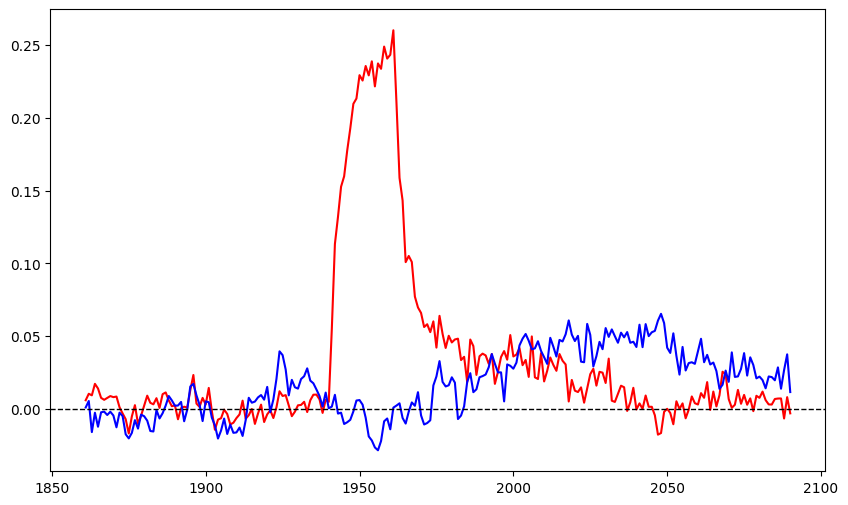

In [7]:
# --- Year-to-year differences in global mean temperature ---
global_train_full = global_train_full.sort_values("year")
global_test_full = global_test_full.sort_values("year")

# Compute year-to-year differences
global_train_full["dGMT"] = global_train_full["GMT"].diff()
global_test_full["dGMT"] = global_test_full["GMT"].diff()


try: 
    regional_train_roll = regional_train_roll.drop(columns=["Global"])
    regional_test_roll =  regional_test_roll.drop(columns=["Global"])
except: 
    pass

for region in regional_train_roll.columns:
    regional_train_roll[f'Delta {region}'] = regional_train_roll[region].diff()
    regional_test_roll[f'Delta {region}'] = regional_test_roll[region].diff()

# --- Plot ΔGMT for train and test ---
plt.figure(figsize=(10, 6))
plt.plot(global_train_full["year"], global_train_full["dGMT"], label=f"ΔGMT Historical + {TRAIN_SCENARIO}", color="red")
plt.plot(global_test_full["year"], global_test_full["dGMT"], label=f"ΔGMT Historical + {TEST_SCENARIO}", color="blue")

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title(f"Year-to-Year Change in Global Mean Temperature — {ENSEMBLE}", fontsize=14)
plt.xlabel("Year")
plt.ylabel("ΔGMT [°C per year]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


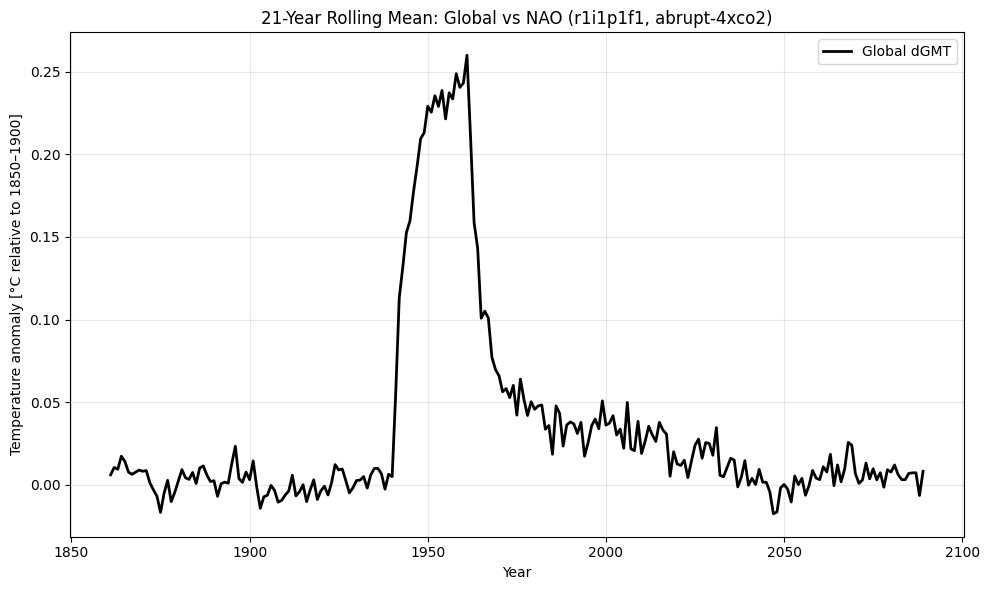

In [150]:

regional_train_roll = regional_train_roll.resample("Y").mean()



# --- 1. Define year range ---
start_year, end_year = START_TIME+11, END_TIME - 11

# --- 2. Trim regional rolling data ---
regional_train_roll_clean = regional_train_roll[
    (regional_train_roll.index.year >= start_year) &
    (regional_train_roll.index.year <= end_year)
].copy()
try: 
    regional_train_roll_clean.index = regional_train_roll_clean.index.year.astype(int)
except: 
    pass

# --- 3. Trim global data (already absolute, no rolling needed) ---
global_train_clean = global_train_full[
    (global_train_full["year"] >= start_year) &
    (global_train_full["year"] <= end_year)
].copy()

# --- 4. Plot example region vs global GMT ---
region_name = "NAO"  # pick any region column

plt.figure(figsize=(10, 6))
plt.plot(global_train_clean["year"], global_train_clean["dGMT"], label="Global dGMT", color="black", linewidth=2)
#plt.plot(regional_train_roll_clean.index, regional_train_roll_clean[region_name], label=f"{region_name} Regional (21y rolling)", color="orange")

plt.title(f"21-Year Rolling Mean: Global vs {region_name} ({ENSEMBLE}, {TRAIN_SCENARIO})")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly [°C relative to 1850–1900]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



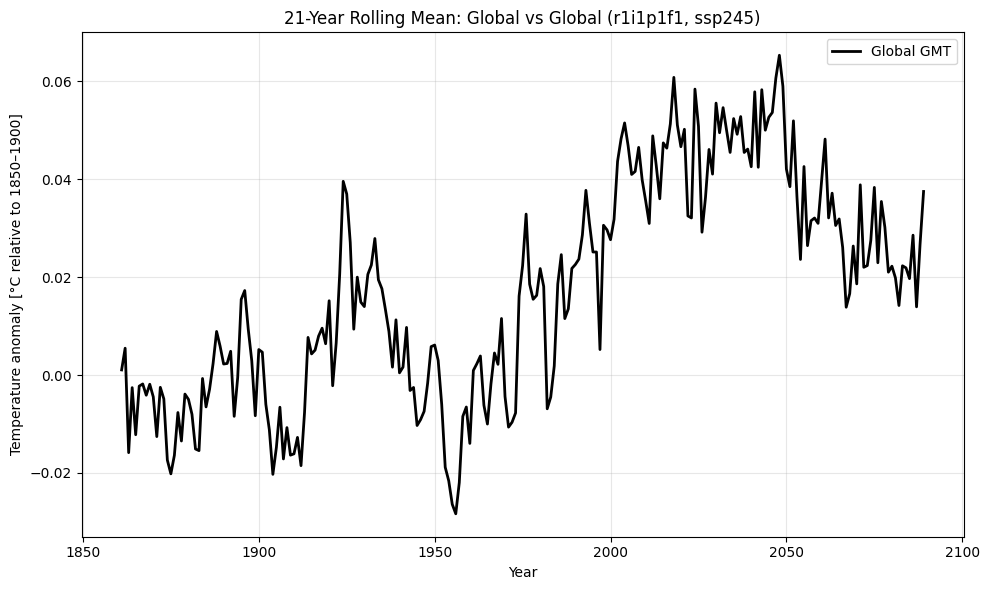

In [151]:
# --- 1. Resample regional test rolling data to yearly means ---
regional_test_roll = regional_test_roll.resample("Y").mean()

# --- 2. Define year range ---
start_year, end_year = START_TIME+11, END_TIME - 11

# --- 3. Trim regional test rolling data ---
regional_test_roll_clean = regional_test_roll[
    (regional_test_roll.index.year >= start_year) &
    (regional_test_roll.index.year <= end_year)
].copy()

# Convert to integer year index
try:
    regional_test_roll_clean.index = regional_test_roll_clean.index.year.astype(int)
except:
    pass



# --- 4. Trim global test data ---
global_test_clean = global_test_full[
    (global_test_full["year"] >= start_year) &
    (global_test_full["year"] <= end_year)
].copy()

# --- 5. Plot example region vs global GMT ---
region_name = "Global"  # or any regional column, e.g. "Greenland-Iceland"

plt.figure(figsize=(10, 6))
plt.plot(global_test_clean["year"], global_test_clean["dGMT"], label="Global GMT", color="black", linewidth=2)
#plt.plot(regional_test_roll_clean.index, regional_test_roll_clean[region_name], label=f"{region_name} Regional (21y rolling)", color="orange")

plt.title(f"21-Year Rolling Mean: Global vs {region_name} ({ENSEMBLE}, {TEST_SCENARIO})")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly [°C relative to 1850–1900]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Smoothing with localised linear regression: 

[1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874
 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888
 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902
 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916
 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028
 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042
 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056
 2057 

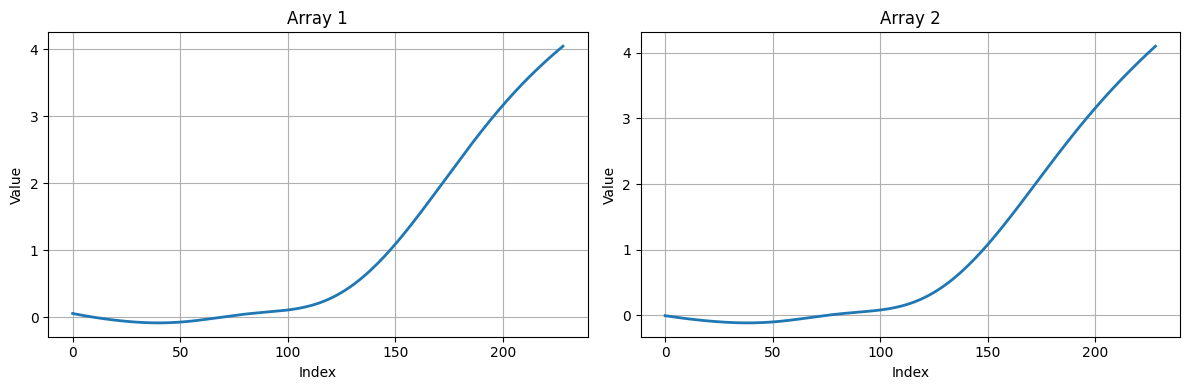

In [152]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt

def weights_calculate(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * (tau ** 2)))

def local_weighted_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]

    # weighted least squares
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y
    return x0 @ theta


def local_weighted_regression_slopes(x0, X, Y, tau):
    """
    Same weighted regression as `local_weighted_regression`,
    but returns only the slope coefficients (excluding intercept).
    """
    # Add bias term consistently (same as original function)
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]

    # Weighted least squares (same as original)
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y

    # Return only slopes (excluding intercept)
    return np.squeeze(theta[1:])

def make_dgmt_shift_matrix(global_train_clean):
    """
    Create an n×n NumPy matrix from global_train_clean['dGMT'].
    Each column is the dGMT series shifted down by one step more than the previous.
    Zeros fill the upper rows where data would be missing.
    """
    dGMT = global_train_clean["dGMT"].to_numpy()
    n = len(dGMT)
    
    M = np.zeros((n, n))
    for i in range(n):
        M[i:, i] = dGMT[: n - i]
    
    return M

# Example usage:
#local_weighted_regression(x0, YEAR, Y, 20)
#M_train = make_dgmt_shift_matrix(global_train_clean)
offsets = [i for i in range(0,-len(global_train_clean.year.to_numpy()),-1)]
M_train_smooth = np.array([local_weighted_regression(x0, global_train_clean.year.to_numpy(), global_train_clean["dGMT"].to_numpy(), 20) for x0 in global_train_clean.year])
M_train_smooth_matrix = diags(M_train_smooth,offsets=offsets,shape=(len(global_train_clean.year.to_numpy()),len(global_train_clean.year.to_numpy())),format='csr')

offsets_pattern_scaling = [i for i in range(0,-len(global_train_clean.year.to_numpy()),-1)]
train_smooth_pattern_scaling = np.array([local_weighted_regression(x0, global_train_clean.year.to_numpy(), global_train_clean["GMT"].to_numpy(), 20) for x0 in global_train_clean.year])
print(global_train_clean.year.to_numpy())
print(global_train_clean["GMT"].to_numpy())
offsets = [i for i in range(0,-len(global_test_clean.year.to_numpy()),-1)]
M_test_smooth = np.array([local_weighted_regression(x0, global_test_clean.year.to_numpy(), global_test_clean["dGMT"].to_numpy(), 20) for x0 in global_test_clean.year])
M_test_smooth_matrix = diags(M_test_smooth,offsets=offsets,shape=(len(global_test_clean.year.to_numpy()),len(global_test_clean.year.to_numpy())),format='csr')

offsets_pattern_scaling = [i for i in range(0,-len(global_test_clean.year.to_numpy()),-1)]
test_smooth_pattern_scaling = np.array([local_weighted_regression(x0, global_test_clean.year.to_numpy(), global_test_clean["GMT"].to_numpy(), 20) for x0 in global_test_clean.year])

regional_train_roll_clean_for_b = regional_train_roll_clean.drop(columns=[col for col in regional_train_roll_clean.columns if "Delta" in col])
b = regional_train_roll_clean_for_b.to_numpy()
b_smooth_train = np.array([local_weighted_regression(x0, global_train_clean.year.to_numpy(), b, 20) for x0 in global_train_clean.year])


regional_test_roll_clean_for_b = regional_test_roll_clean.drop(columns=[col for col in regional_test_roll_clean.columns if "Delta" in col])
b_test = regional_test_roll_clean_for_b.to_numpy()
b_smooth_test = np.array([local_weighted_regression(x0, global_test_clean.year.to_numpy(), b_test, 20) for x0 in global_test_clean.year])

regional_train_roll_clean_for_b_1st_derivative = regional_train_roll_clean.drop(columns=[col for col in regional_train_roll_clean.columns if "Delta" in col])
b_1st_derivative = regional_train_roll_clean_for_b_1st_derivative.to_numpy()
b_smooth_train_1st_derivative = np.array([local_weighted_regression_slopes(x0, global_train_clean.year.to_numpy(), b_1st_derivative, 20) for x0 in global_train_clean.year])


regional_test_roll_clean_for_b_1st_derivative = regional_test_roll_clean.drop(columns=[col for col in regional_test_roll_clean.columns if "Delta" in col])
b_test_1st_derivative = regional_test_roll_clean_for_b_1st_derivative.to_numpy()
b_smooth_test_1st_derivative = np.array([local_weighted_regression_slopes(x0, global_test_clean.year.to_numpy(), b_test_1st_derivative, 20) for x0 in global_test_clean.year])

GMT_1st_derivative_train = np.array([local_weighted_regression_slopes(x0, global_train_clean.year.to_numpy(), global_train_clean["GMT"].to_numpy(), 20) for x0 in global_train_clean.year])
GMT_1st_derivative_test = np.array([local_weighted_regression_slopes(x0, global_test_clean.year.to_numpy(), global_test_clean["GMT"].to_numpy(), 20) for x0 in global_test_clean.year])

#print(global_train_clean.GMT.values)
#print(GMT_1st_derivative_train)


def plot_side_by_side(arr1, arr2, title1="Array 1", title2="Array 2"):
    """
    Plots two (229,) arrays side by side.

    Parameters:
        arr1, arr2: arrays of shape (229,)
        title1, title2: titles for the plots
    """
    x = np.arange(len(arr1))

    plt.figure(figsize=(12, 4))

    # First plot
    plt.subplot(1, 2, 1)
    plt.plot(x, arr1, linewidth=2)
    plt.title(title1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)

    # Second plot
    plt.subplot(1, 2, 2)
    plt.plot(x, arr2, linewidth=2)
    plt.title(title2)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_side_by_side(test_smooth_pattern_scaling, np.cumsum(GMT_1st_derivative_test))

Fit pattern scaling

In [153]:
import numpy as np
from sklearn.linear_model import LinearRegression

def predict_regional_temperatures(global_test_series, slopes, intercepts):
    """
    Uses stored regression parameters to predict regional temps.
    Returns:
        predictions: array of shape (len(global_test_series), n_regions)
    """
    global_test_series = np.asarray(global_test_series).reshape(-1, 1)
    predictions = global_test_series * slopes + intercepts
    return predictions

def fit_regional_regressions(global_series, regional_series):
    """
    Fits one linear regression per region: region = a + b * global
    Returns:
        slopes:   (46,) array of regression coefficients
        intercepts: (46,) array of intercepts
    """
    global_series = np.asarray(global_series).reshape(-1, 1)
    regional_series = np.asarray(regional_series)
    
    n_regions = regional_series.shape[1]
    slopes = np.zeros(n_regions)
    intercepts = np.zeros(n_regions)

    for i in range(n_regions):
        model = LinearRegression()
        model.fit(global_series, regional_series[:, i])
        slopes[i] = model.coef_[0]
        intercepts[i] = model.intercept_

    return slopes, intercepts


print(train_smooth_pattern_scaling)
print(train_smooth_pattern_scaling.shape)
print(b_smooth_train)
print(b_smooth_train.shape)

slopes, intercepts = fit_regional_regressions(train_smooth_pattern_scaling, b_smooth_train)



[-1.49003437e-02 -1.22660648e-02 -9.66945825e-03 -7.10978947e-03
 -4.58648249e-03 -2.09910207e-03  3.52665412e-04  2.76903531e-03
  5.15015876e-03  7.49615489e-03  9.80715214e-03  1.20833329e-02
  1.43249880e-02  1.65325730e-02  1.87067724e-02  2.08485717e-02
  2.29593331e-02  2.50408818e-02  2.70955947e-02  2.91265001e-02
  3.11373811e-02  3.31328872e-02  3.51186522e-02  3.71014185e-02
  3.90891673e-02  4.10912551e-02  4.31185558e-02  4.51836064e-02
  4.73007593e-02  4.94863364e-02  5.17587877e-02  5.41388512e-02
  5.66497141e-02  5.93171752e-02  6.21698041e-02  6.52391007e-02
  6.85596479e-02  7.21692606e-02  7.61091265e-02  8.04239369e-02
  8.51620064e-02  9.03753773e-02  9.61199077e-02  1.02455340e-01
  1.09445346e-01  1.17157545e-01  1.25663498e-01  1.35038660e-01
  1.45362308e-01  1.56717417e-01  1.69190508e-01  1.82871435e-01
  1.97853141e-01  2.14231346e-01  2.32104199e-01  2.51571864e-01
  2.72736057e-01  2.95699530e-01  3.20565501e-01  3.47437029e-01
  3.76416343e-01  4.07604

In [154]:
import numpy as np
from scipy.optimize import curve_fit

def response_function(t, a1, a2, a3, b1, b2, b3):
    """Three-timescale exponential response model."""
    return (
        a1 * (1 - np.exp(-t / b1)) +
        a2 * (1 - np.exp(-t / b2)) +
        a3 * (1 - np.exp(-t / b3))
    )

def fit_parameters(global_forcing, regional_temp, t):
    """
    Fits a_i > 0 and b_i per region to model regional temperature anomalies.
    
    Parameters:
        global_forcing: 1D array of shape (d,)
        regional_temp: 2D array of shape (d, r)
        t: 1D array of time points, shape (d,)
    
    Returns:
        params: dict with keys:
            'a': array shape (r, 3)
            'b': array shape (r, 3)
            'full_params': array shape (r, 6)
            't': original time vector (needed for prediction)
    """
    d, r = regional_temp.shape
    assert len(global_forcing) == d
    assert len(t) == d
    
    params_a = np.zeros((r, 3))
    params_b = np.zeros((r, 3))
    full_params = np.zeros((r, 6))
    
    for region in range(r):
        # Infer response per unit forcing
        y = regional_temp[:, region] / global_forcing
        
        # Initial parameter guess
        p0 = [0.5, 0.5, 0.5, 5, 50, 500]
        
        # Parameter constraints
        lower_bounds = [0,     0,     0,     1,   10,   100]
        upper_bounds = [np.inf, np.inf, np.inf, 10, 100, 1000]
        
        popt, _ = curve_fit(
            response_function,
            t,
            y,
            p0=p0,
            bounds=(lower_bounds, upper_bounds),
            maxfev=20000
        )
        
        params_a[region] = popt[:3]
        params_b[region] = popt[3:]
        full_params[region] = popt
    
    return {'a': params_a, 'b': params_b, 'full_params': full_params, 't': t}


def predict_temperatures(new_global_forcing, t_new, params):
    """
    Predicts regional temperatures for new time series of global forcing.
    
    Parameters:
        new_global_forcing: 1D array of shape (d_new,)
        t_new: 1D array of shape (d_new,) (time vector)
        params: fitted parameter dictionary returned by fit_parameters()
    
    Returns:
        regional_pred: 2D array of shape (d_new, r)
    """
    a = params['a']       # shape (r, 3)
    b = params['b']       # shape (r, 3)
    
    r = a.shape[0]  # number of regions
    d_new = len(t_new)
    
    regional_pred = np.zeros((d_new, r))
    
    # For each region, apply the response function
    for region in range(r):
        response = (
            a[region, 0] * (1 - np.exp(-t_new / b[region, 0])) +
            a[region, 1] * (1 - np.exp(-t_new / b[region, 1])) +
            a[region, 2] * (1 - np.exp(-t_new / b[region, 2]))
        )
        
        regional_pred[:, region] = response * new_global_forcing
    
    return regional_pred


params = fit_parameters(GMT_1st_derivative_train, b_smooth_train, np.arange(GMT_1st_derivative_train.shape[0]))
regional_pred_modal_fitting = predict_temperatures(GMT_1st_derivative_test, np.arange(GMT_1st_derivative_test.shape[0]), params)

print(regional_pred_modal_fitting)


[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-2.78503663e-02 -2.83207744e-02 -3.11605956e-02 ... -1.78241888e-02
  -1.89597636e-02 -1.56205592e-02]
 [-5.47194063e-02 -5.56436475e-02 -6.12232268e-02 ... -3.50203303e-02
  -3.72514674e-02 -3.06907175e-02]
 ...
 [ 3.52140275e+01  3.58088123e+01  3.93994846e+01 ...  2.25369157e+01
   2.39727421e+01  1.97506370e+01]
 [ 3.50973784e+01  3.56901929e+01  3.92689709e+01 ...  2.24622604e+01
   2.38933305e+01  1.96852114e+01]
 [ 3.49850509e+01  3.55759682e+01  3.91432924e+01 ...  2.23903710e+01
   2.38168611e+01  1.96222098e+01]]


Simple Gaussian Process regression:

In [60]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def fit_gpr_for_regions(x, Y, kernel=None, alpha=1e-4, random_state=42):
    """
    Fit a Gaussian Process Regression model for each region (column) in Y.

    Args:
        x : np.ndarray of shape (N,)
            Predictor variable (e.g. global mean temperature or scaling factor).
        Y : np.ndarray of shape (N, M)
            Target matrix — each column is a region to predict.
        kernel : sklearn.gaussian_process.kernels.Kernel, optional
            Custom kernel. If None, a default RBF kernel is used.
        alpha : float
            Noise level for the GPR (regularization term).
        random_state : int
            Random seed for reproducibility.

    Returns:
        models : list
            List of fitted GaussianProcessRegressor objects, one per region.
        y_pred : np.ndarray of shape (N, M)
            Predicted values from the fitted models (in-sample fit).
    """
    x = np.asarray(x).reshape(-1, 1)
    N, M = Y.shape

    if kernel is None:
        kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=10.0, length_scale_bounds=(1e-2, 1e3))

    models = []
    y_pred = np.zeros_like(Y)

    for i in range(M):
        y = Y[:, i]
        mask = np.isfinite(y)  # Handle NaNs
        
        if mask.sum() < 5:
            # Not enough data to fit
            models.append(None)
            y_pred[:, i] = np.nan
            continue

        gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, random_state=random_state)
        gpr.fit(x[mask], y[mask])
        
        y_pred[:, i] = gpr.predict(x)
        models.append(gpr)

    return models, y_pred

def predict_gpr_for_regions(models, x_new):
    """
    Predict for new input x_new for each fitted GPR model.
    """
    x_new = np.asarray(x_new).reshape(-1, 1)
    preds = []
    for model in models:
        if model is not None:
            preds.append(model.predict(x_new))
        else:
            preds.append(np.full(x_new.shape[0], np.nan))
    return np.column_stack(preds)

models_gaussian_processes, b_pred_train_gaussian_processes = fit_gpr_for_regions(train_smooth_pattern_scaling, b_smooth_train)
print(b_pred_train_gaussian_processes.shape)  

b_pred_gaussian_processes = predict_gpr_for_regions(models_gaussian_processes, test_smooth_pattern_scaling)
print(b_pred_gaussian_processes)





/home/niklas/.conda/envs/downscaling/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/niklas/.conda/envs/downscaling/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/niklas/.conda/envs/downscaling/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better

(229, 46)
[[ 1.91114786e-03 -7.68692700e-02 -6.34099872e-02 ...  1.04653393e-01
   2.04250009e-01  2.56060333e-01]
 [-3.99468658e-03 -8.28656438e-02 -6.80174861e-02 ... -4.19691750e-02
   2.81048507e-02  2.49068262e-01]
 [-9.82953474e-03 -8.87885613e-02 -7.25311063e-02 ...  3.76340989e-02
   1.08212025e-01  2.42105115e-01]
 ...
 [ 6.82543295e+00  7.50240159e+00  8.19002511e+00 ...  3.17877306e+00
   4.03744342e+00  5.23363229e+00]
 [ 6.87592596e+00  7.56170846e+00  8.25271721e+00 ...  1.18493867e+00
   1.55134805e+00  5.27253174e+00]
 [ 6.92584615e+00  7.62036226e+00  8.31475880e+00 ...  1.97737678e+00
   2.53728653e+00  5.31104123e+00]]


/home/niklas/.conda/envs/downscaling/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/niklas/.conda/envs/downscaling/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Operator learning with gaussian processes (Questionable ChatGPT version):

Next trys: 
- Zerstückelung (e.g. predict 10 years of reg temp from 20 years of GMT)
- more predictors from magicc (e.g. aerosoles)
- operator learning 

In [61]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
import itertools

def fit_operator_learning_gp(u, Y, region_list, kernel=None, alpha=1e-4, random_state=0):
    """
    Fit a GP mapping (pattern_scaling, region_id) → regional values Y.

    Args:
      u : np.ndarray, shape (N,)
        The input function (pattern scaling over time).
      Y : np.ndarray, shape (N, M)
        The outputs: values for each region over time.
      region_list : list of str or identifiers, length M
        The region identities.
      kernel : sklearn kernel, optional
      alpha : float
      random_state : int

    Returns:
      model : fitted GaussianProcessRegressor
      X_full : np.ndarray, shape (N*M, 2) — inputs used
      y_full : np.ndarray, shape (N*M,) — targets used
      y_pred_full : np.ndarray, shape (N, M) — predictions
    """

    N, M = Y.shape

    # Build inputs: pair each time with each region
    # region dimension: encode region_list as integer or categorical
    # For simplicity, map region index j → integer j
    region_idx = np.arange(M)

    # Repeat u for each region
    u_rep = np.repeat(u, M)  
    reg_rep = np.tile(region_idx, N)  

    # Flatten Y
    y_full = Y.reshape(-1)  # shape (N*M,)

    # Mask out nan
    mask = np.isfinite(y_full) & np.isfinite(u_rep)
    X_full = np.vstack([u_rep[mask], reg_rep[mask]]).T  # shape (~K,2)
    y_obs = y_full[mask]

    # Define kernel if not given
    if kernel is None:
        # Kernel = kernel over u * kernel over region
        k_u = RBF(length_scale=1.0, length_scale_bounds=(1e-2,1e2))
        # For region ID, you might use e.g. RBF if region indices meaningful, or an “IndexKernel”
        k_r = RBF(length_scale=1.0, length_scale_bounds=(1e-2, M))
        kernel = C(1.0, (1e-3,1e3)) * (k_u * k_r)

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, random_state=random_state)

    gpr.fit(X_full, y_obs)

    # Predict back for all (u, region_idx)
    X_pred = np.vstack([np.repeat(u, M), np.tile(region_idx, N)]).T
    y_pred_flat = gpr.predict(X_pred)
    y_pred = y_pred_flat.reshape(N, M)

    return gpr, y_pred

def predict_operator_learning_gp(model, u_test, region_list):
    """
    Predict regional outputs for a new pattern scaling input trajectory
    using a fitted operator-learning GP model.

    Args:
        model : fitted GaussianProcessRegressor
        u_test : np.ndarray, shape (N_test,)
            New pattern scaling trajectory (e.g., test data).
        region_list : list[str]
            Region names in same order as training.
        region_encoding : dict[str, int]
            Region name → numeric encoding mapping.

    Returns:
        Y_pred : np.ndarray, shape (N_test, M)
            Predicted regional temperature anomalies.
    """
    region_encoding = {r:i for i,r in enumerate(region_list)}
    N_test = len(u_test)
    M = len(region_list)

    # Build input combinations
    region_idx = np.array([region_encoding[r] for r in region_list])
    X_pred = np.vstack([np.repeat(u_test, M), np.tile(region_idx, N_test)]).T

    # Predict with GP
    y_pred_flat = model.predict(X_pred)
    Y_pred = y_pred_flat.reshape(N_test, M)

    return Y_pred


# Fit GP operator model
gp_operator, y_pred = fit_operator_learning_gp(
    train_smooth_pattern_scaling, b_smooth_train, region_list=regional_train_roll_clean_for_b.columns
)

# Predict for test pattern scaling trajectory
b_pred_operator_gp = predict_operator_learning_gp(
    gp_operator, test_smooth_pattern_scaling, regional_train_roll_clean_for_b.columns
)

print(b_pred_operator_gp)

[[ 1.24300456e-02 -7.02174456e-02 -6.62147901e-02 ...  2.04873875e-01
   3.09284382e-01  2.56380781e-01]
 [ 6.24243107e-03 -7.63890922e-02 -7.06630187e-02 ...  2.00268222e-01
   3.02355743e-01  2.49330185e-01]
 [ 1.03734328e-04 -8.25019678e-02 -7.50170011e-02 ...  1.95740720e-01
   2.95507774e-01  2.42311176e-01]
 ...
 [ 6.82638961e+00  7.50546831e+00  8.19346778e+00 ...  3.36177638e+00
   4.26704672e+00  5.23840431e+00]
 [ 6.87670912e+00  7.56423258e+00  8.25649376e+00 ...  3.38563382e+00
   4.29435744e+00  5.27761706e+00]
 [ 6.92644132e+00  7.62234138e+00  8.31880609e+00 ...  3.40924713e+00
   4.32140003e+00  5.31634435e+00]]


Fit IRF

In [155]:
from scipy.sparse.linalg import spsolve_triangular

x = spsolve_triangular(M_train_smooth_matrix, b_smooth_train,lower=True, overwrite_A=False, overwrite_b=False)


print(x)

[[ 2.70596137e+01 -8.50571412e+00  3.63243446e+00 ... -4.53797235e-02
  -2.64354098e+00 -4.39713813e+00]
 [ 6.43869979e-01 -2.58798354e-02  1.58731397e+00 ... -3.91897011e-01
   7.09368002e-01  1.94020349e-01]
 [ 5.74380368e-01 -1.35537377e-04  1.53863976e+00 ... -3.67202344e-01
   7.11951089e-01  2.08587378e-01]
 ...
 [ 1.87562400e+04  1.04841630e+04  1.10356661e+04 ...  2.47191420e+03
   4.08777941e+03  2.83727763e+03]
 [ 2.01823763e+04  9.99637298e+03  1.14483848e+04 ...  2.16985283e+03
   4.24389975e+03  2.54552245e+03]
 [ 2.16523261e+04  9.41710240e+03  1.18484054e+04 ...  1.82937630e+03
   4.39559901e+03  2.21460236e+03]]


(229, 47)


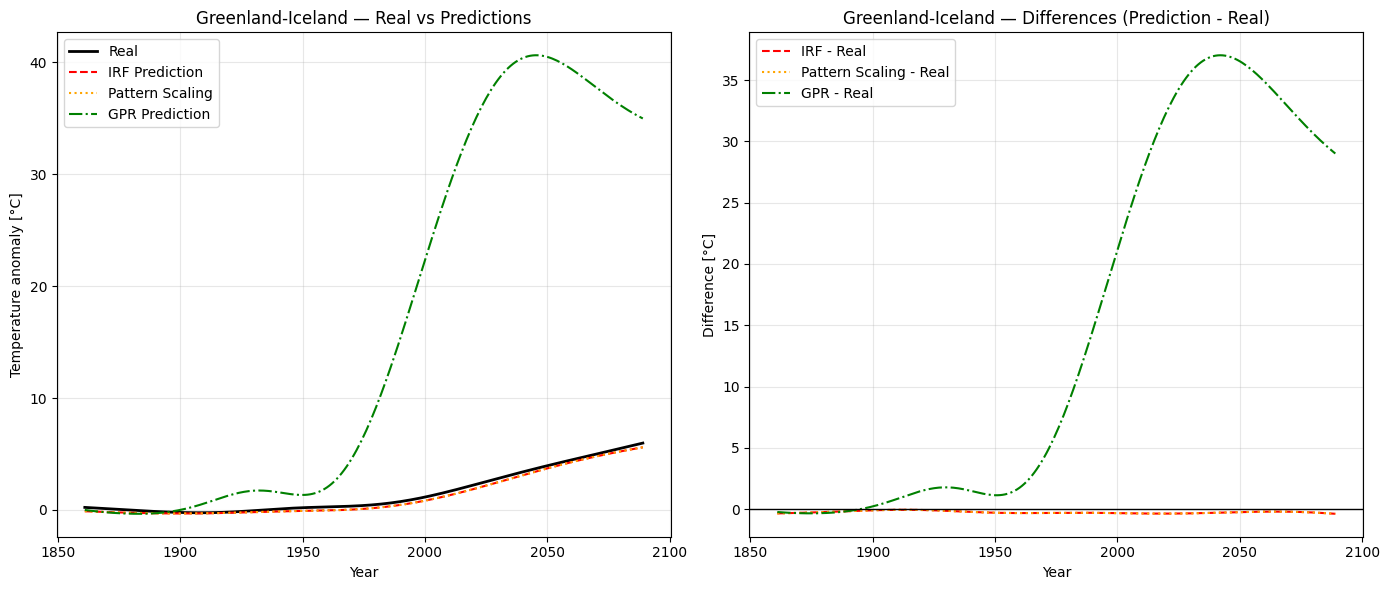

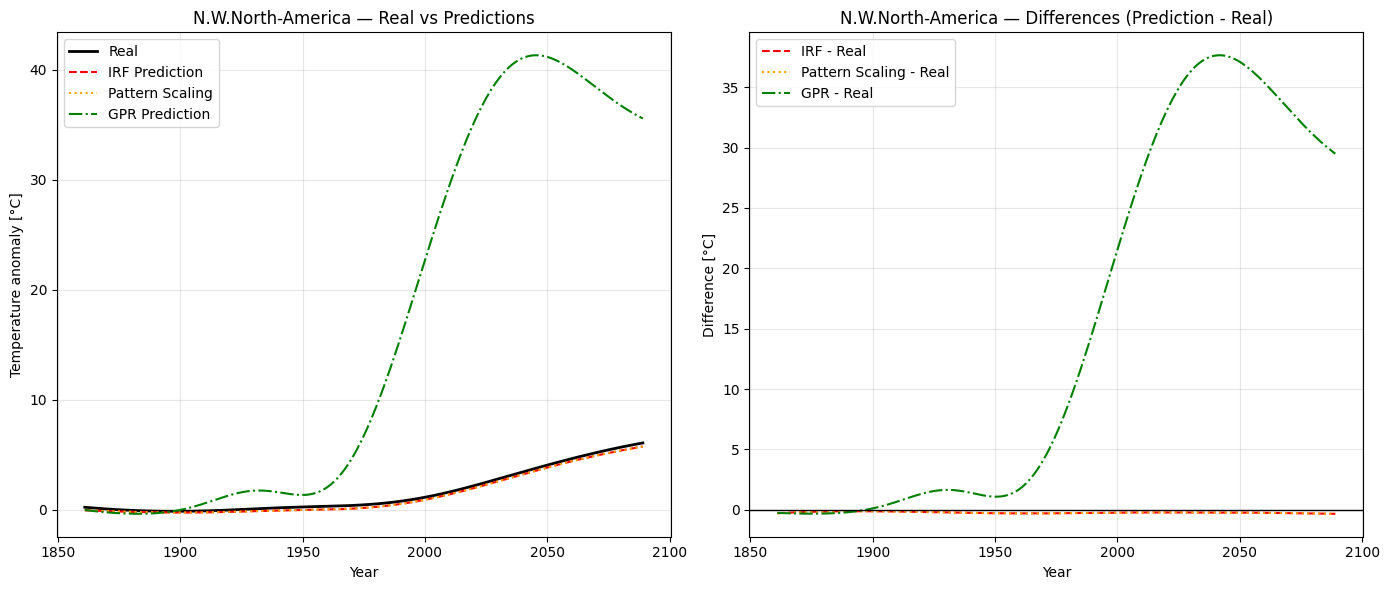

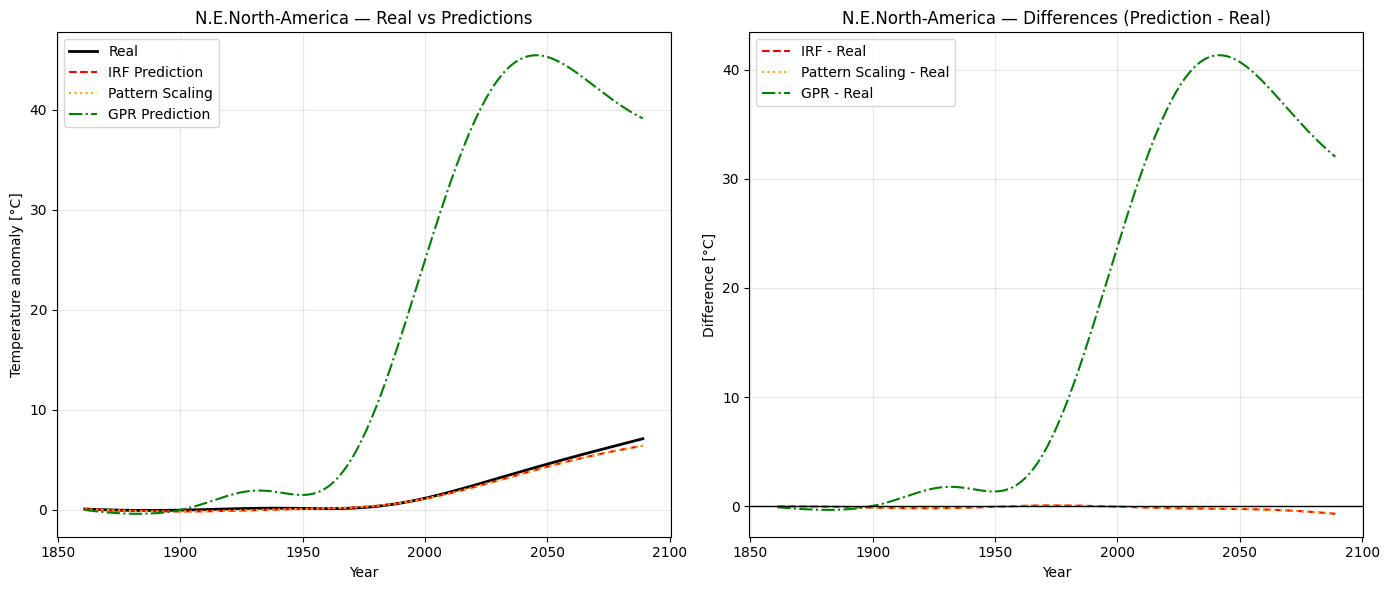

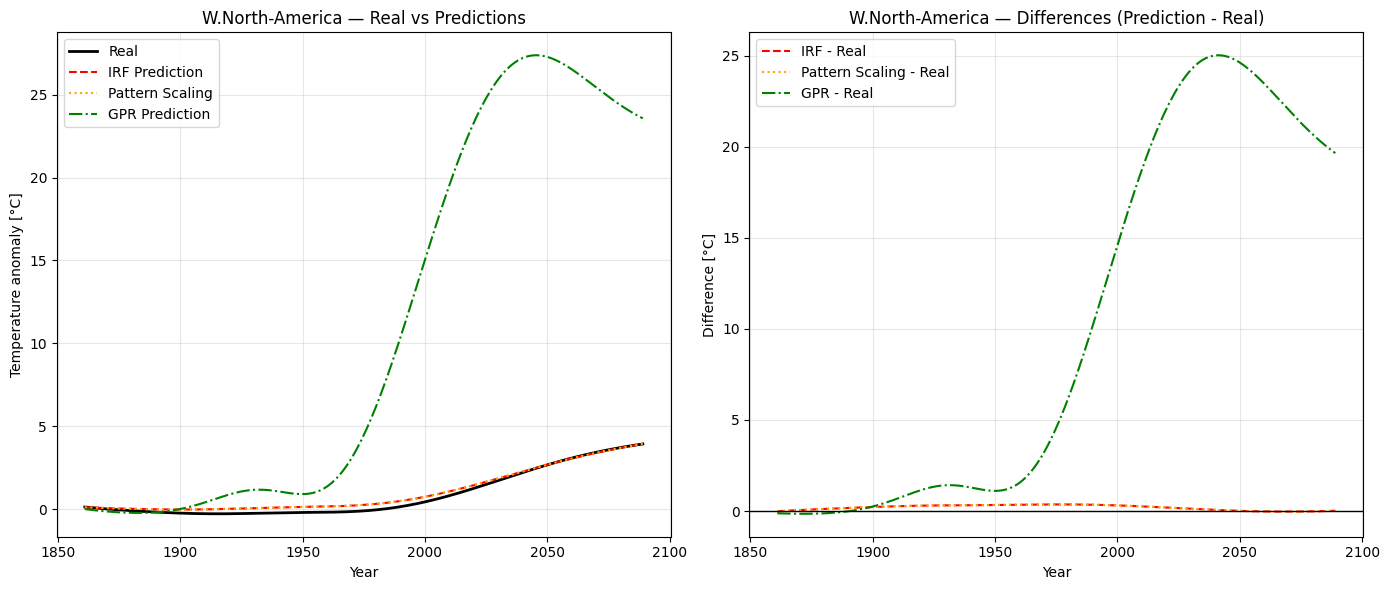

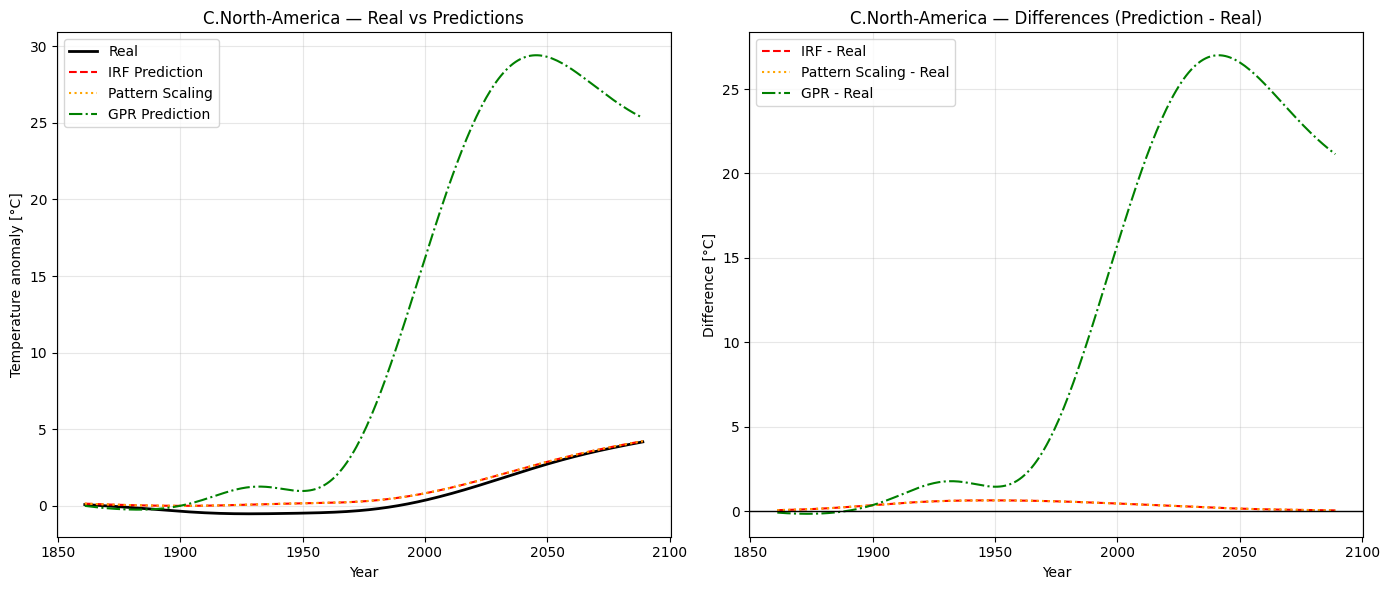

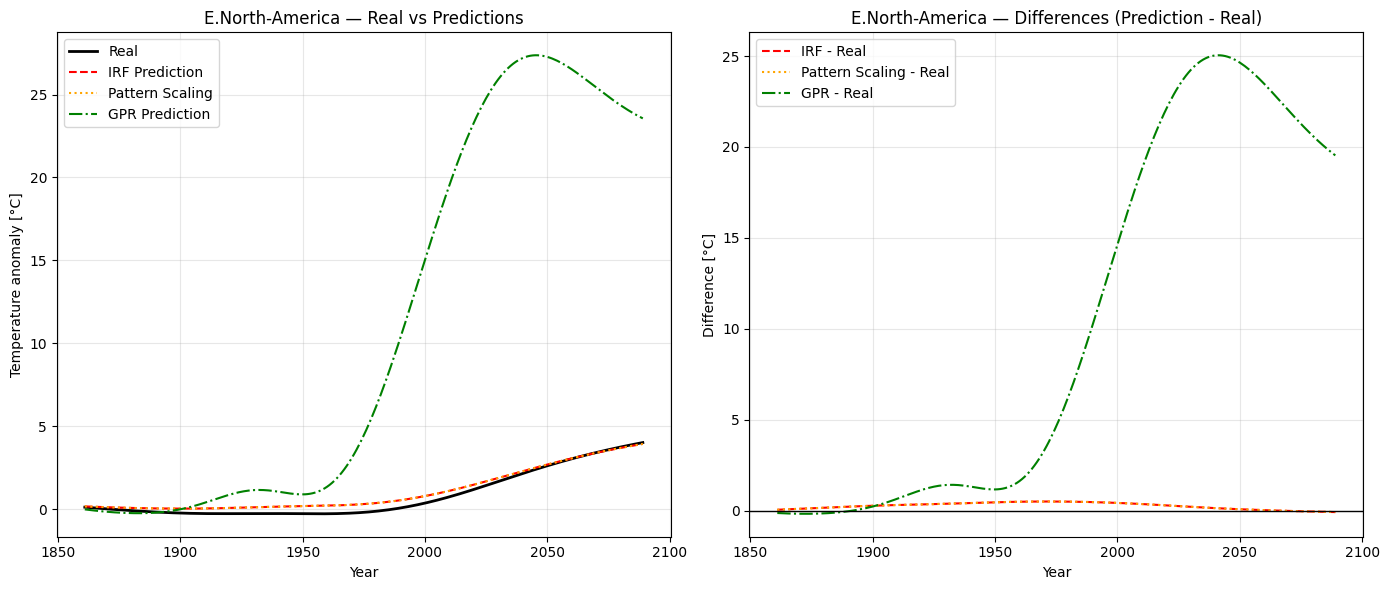

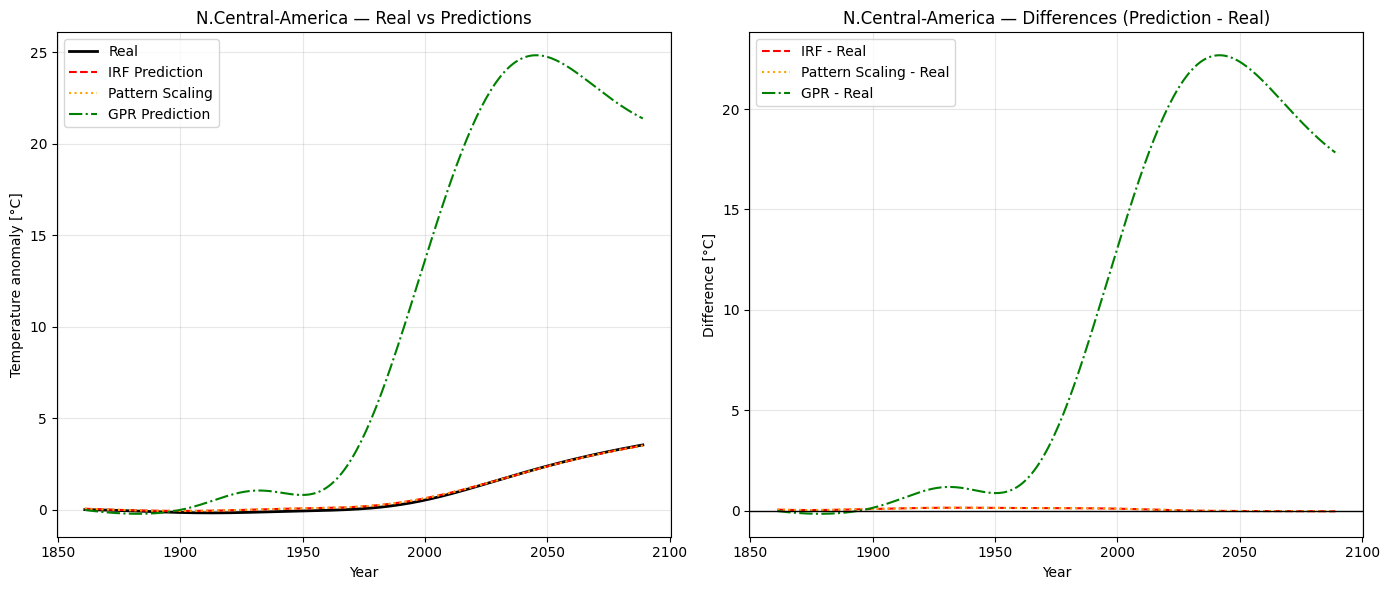

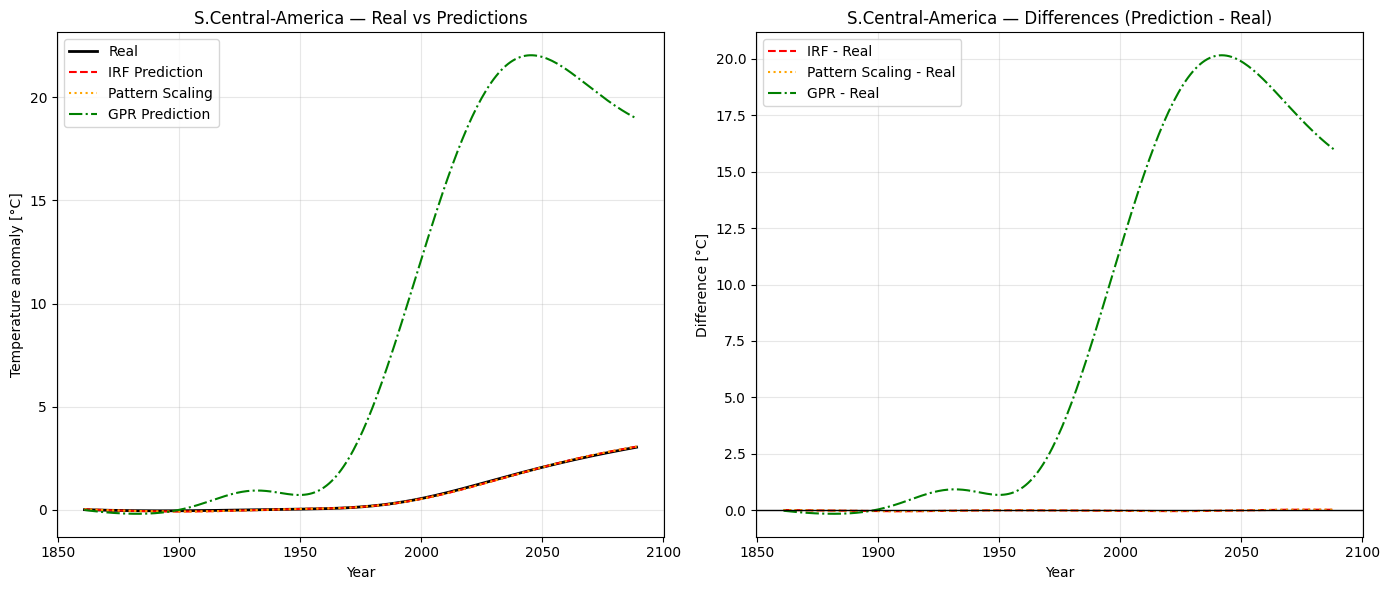

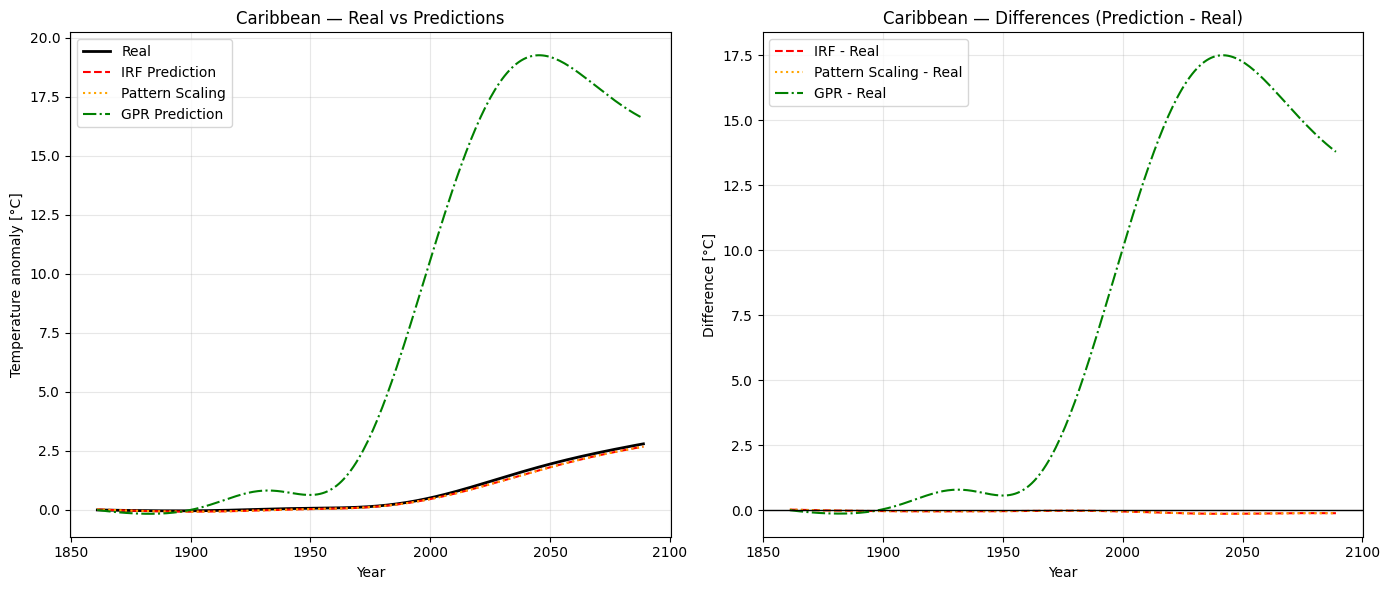

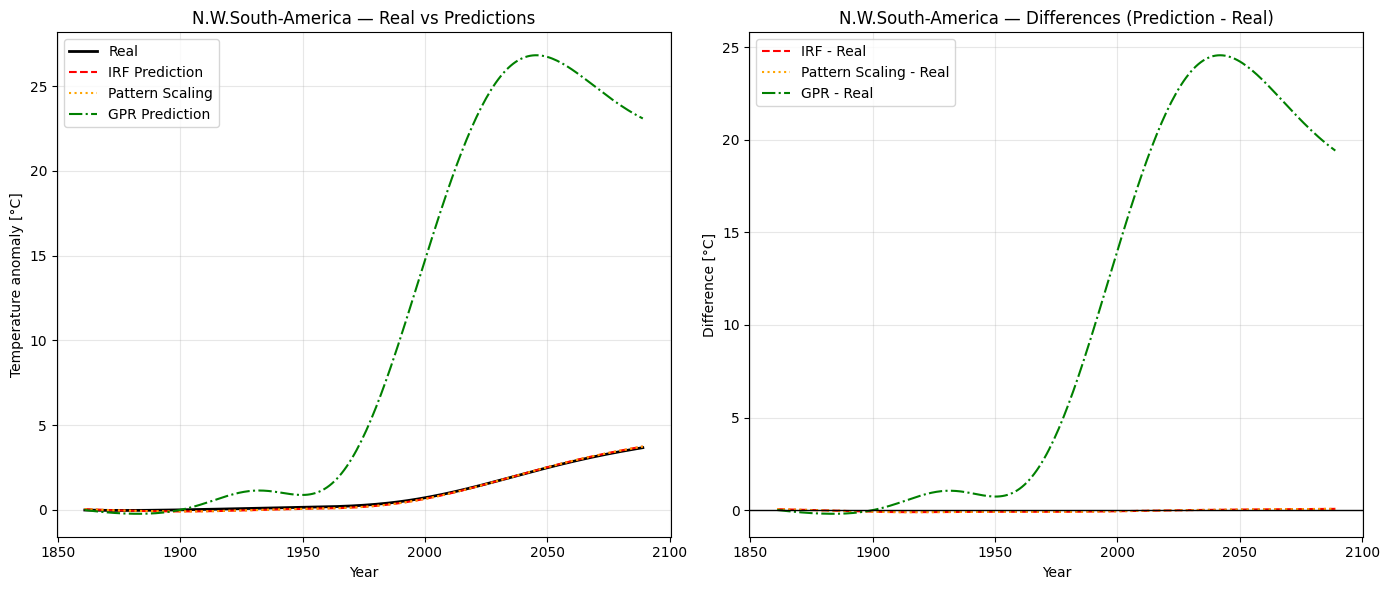

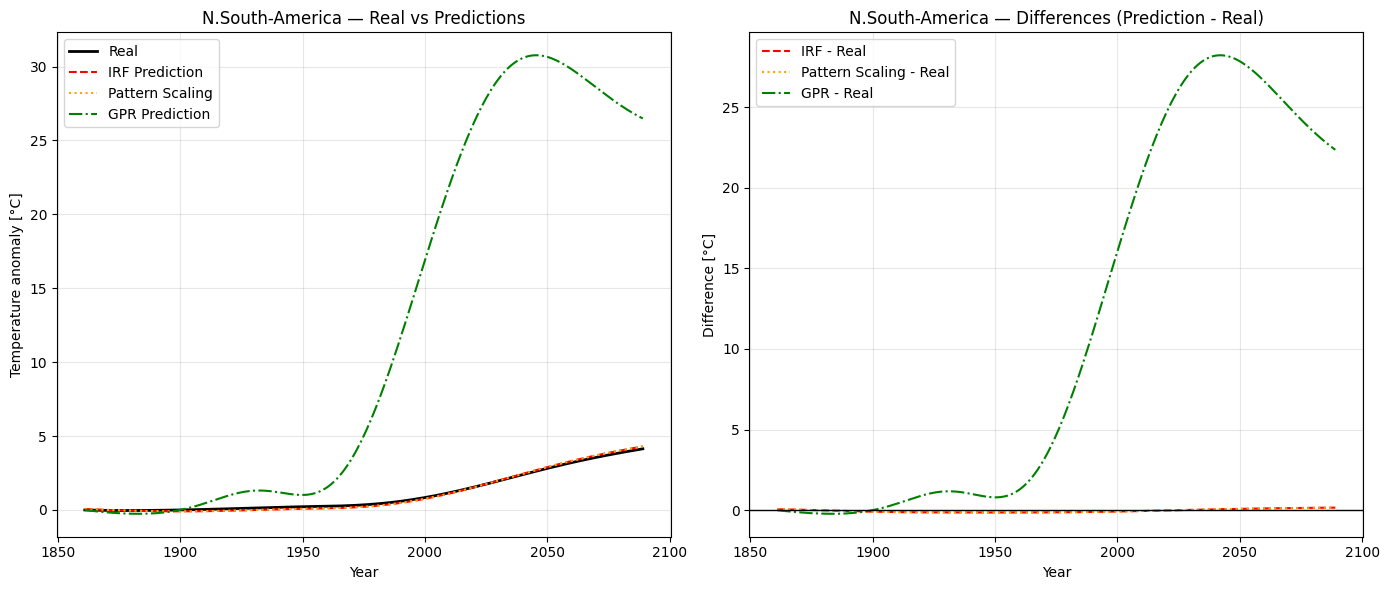

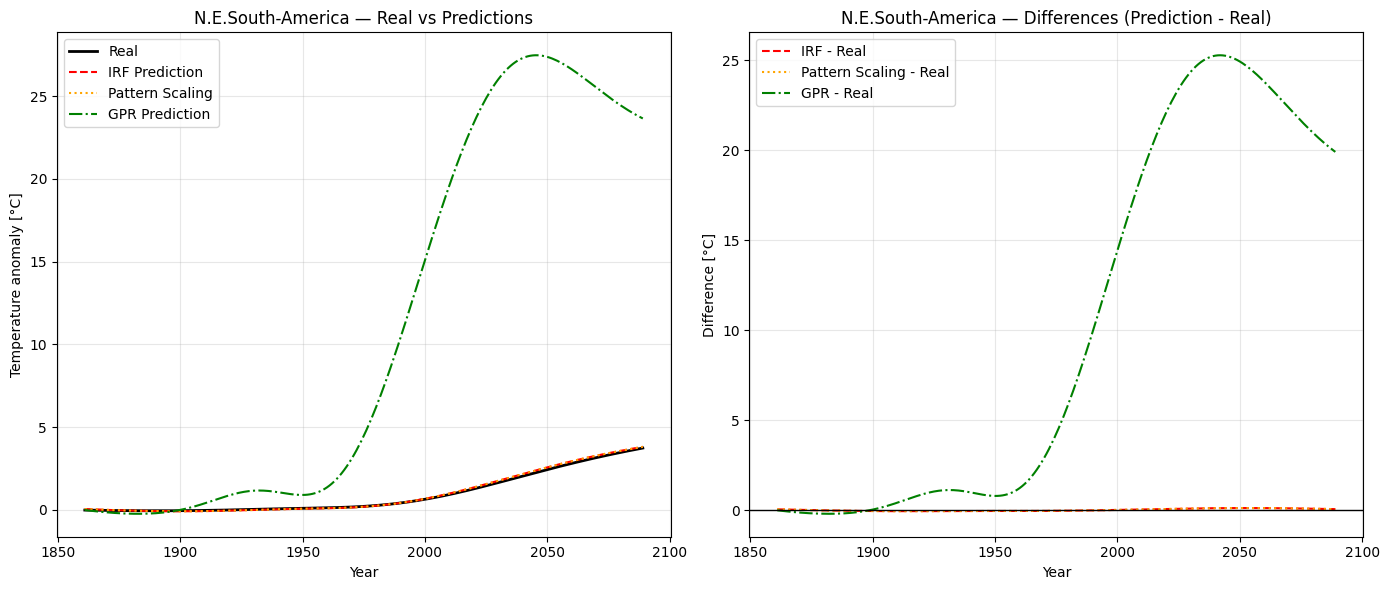

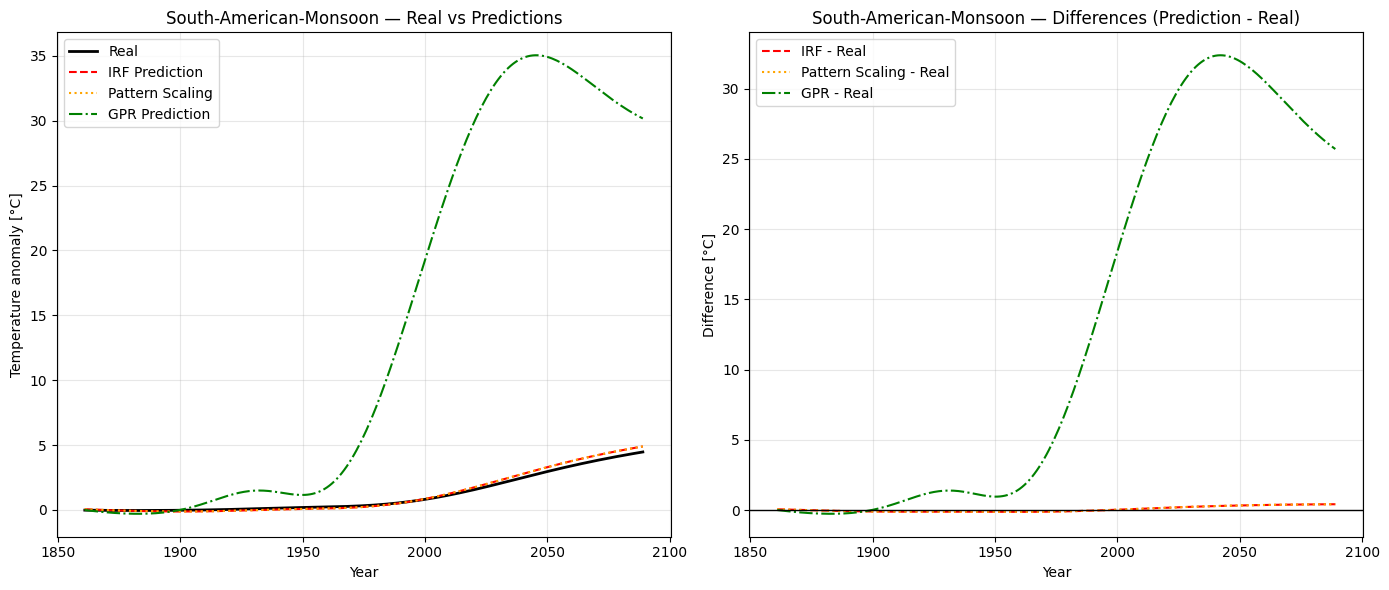

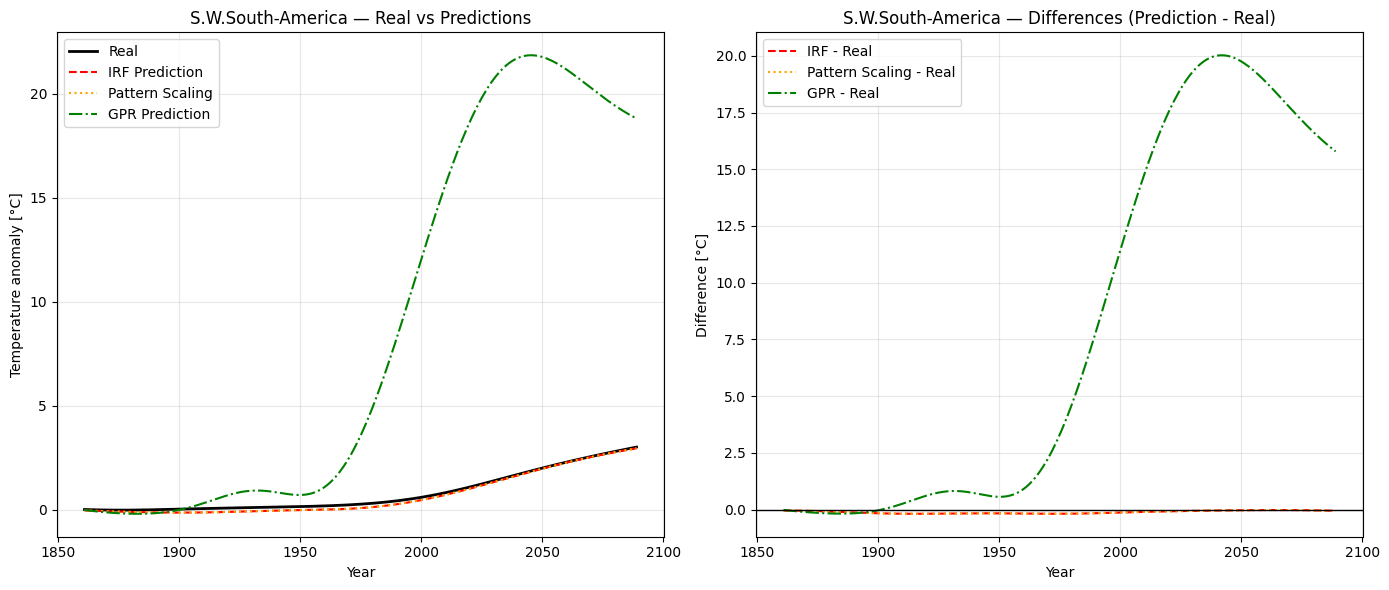

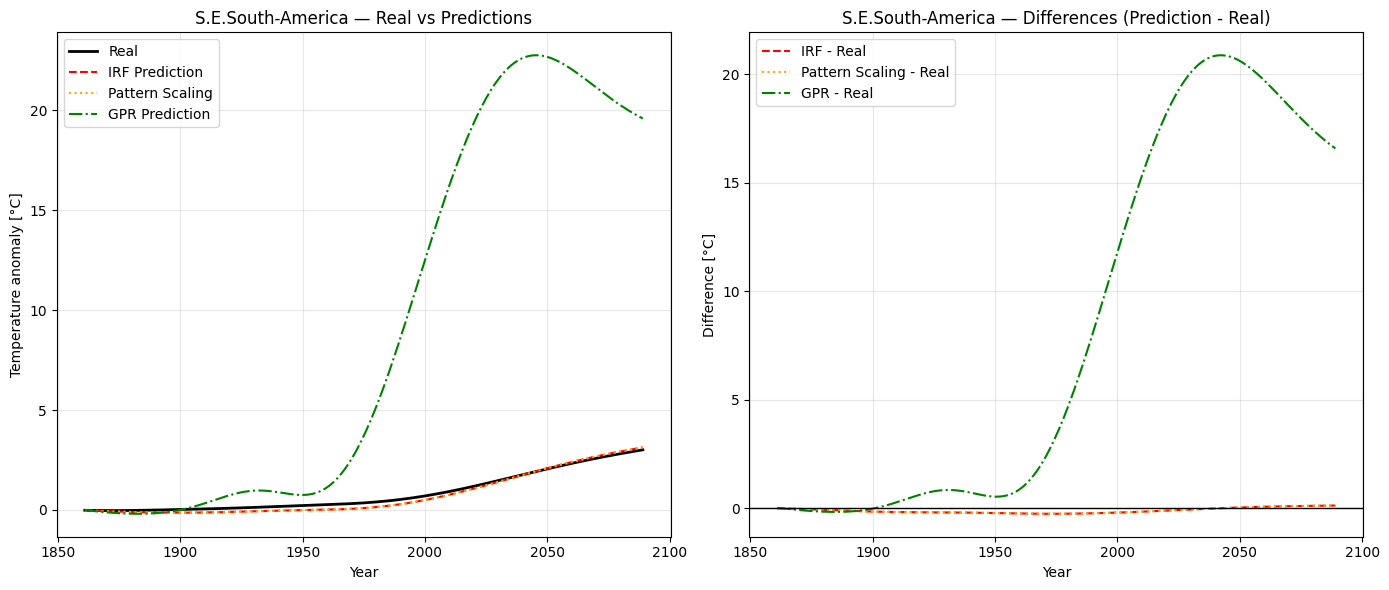

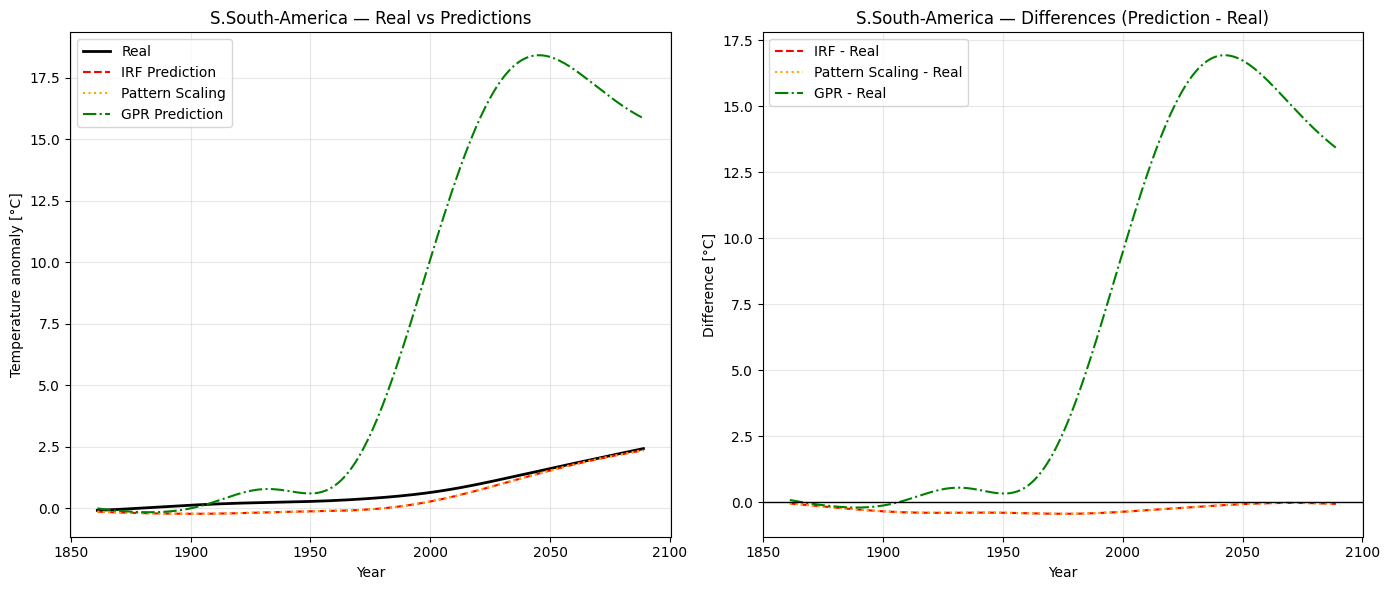

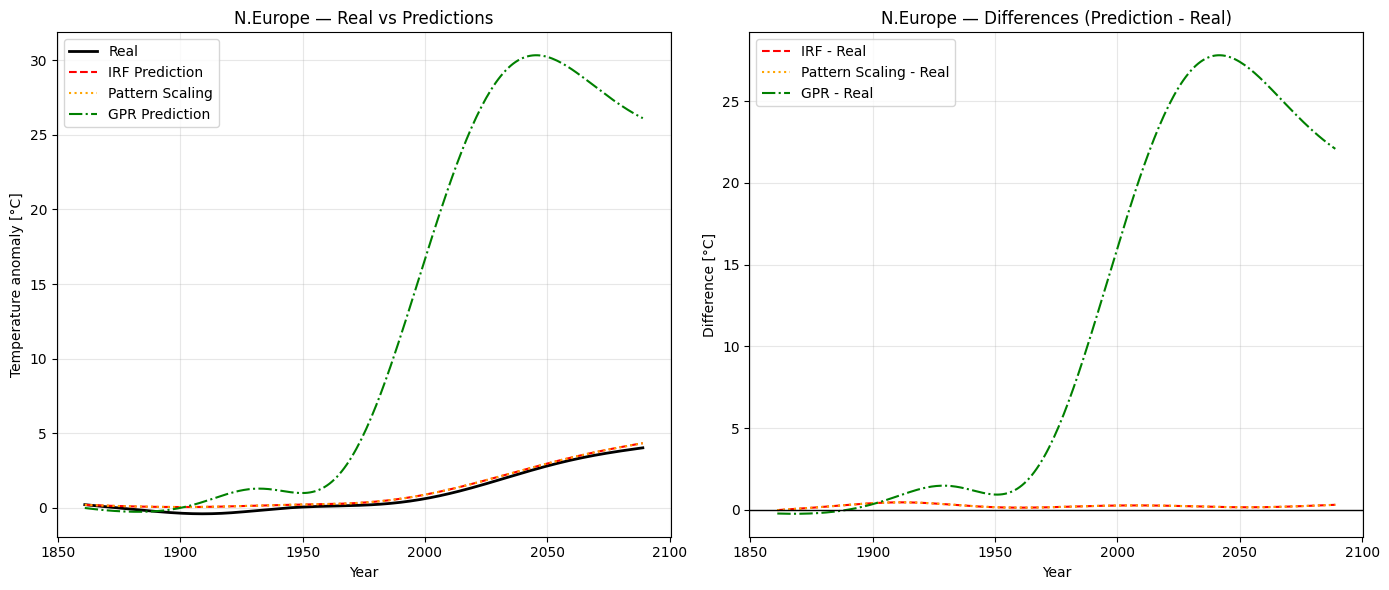

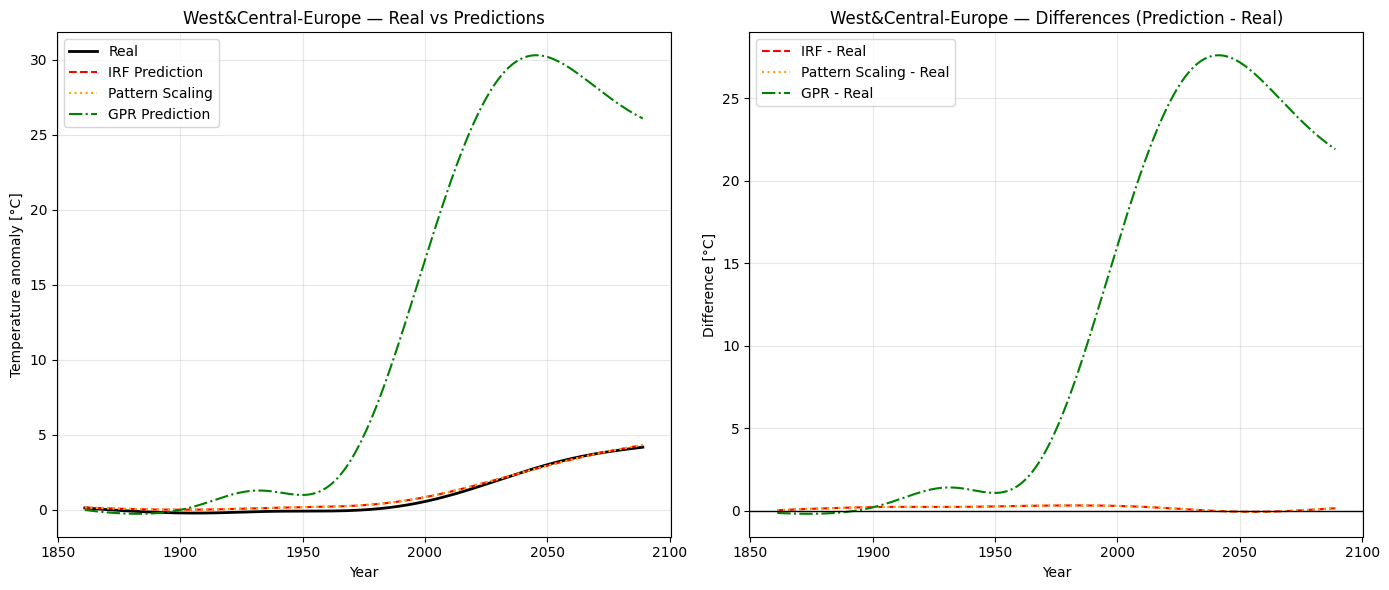

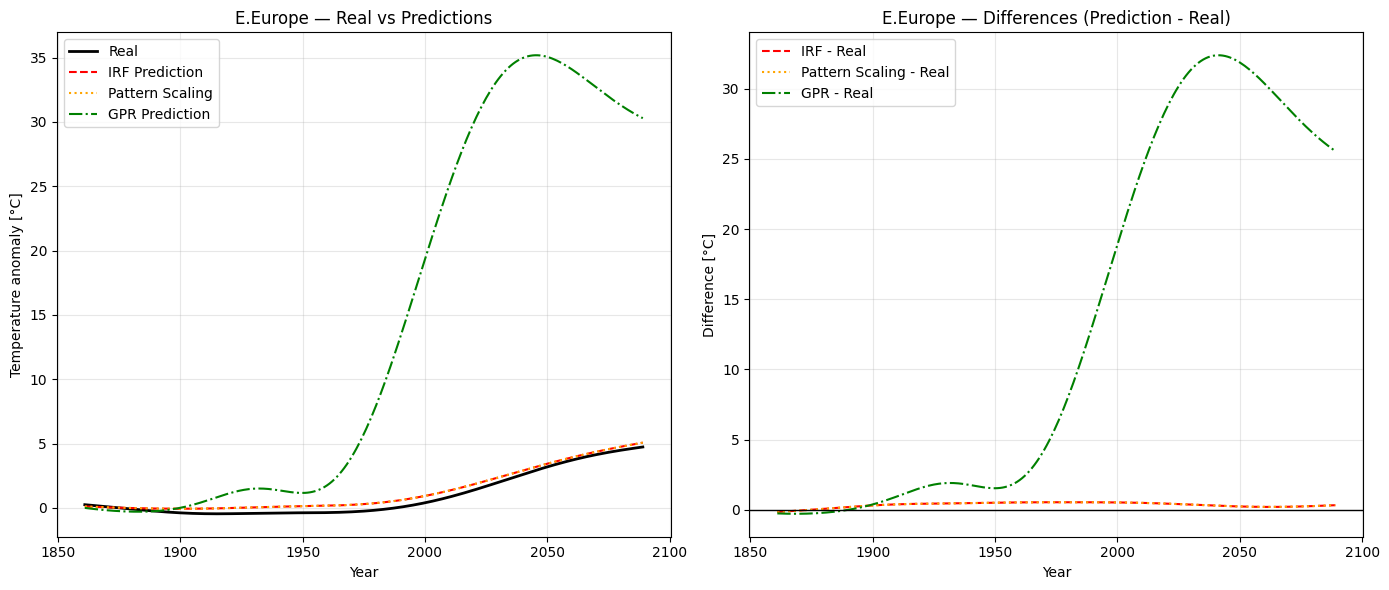

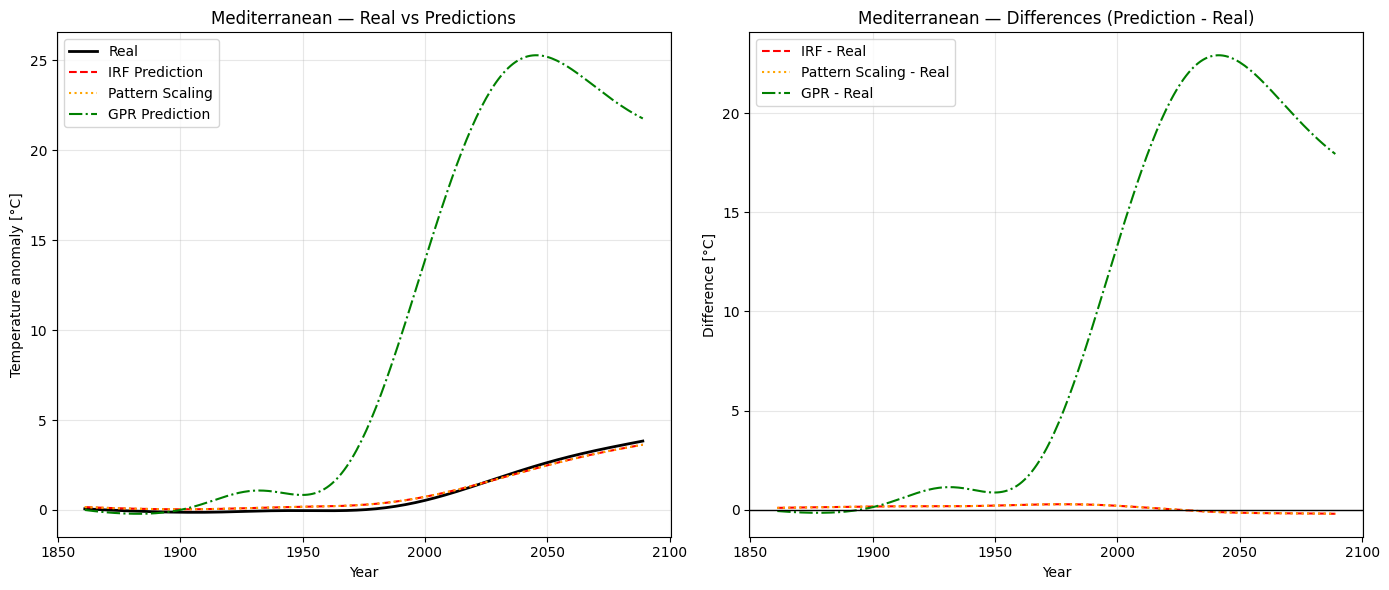

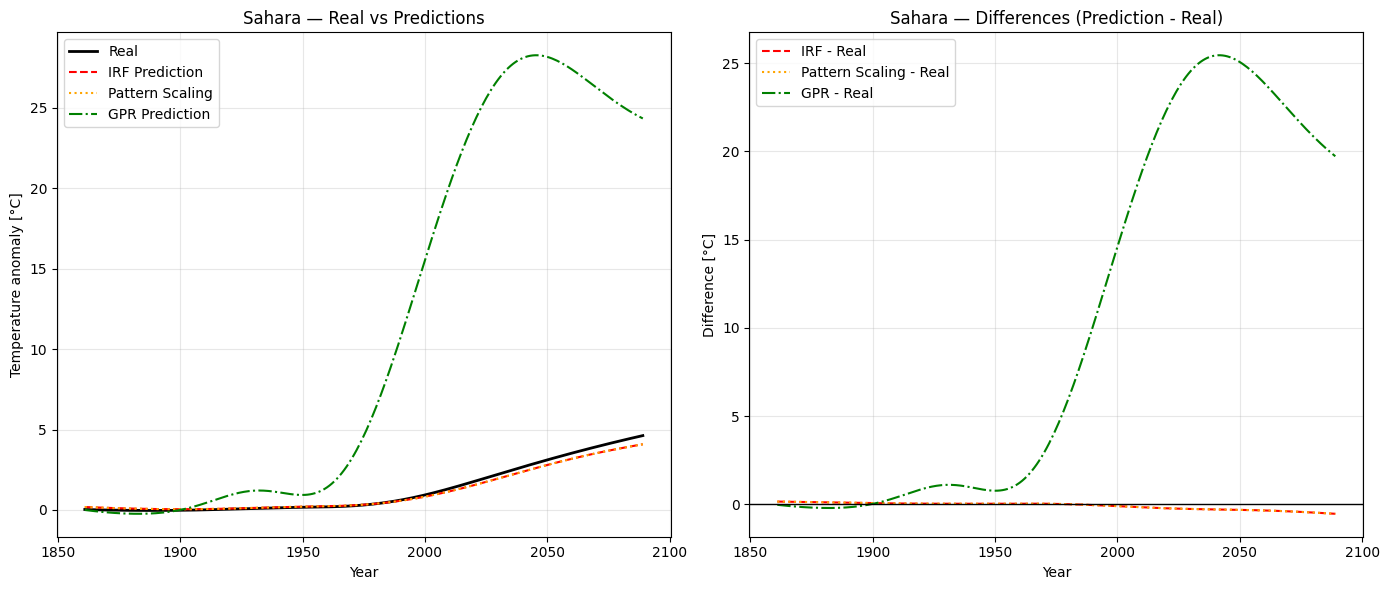

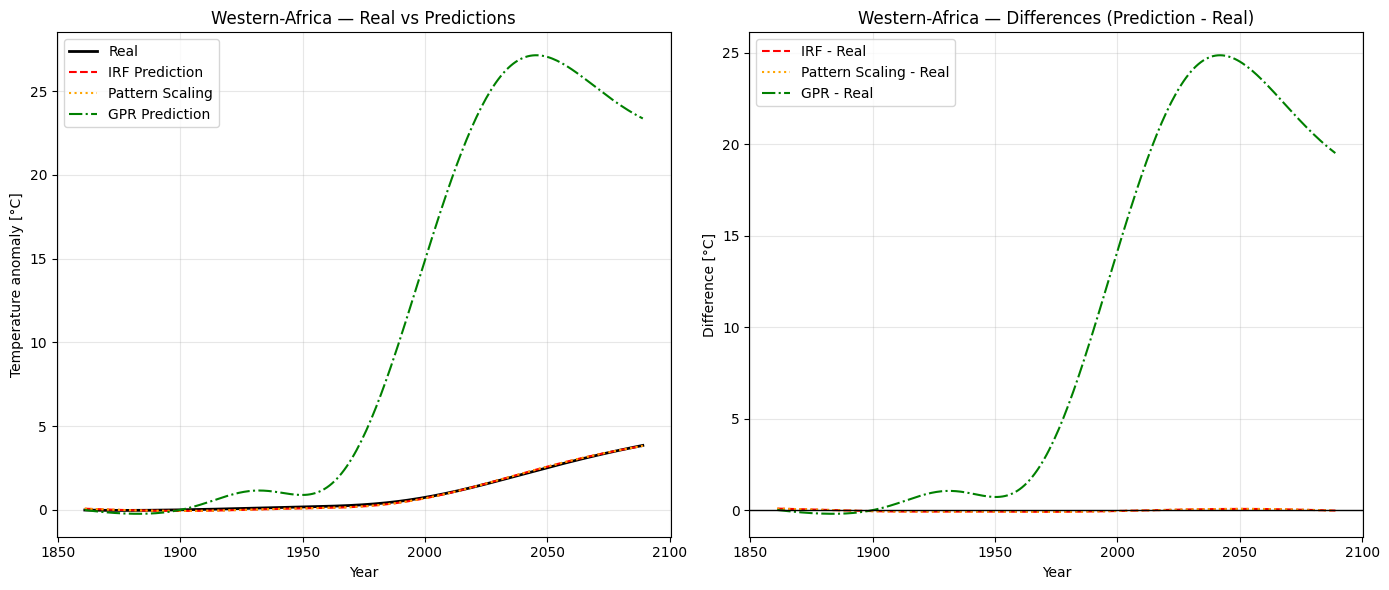

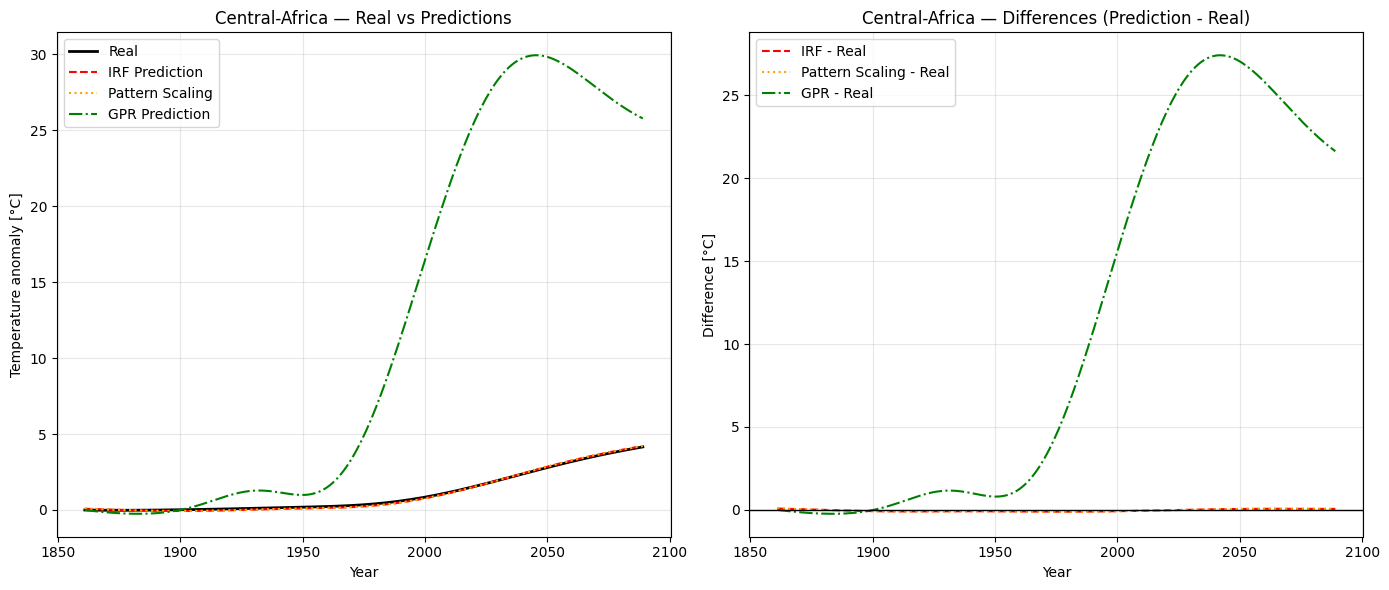

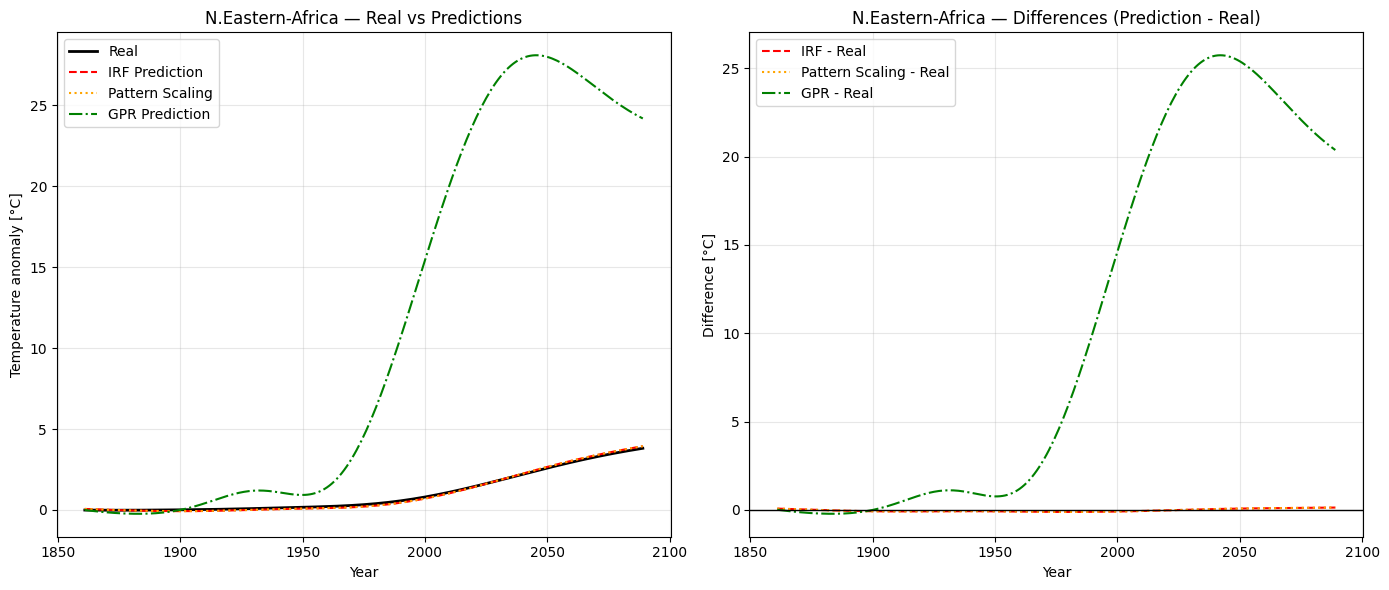

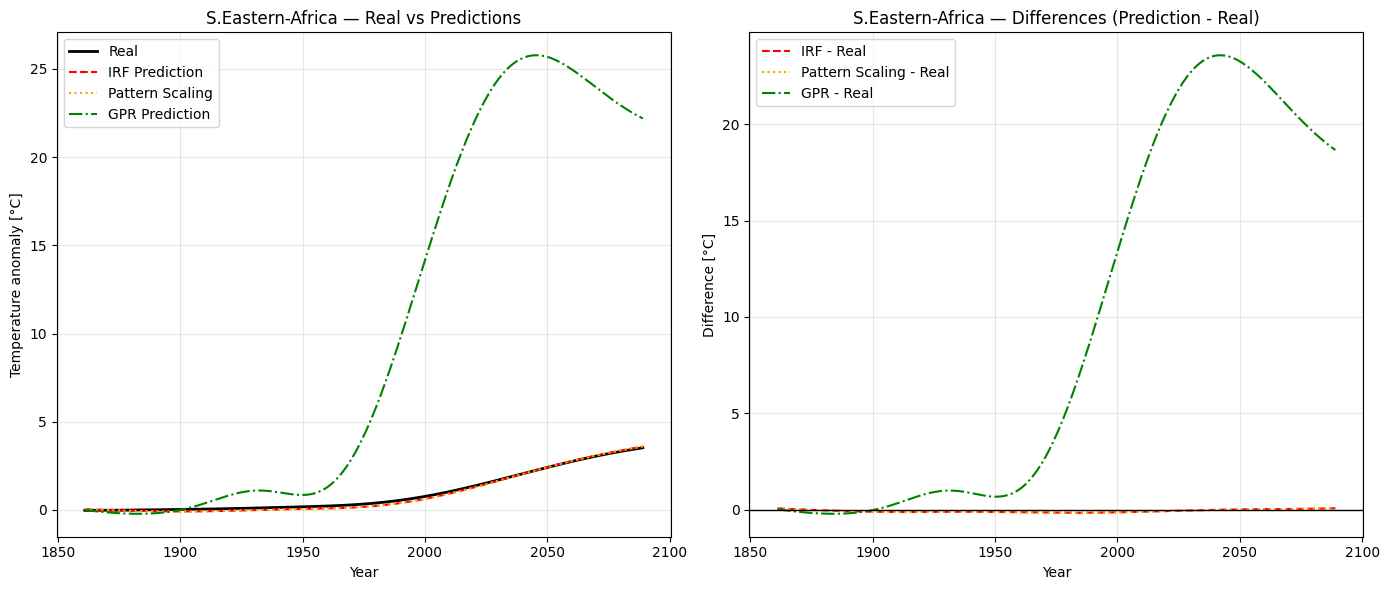

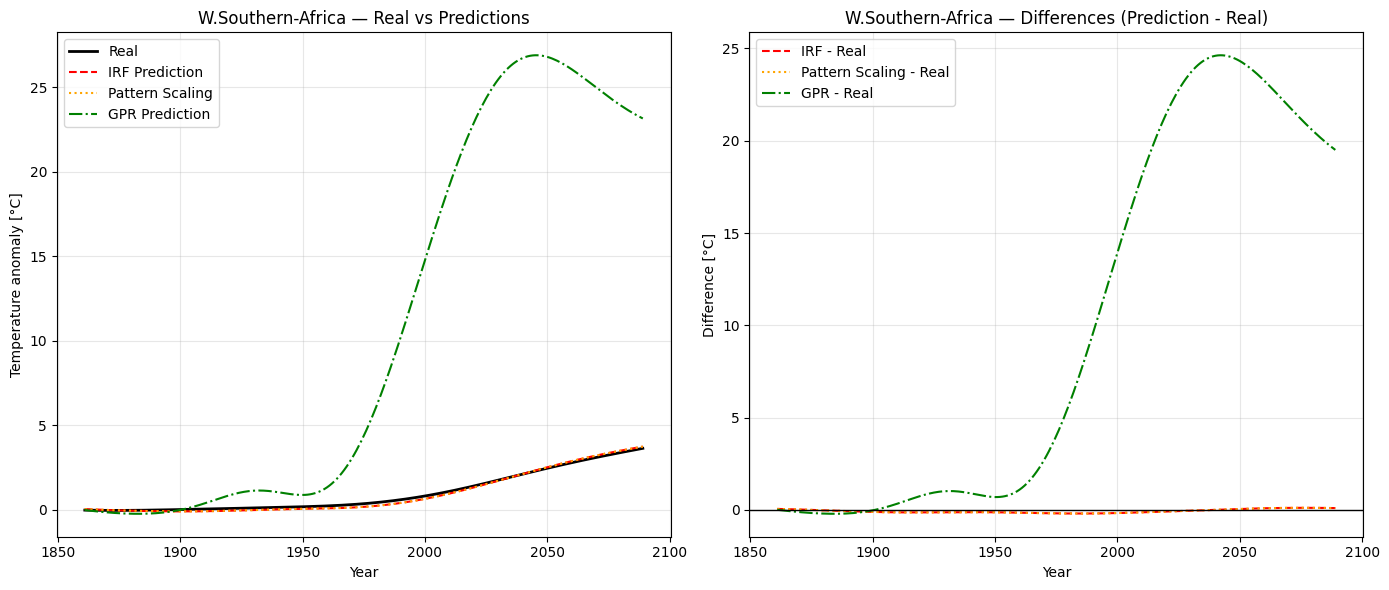

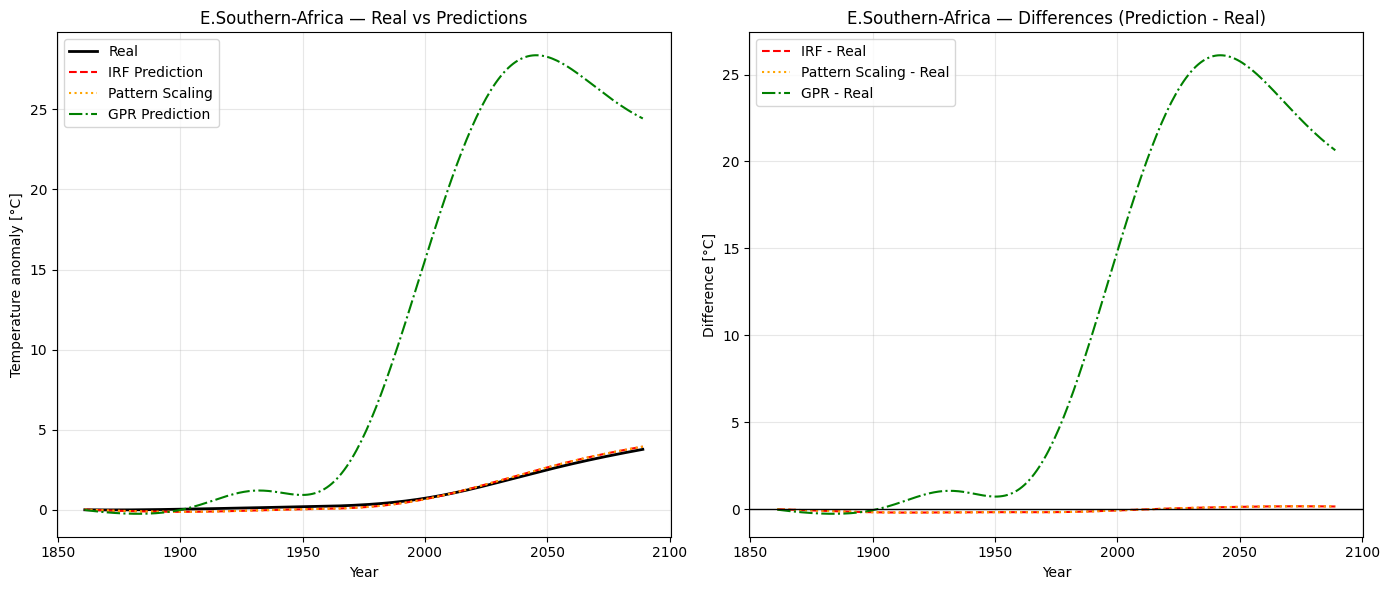

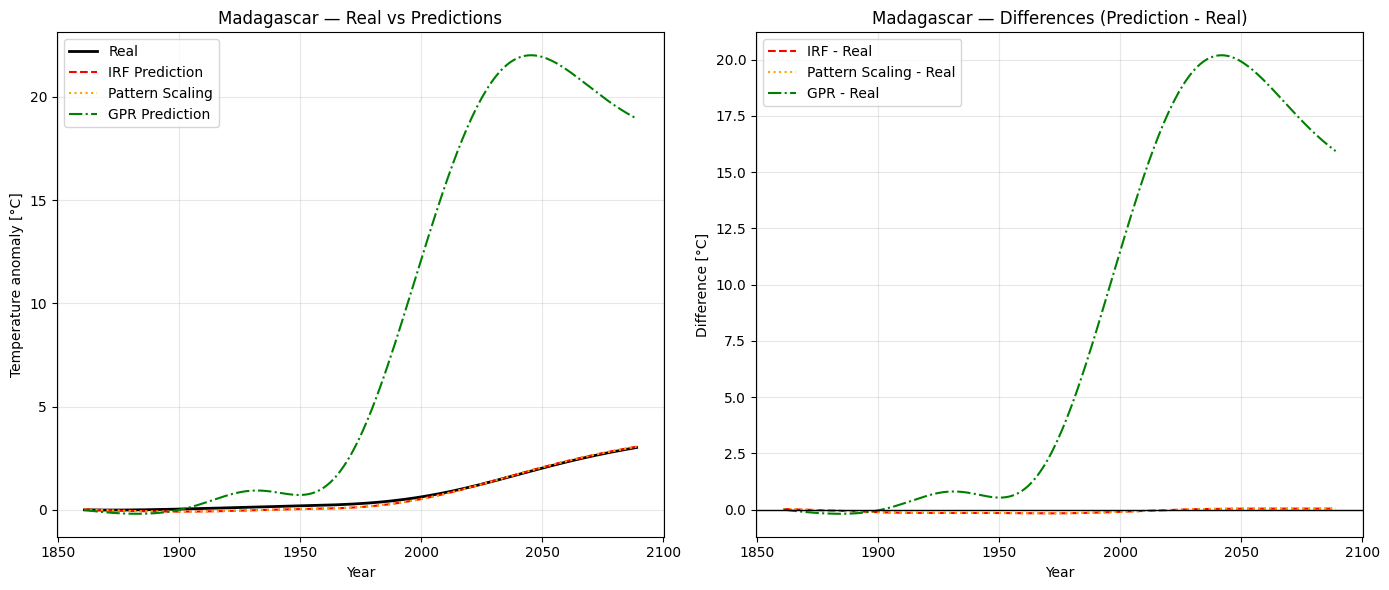

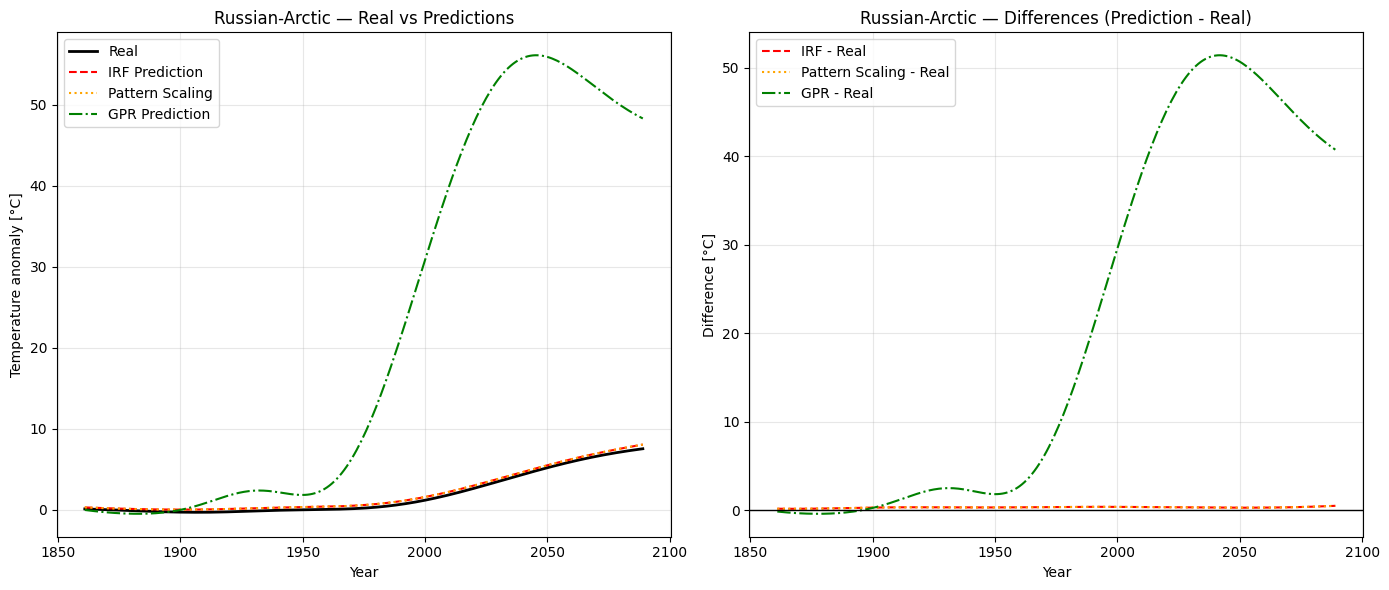

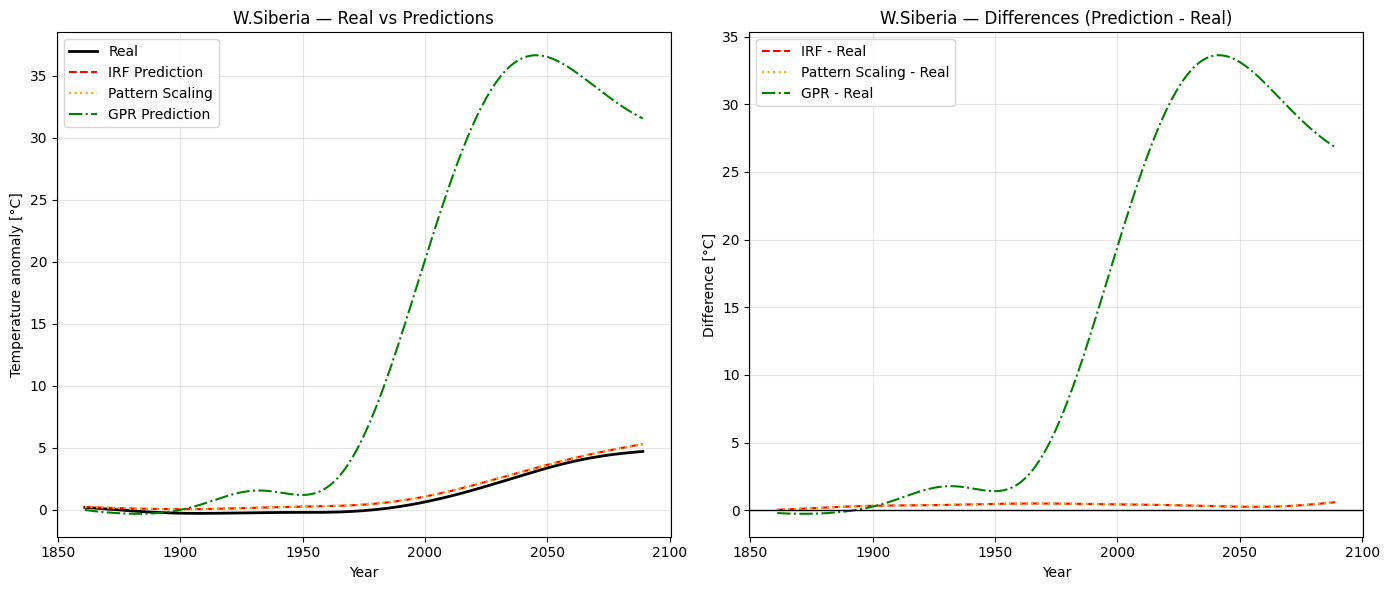

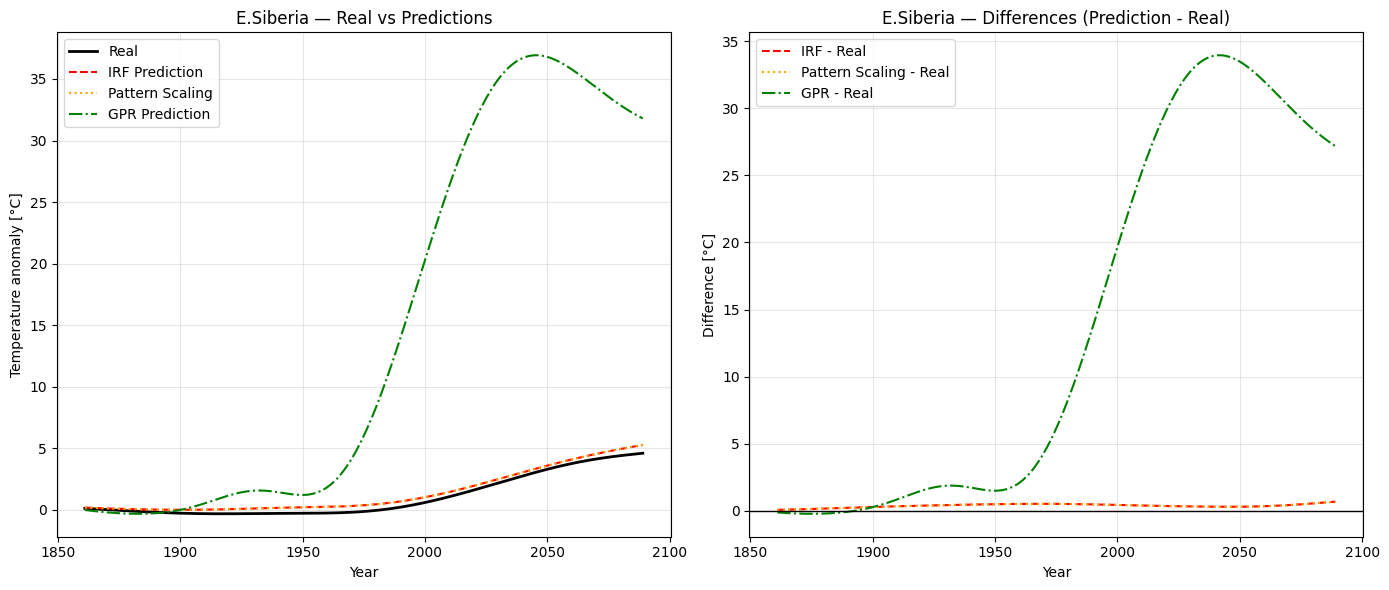

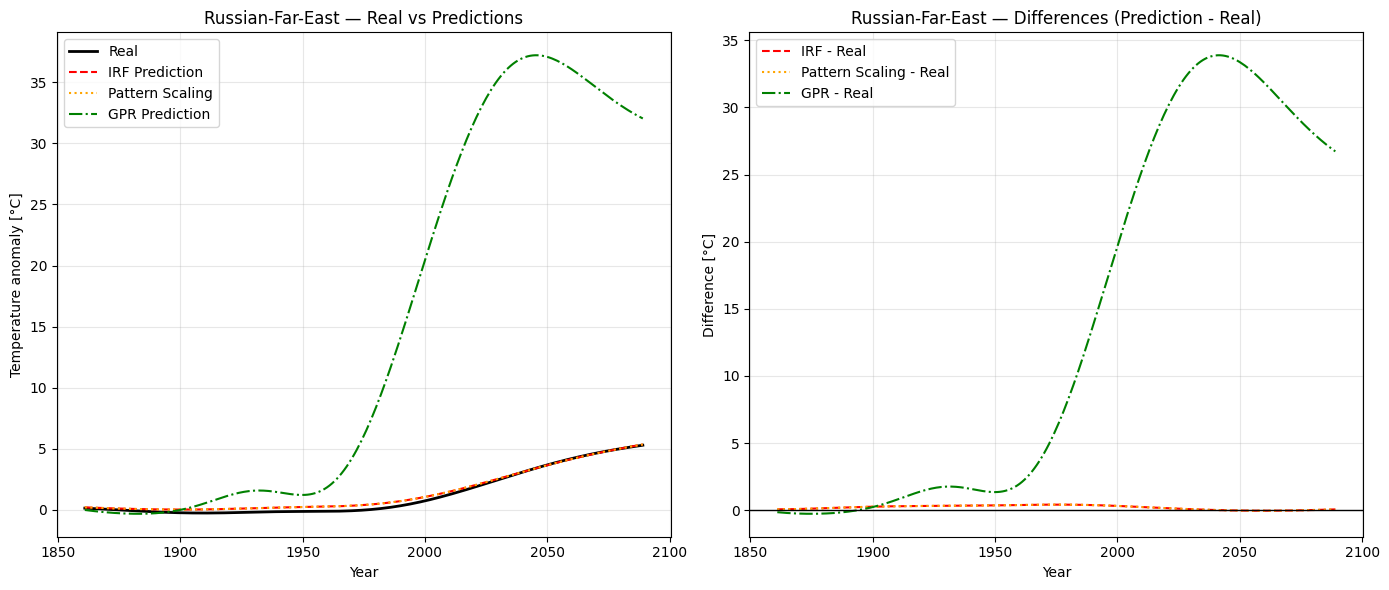

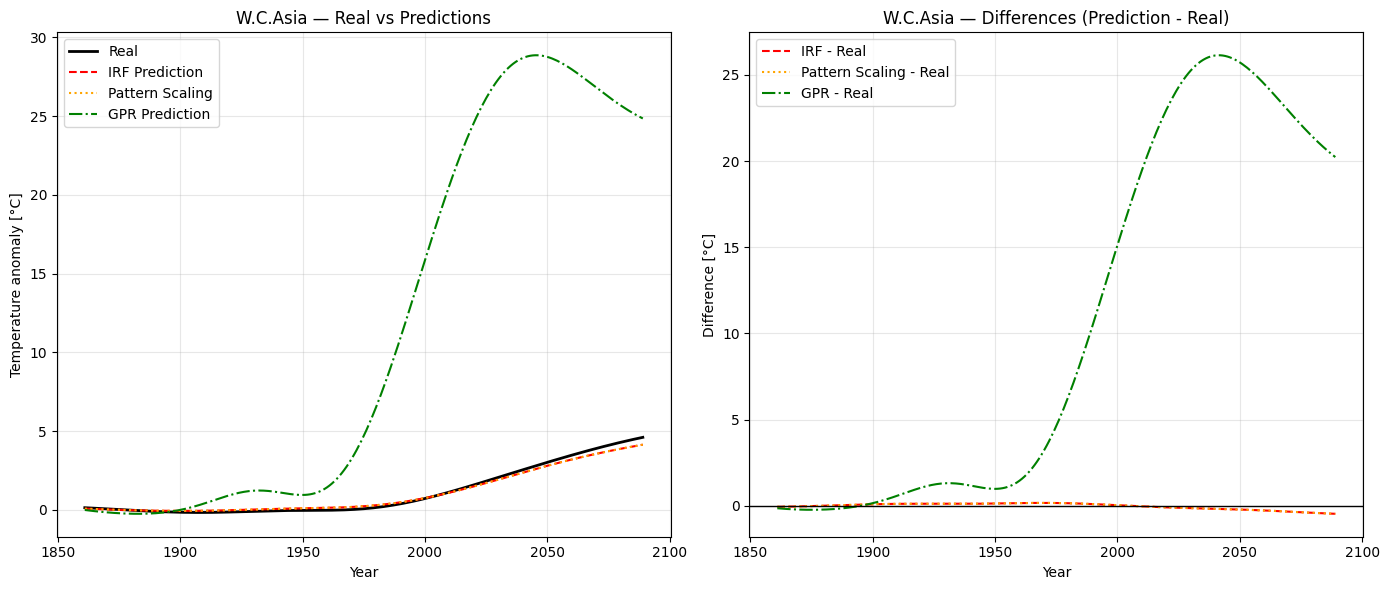

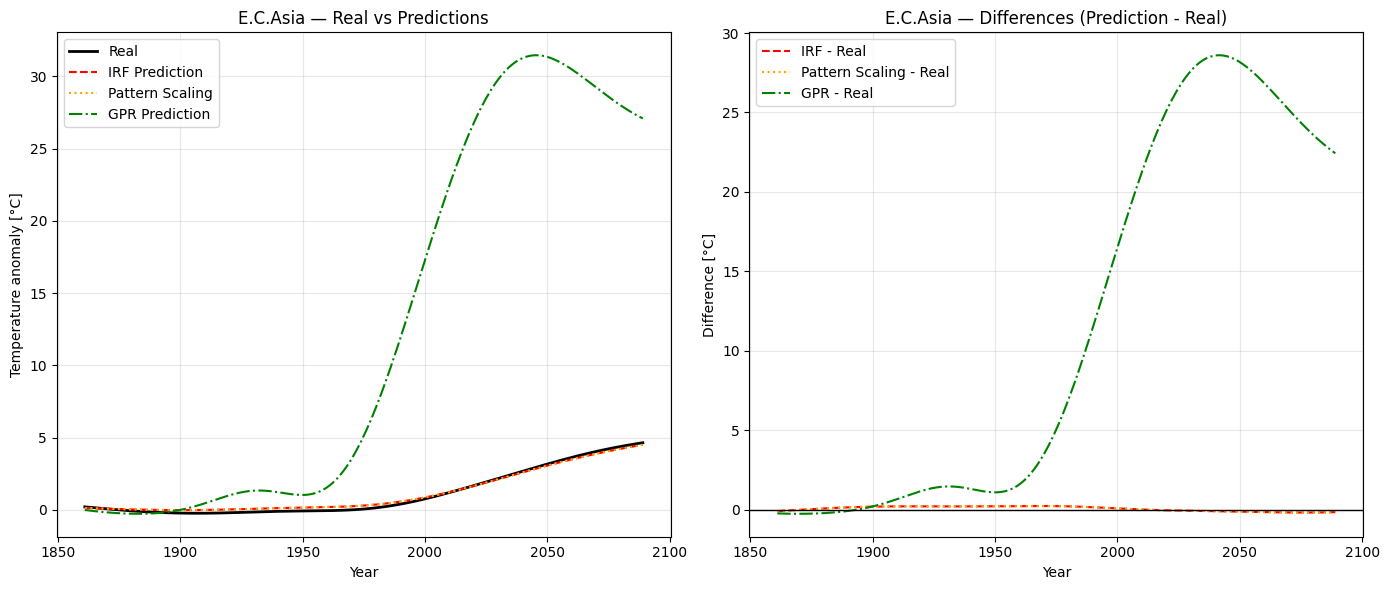

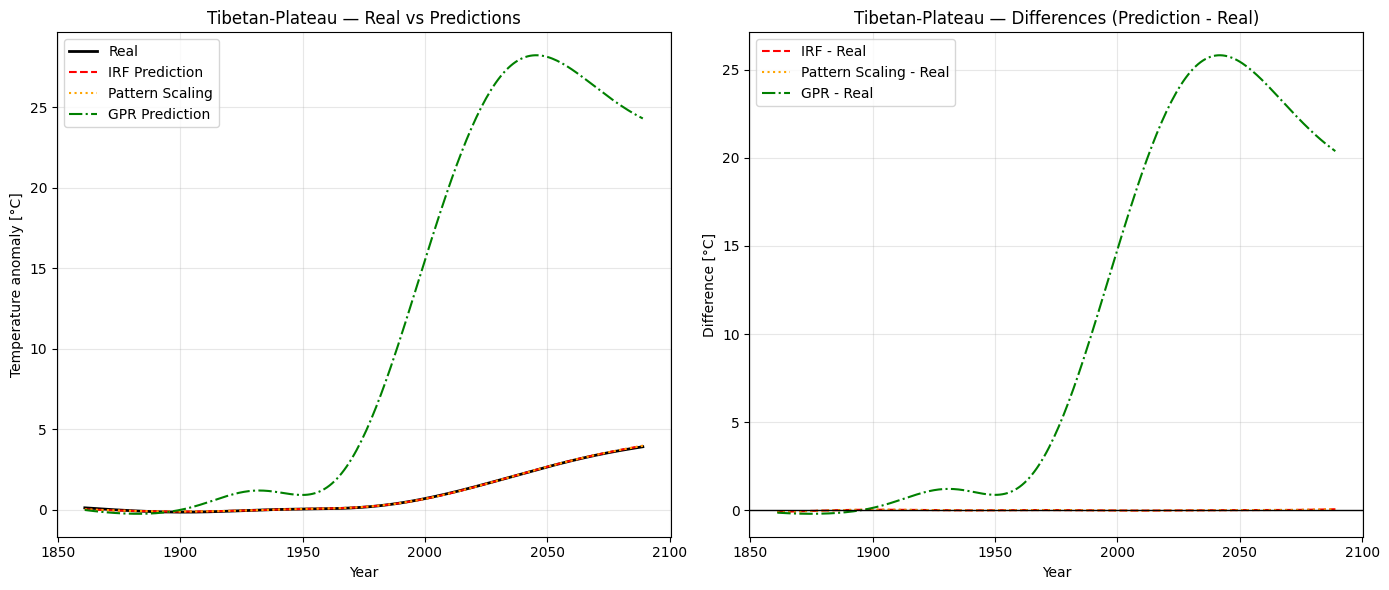

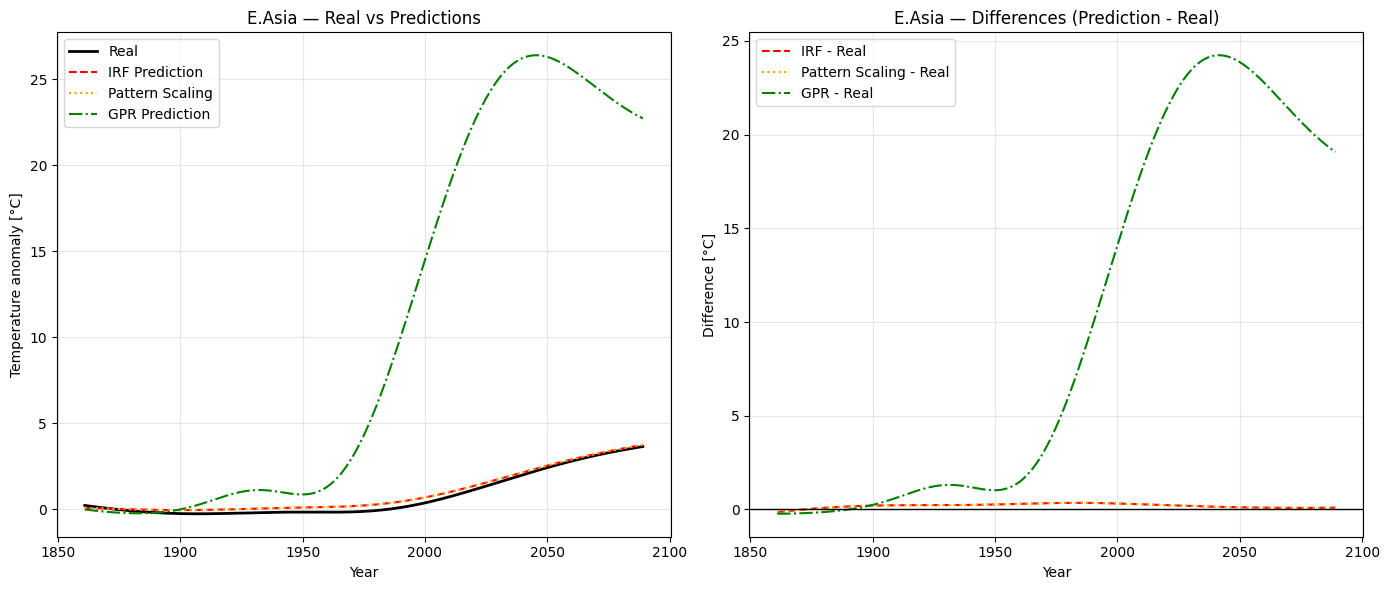

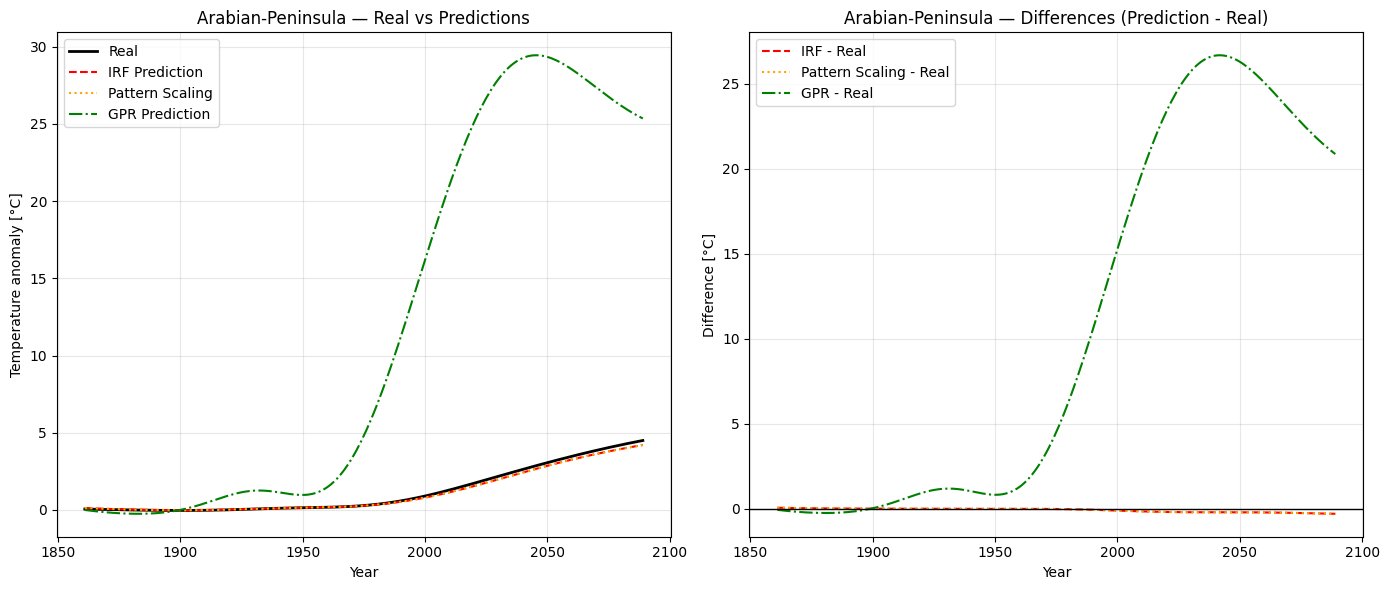

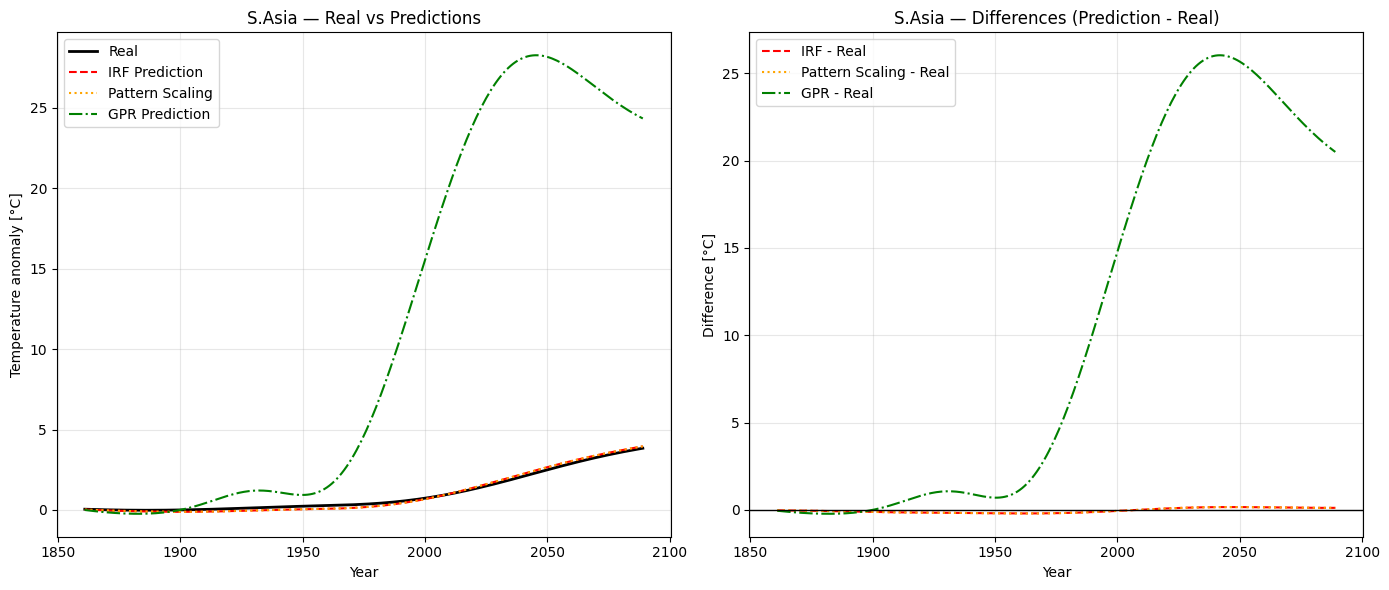

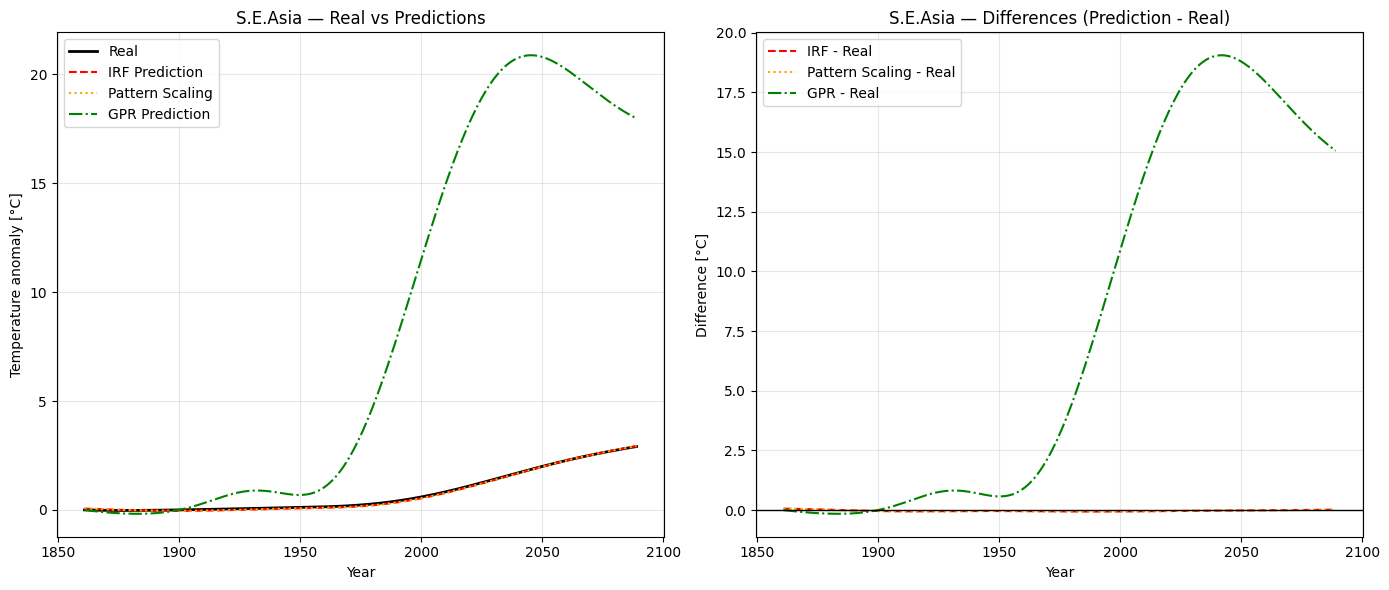

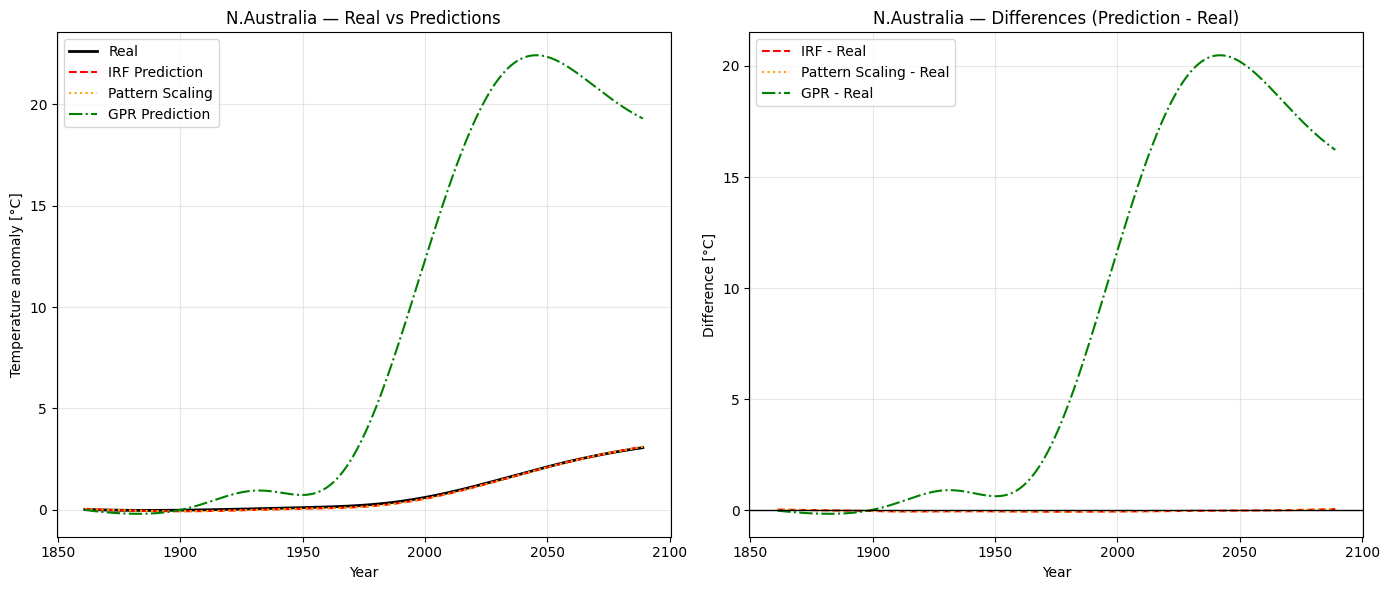

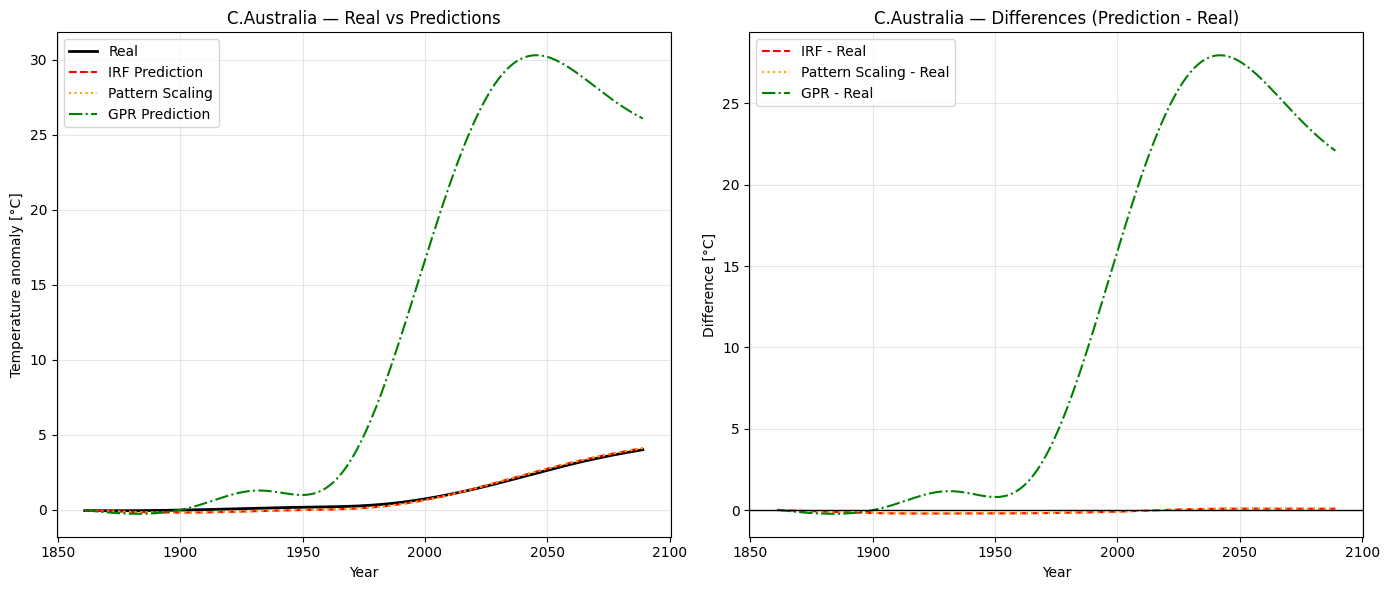

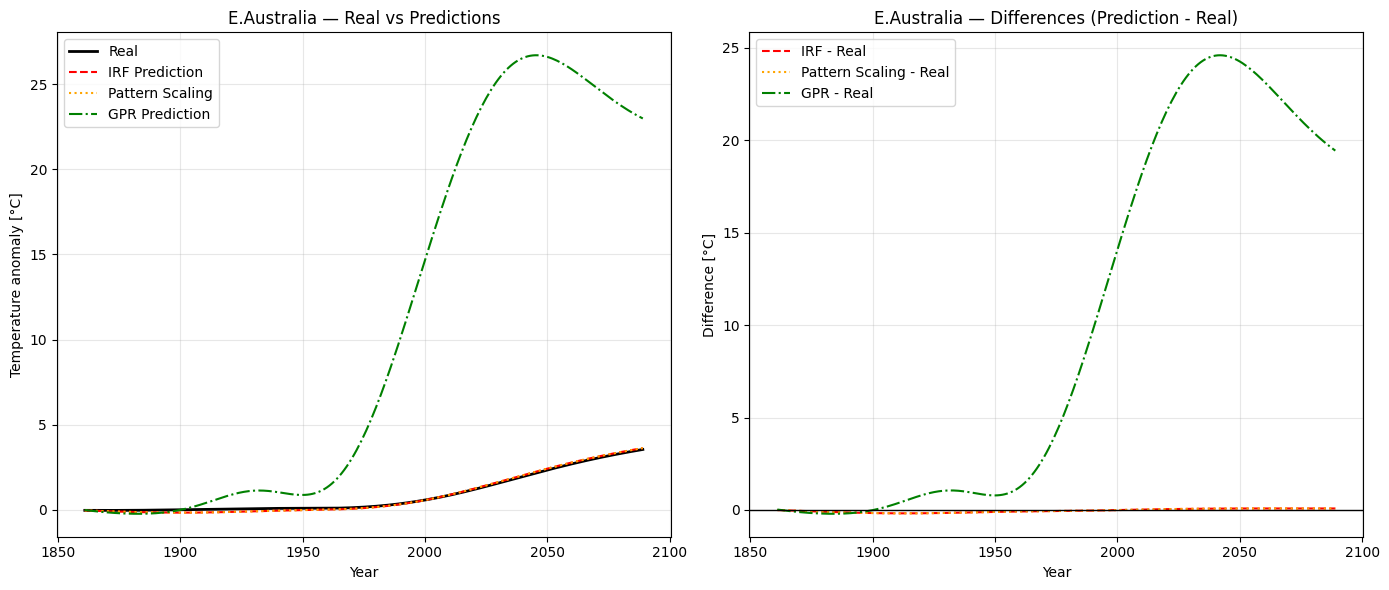

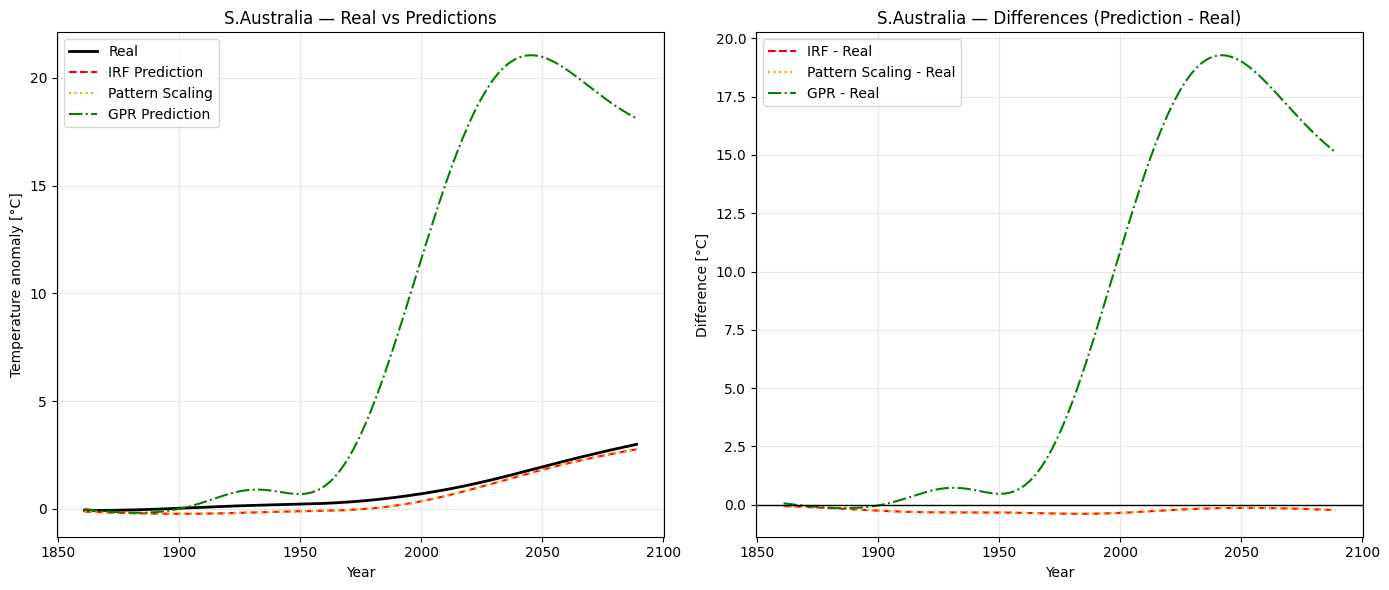

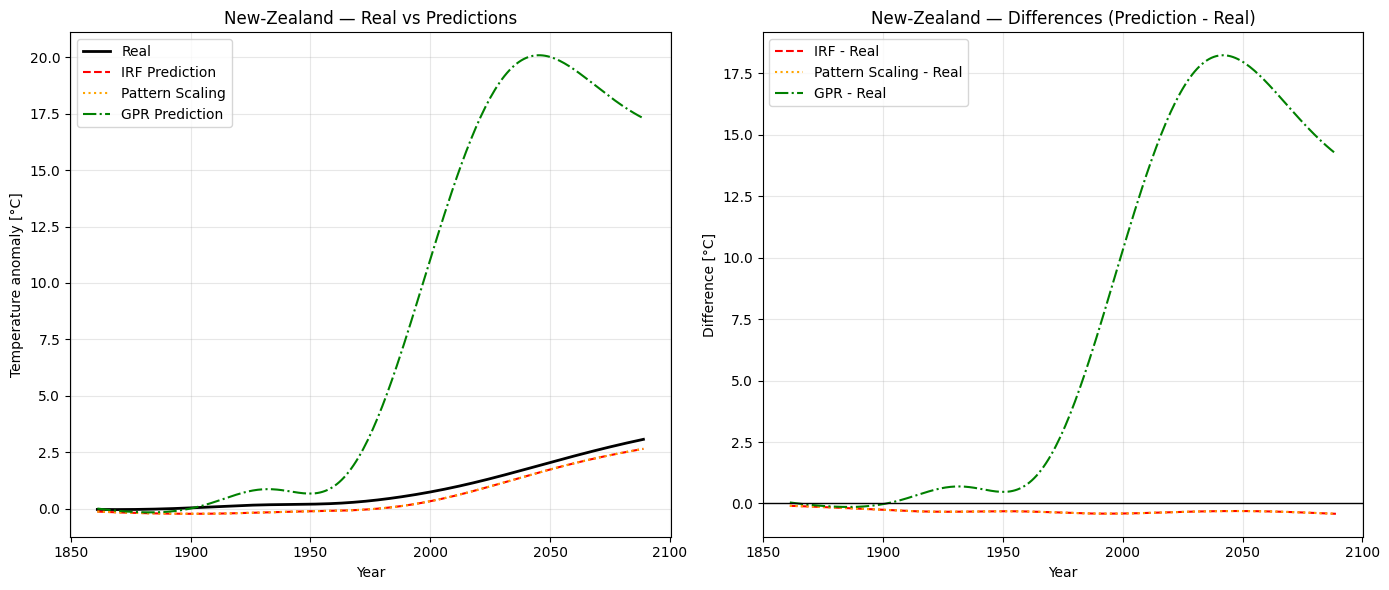

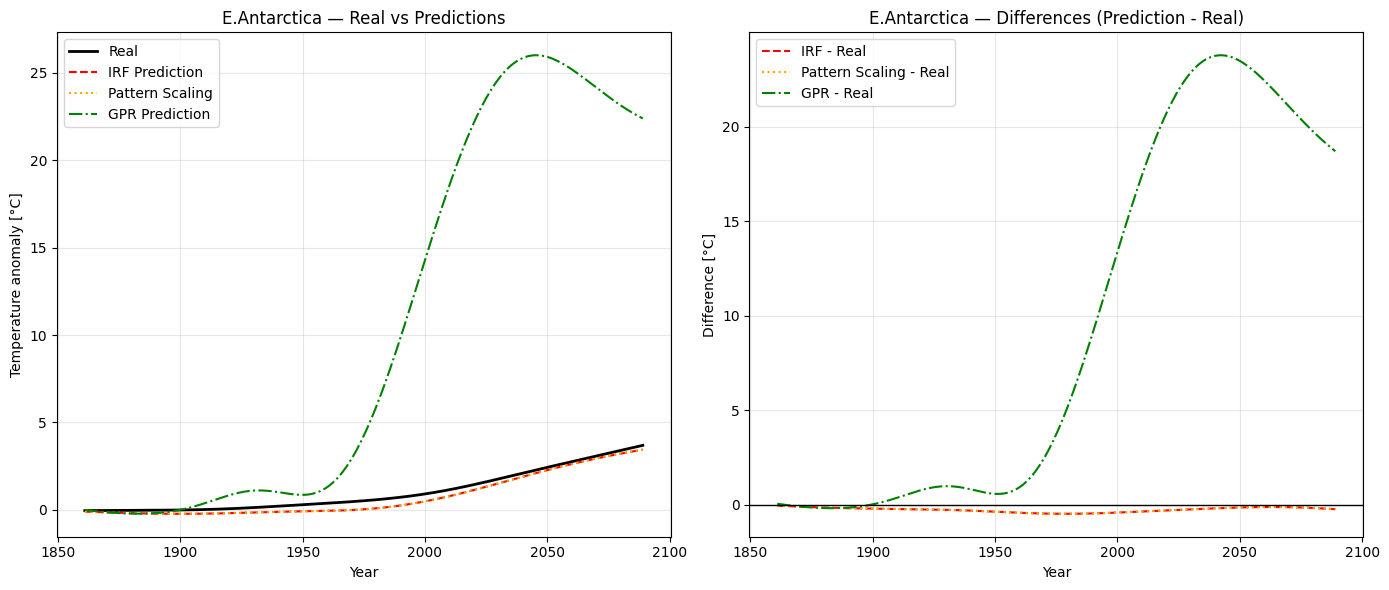

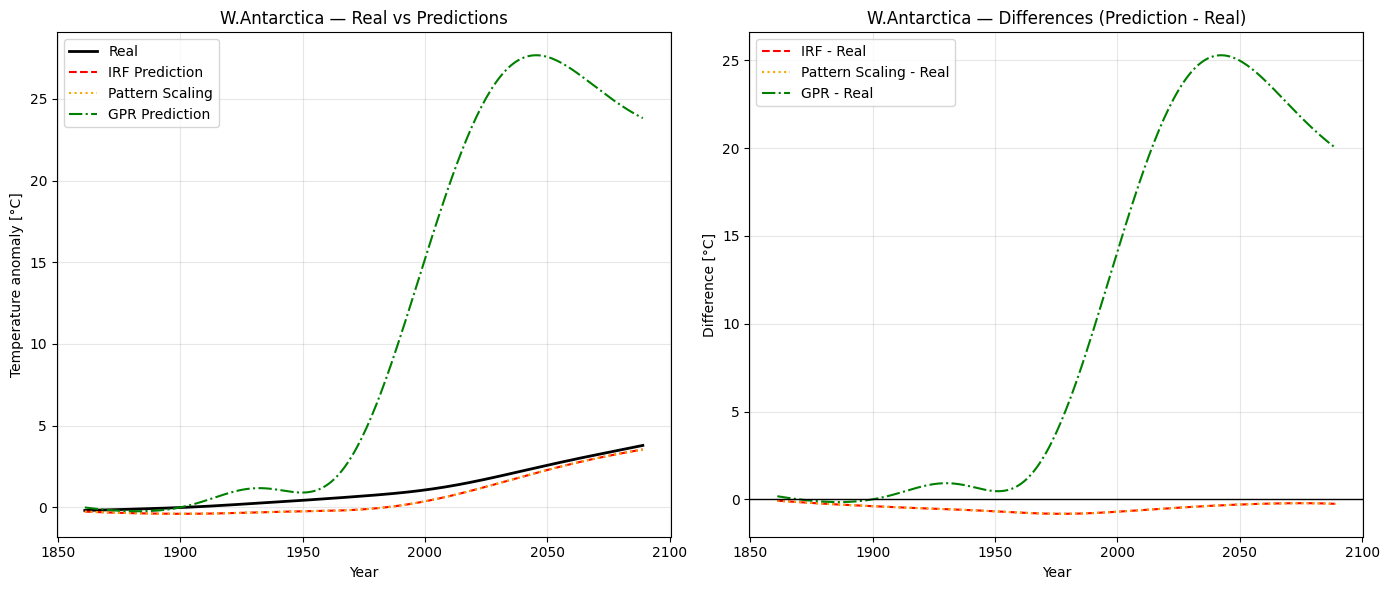

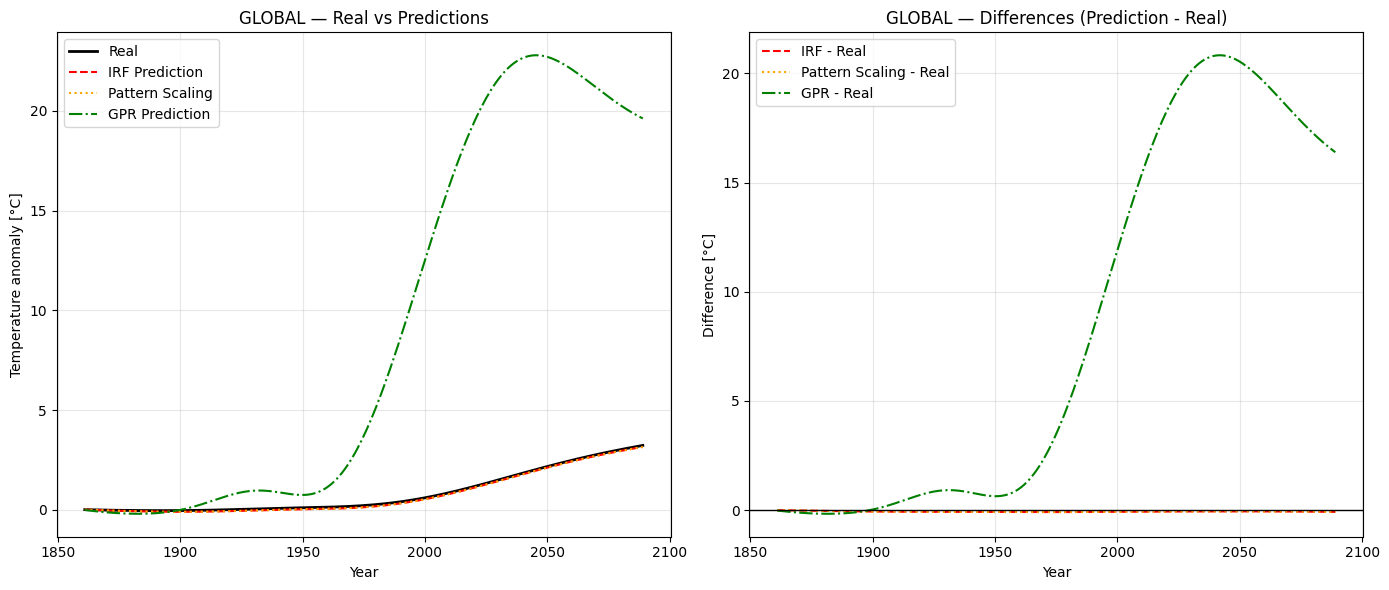

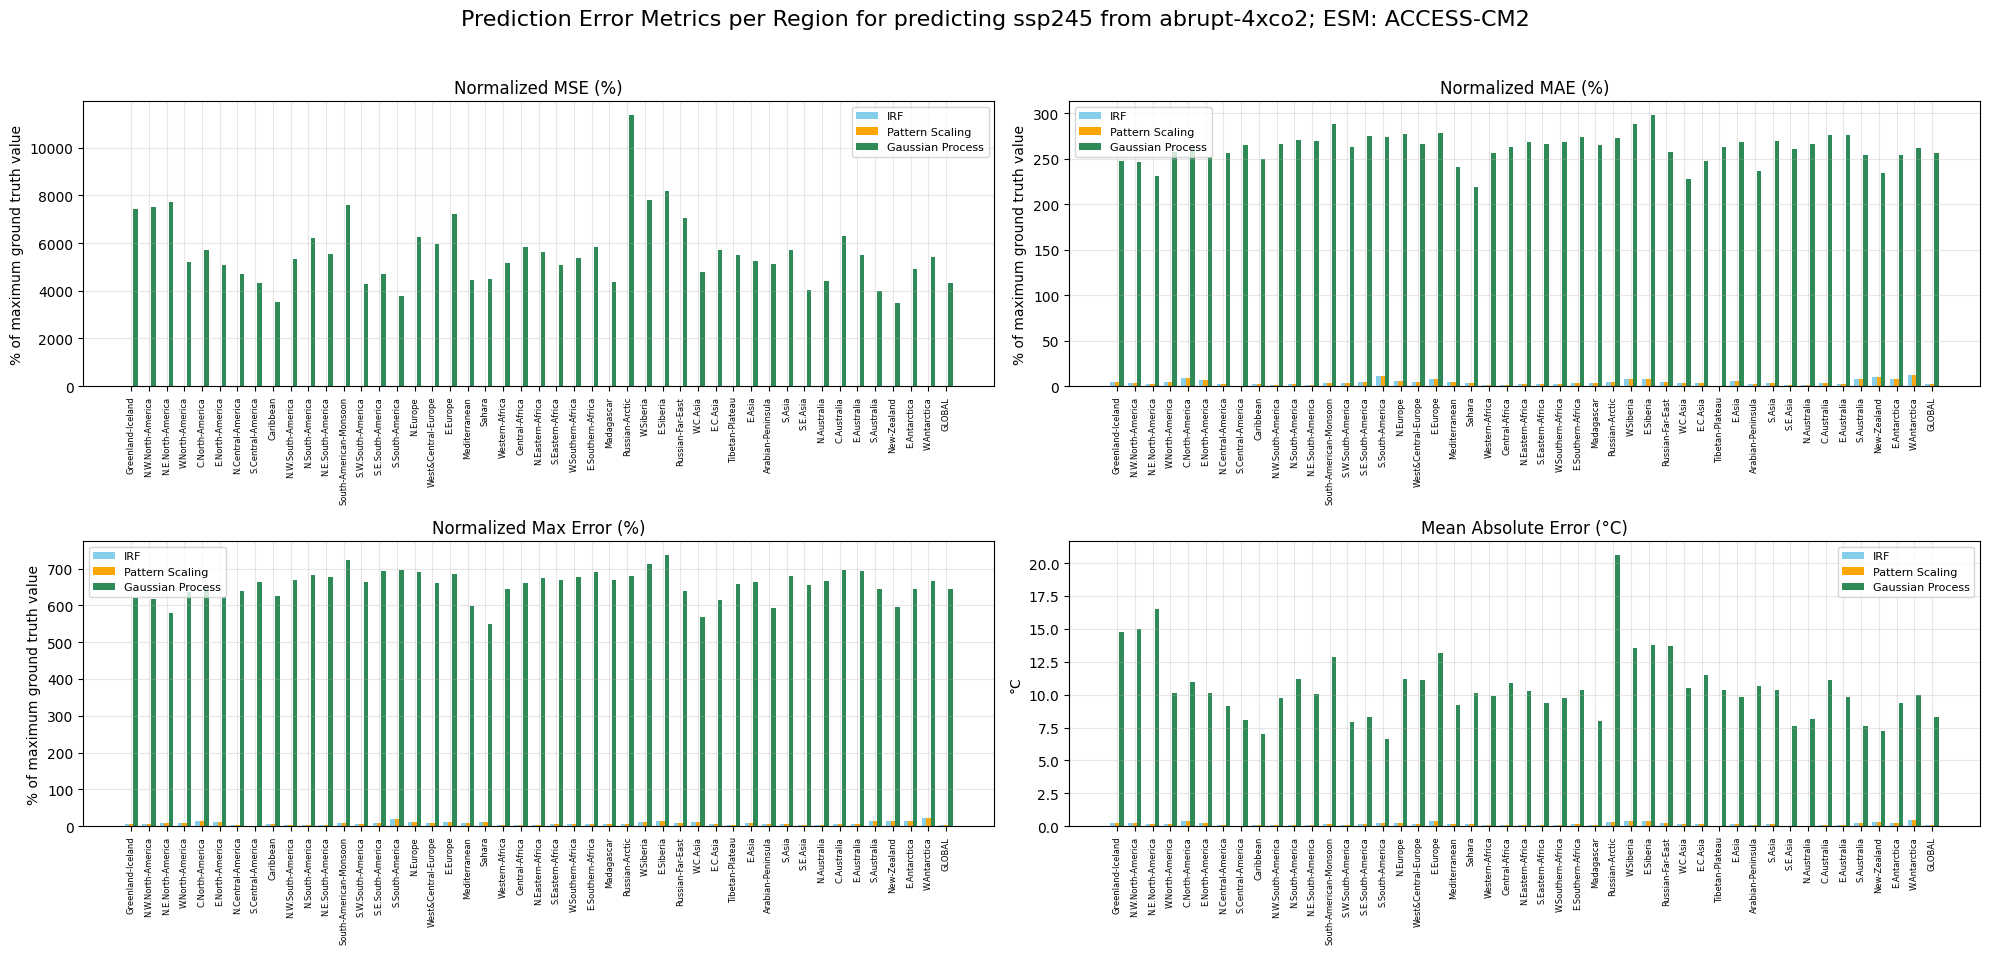

In [159]:
#predict pattern scaling 


b_pred_test_pattern_scaling = predict_regional_temperatures(test_smooth_pattern_scaling, slopes, intercepts)
b_pred_train_pattern_scaling = predict_regional_temperatures(train_smooth_pattern_scaling, slopes, intercepts)

# predict IRF

b_pred_test = M_test_smooth_matrix @ x
b_pred_train = M_train_smooth_matrix @ x




import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_timeseries_comparison_three(
    b_pred_IRF, 
    b_pred_pattern_scaling, 
    b_pred_GPR, 
    b_real, 
    region_list, 
    years
):
    """
    Plot IRF, Pattern Scaling, Gaussian Process, and Real timeseries 
    for multiple regions, plus their differences from the real data.

    Args:
        b_pred_IRF : np.ndarray (N x M) — IRF predicted values
        b_pred_pattern_scaling : np.ndarray (N x M) — Pattern Scaling predicted values
        b_pred_GPR : np.ndarray (N x M) — Gaussian Process predicted values
        b_real : np.ndarray (N x M) — Real values
        region_list : list of str — Region names (length M)
        years : list or np.ndarray (length N) — Years
    """
    N, M = b_real.shape
    assert b_pred_IRF.shape == (N, M), "b_pred_IRF must match shape of b_real"
    assert b_pred_pattern_scaling.shape == (N, M), "b_pred_pattern_scaling must match shape of b_real"
    assert b_pred_GPR.shape == (N, M), "b_pred_GPR must match shape of b_real"
    assert len(region_list) == M, "region_list length must match number of columns"
    assert len(years) == N, "years length must match number of rows"

    for i, region in enumerate(region_list):
        plt.figure(figsize=(14, 6))
        
        # --- Left plot: real vs all predictions ---
        plt.subplot(1, 2, 1)
        plt.plot(years, b_real[:, i], label="Real", color="black", linewidth=2)
        plt.plot(years, b_pred_IRF[:, i], label="IRF Prediction", color="red", linestyle="--")
        plt.plot(years, b_pred_pattern_scaling[:, i], label="Pattern Scaling", color="orange", linestyle=":")
        plt.plot(years, b_pred_GPR[:, i], label="GPR Prediction", color="green", linestyle="-.")

        plt.title(f"{region} — Real vs Predictions")
        plt.xlabel("Year")
        plt.ylabel("Temperature anomaly [°C]")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # --- Right plot: differences (residuals) ---
        plt.subplot(1, 2, 2)
        diff_IRF = b_pred_IRF[:, i] - b_real[:, i]
        diff_pattern = b_pred_pattern_scaling[:, i] - b_real[:, i]
        diff_GPR = b_pred_GPR[:, i] - b_real[:, i]

        plt.plot(years, diff_IRF, color="red", linestyle="--", label="IRF - Real")
        plt.plot(years, diff_pattern, color="orange", linestyle=":", label="Pattern Scaling - Real")
        plt.plot(years, diff_GPR, color="green", linestyle="-.", label="GPR - Real")

        plt.axhline(0, color="black", linewidth=1)
        plt.title(f"{region} — Differences (Prediction - Real)")
        plt.xlabel("Year")
        plt.ylabel("Difference [°C]")
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()


'''
import numpy as np
import matplotlib.pyplot as plt

def plot_region_error_metrics_two(b_pred_IRF, b_pred_pattern_scaling, b_real, region_list, title="Error Metrics by Region"):
    """
    Plot 4 error metrics for each region comparing IRF and Pattern Scaling predictions:
        1. Normalized MSE (% of max real)
        2. Normalized MAE (% of max real)
        3. Normalized Max Error (% of max real)
        4. Mean Absolute Error (absolute units)

    Args:
        b_pred_IRF : np.ndarray (N x M) — IRF predicted values
        b_pred_pattern_scaling : np.ndarray (N x M) — Pattern scaling predicted values
        b_real : np.ndarray (N x M) — real values
        region_list : list of str — names of regions (length M)
        title : str — title for the figure
    """
    N, M = b_real.shape
    assert b_pred_IRF.shape == (N, M), "b_pred_IRF must have same shape as b_real"
    assert b_pred_pattern_scaling.shape == (N, M), "b_pred_pattern_scaling must have same shape as b_real"
    assert len(region_list) == M, "region_list length must match number of columns"

    def compute_metrics(b_pred):
        norm_mse, norm_mae, norm_max_err, mae = [], [], [], []
        for i in range(M):
            real = b_real[:, i]
            pred = b_pred[:, i]
            max_real = np.nanmax(real)

            mse = np.nanmean((pred - real) ** 2)
            mae_val = np.nanmean(np.abs(pred - real))
            max_err_val = np.nanmax(np.abs(pred - real))

            norm_mse.append(100 * mse / max_real)
            norm_mae.append(100 * mae_val / max_real)
            norm_max_err.append(100 * max_err_val / max_real)
            mae.append(mae_val)
        return np.array(norm_mse), np.array(norm_mae), np.array(norm_max_err), np.array(mae)

    # Compute metrics for both methods
    irf_metrics = compute_metrics(b_pred_IRF)
    ps_metrics = compute_metrics(b_pred_pattern_scaling)

    # Plot setup
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16, y=0.95)

    metric_names = [
        "Normalized MSE (%)",
        "Normalized MAE (%)",
        "Normalized Max Error (%)",
        "Mean Absolute Error (°C)",
    ]
    y_labels = [
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "°C",
    ]

    x = np.arange(len(region_list))
    width = 0.4  # bar width

    for ax, irf_data, ps_data, mname, ylabel in zip(
        axes.flatten(), irf_metrics, ps_metrics, metric_names, y_labels
    ):
        ax.bar(x - width / 2, irf_data, width, label="IRF", color="skyblue")
        ax.bar(x + width / 2, ps_data, width, label="Pattern Scaling", color="orange")
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels(region_list, rotation=90, fontsize=6)
        ax.set_title(mname)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

'''
    
import matplotlib.pyplot as plt
import numpy as np

def plot_region_error_metrics_three(
    b_pred_IRF, b_pred_pattern_scaling, b_pred_GP, b_real, region_list, 
    title="Error Metrics by Region"
):
    """
    Plot 4 error metrics for each region comparing IRF, Pattern Scaling, and Gaussian Process predictions:
        1. Normalized MSE (% of max real)
        2. Normalized MAE (% of max real)
        3. Normalized Max Error (% of max real)
        4. Mean Absolute Error (absolute units)

    Args:
        b_pred_IRF : np.ndarray (N x M) — IRF predicted values
        b_pred_pattern_scaling : np.ndarray (N x M) — Pattern scaling predicted values
        b_pred_GP : np.ndarray (N x M) — Gaussian Process predicted values
        b_real : np.ndarray (N x M) — real values
        region_list : list of str — names of regions (length M)
        title : str — title for the figure
    """
    N, M = b_real.shape
    assert b_pred_IRF.shape == (N, M), "b_pred_IRF must have same shape as b_real"
    assert b_pred_pattern_scaling.shape == (N, M), "b_pred_pattern_scaling must have same shape as b_real"
    assert b_pred_GP.shape == (N, M), "b_pred_GP must have same shape as b_real"
    assert len(region_list) == M, "region_list length must match number of columns"

    def compute_metrics(b_pred):
        norm_mse, norm_mae, norm_max_err, mae = [], [], [], []
        for i in range(M):
            real = b_real[:, i]
            pred = b_pred[:, i]
            max_real = np.nanmax(real)

            mse = np.nanmean((pred - real) ** 2)
            mae_val = np.nanmean(np.abs(pred - real))
            max_err_val = np.nanmax(np.abs(pred - real))

            norm_mse.append(100 * mse / max_real)
            norm_mae.append(100 * mae_val / max_real)
            norm_max_err.append(100 * max_err_val / max_real)
            mae.append(mae_val)
        return np.array(norm_mse), np.array(norm_mae), np.array(norm_max_err), np.array(mae)

    # Compute metrics for all three methods
    irf_metrics = compute_metrics(b_pred_IRF)
    ps_metrics = compute_metrics(b_pred_pattern_scaling)
    gp_metrics = compute_metrics(b_pred_GP)

    # --- Plot setup ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16, y=0.95)

    metric_names = [
        "Normalized MSE (%)",
        "Normalized MAE (%)",
        "Normalized Max Error (%)",
        "Mean Absolute Error (°C)",
    ]
    y_labels = [
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "°C",
    ]

    x = np.arange(len(region_list))
    width = 0.25  # narrower for three bars per region

    for ax, irf_data, ps_data, gp_data, mname, ylabel in zip(
        axes.flatten(), irf_metrics, ps_metrics, gp_metrics, metric_names, y_labels
    ):
        ax.bar(x - width, irf_data, width, label="IRF", color="skyblue")
        ax.bar(x, ps_data, width, label="Pattern Scaling", color="orange")
        ax.bar(x + width, gp_data, width, label="Gaussian Process", color="seagreen")
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels(region_list, rotation=90, fontsize=6)
        ax.set_title(mname)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()



print(b_pred_test.shape)
plot_timeseries_comparison_three(#b_pred_test, 
    b_pred_test_pattern_scaling, 
    b_pred_test_pattern_scaling, 
    #b_pred_gaussian_processes, 
    #b_pred_operator_gp,
    regional_pred_modal_fitting,
    b_smooth_test, 
    regional_train_roll_clean_for_b.columns,  
    global_train_clean.year.to_numpy())

plot_region_error_metrics_three(
    #b_pred_test,
    b_pred_test_pattern_scaling, 
    b_pred_test_pattern_scaling,
    regional_pred_modal_fitting,
    #b_pred_operator_gp,
    #b_pred_gaussian_processes,
    b_smooth_test, 
    regional_train_roll_clean_for_b.columns, 
    title=f"Prediction Error Metrics per Region for predicting {TEST_SCENARIO} from {TRAIN_SCENARIO}; ESM: {MODEL}"
)